In [12]:
from collections import Counter
from datasets import load_dataset
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_metric
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import time
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from gensim.models import Word2Vec
from gensim.models import FastText
import torch
import torch.nn as nn
import pickle

## 1. Loading and Analysing Dataset

This part shows the code for loading, visualing, and analysing the dataset.

To start, the dataset will first be loaded below.

In [3]:
#Load the Dataset
datasets = load_dataset("surrey-nlp/PLOD-CW",trust_remote_code=True)
datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 1072
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 126
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 153
    })
})

Next, the number of tokens for the dataset's differnt splits will then be viewed.

In [848]:
print(f"Number of tokens in the training set: {len([token for sublist in datasets['train']['tokens'] for token in sublist])}")
print(f"Number of tokens in the validation set: {len([token for sublist in datasets['validation']['tokens'] for token in sublist])}")
print(f"Number of tokens in the test set: {len([token for sublist in datasets['test']['tokens'] for token in sublist])}")

Number of tokens in the training set: 40000
Number of tokens in the validation set: 5000
Number of tokens in the test set: 5000


After that, the dataset's structure and labels will be viewed.

In [5]:
for item in ['train','validation','test']:
    tokens, labels, pos = datasets[item]['tokens'][10], datasets[item]['ner_tags'][10], datasets[item]['pos_tags'][10]
    df = pd.DataFrame({'Tokens': tokens, 'Labels': labels, 'POS': pos})
    print(f"\nDataset Visualization for {item} set")
    print(tabulate(df, headers='keys', tablefmt='psql'))


Dataset Visualization for train set
+----+---------------+----------+-------+
|    | Tokens        | Labels   | POS   |
|----+---------------+----------+-------|
|  0 | DHI           | B-AC     | PROPN |
|  1 | was           | B-O      | AUX   |
|  2 | significantly | B-O      | ADV   |
|  3 | correlated    | B-O      | VERB  |
|  4 | to            | B-O      | ADP   |
|  5 | PCL           | B-AC     | PROPN |
|  6 | scores        | B-O      | NOUN  |
|  7 | ,             | B-O      | PUNCT |
|  8 | suggesting    | B-O      | VERB  |
|  9 | that          | B-O      | SCONJ |
| 10 | Veterans      | B-O      | NOUN  |
| 11 | with          | B-O      | ADP   |
| 12 | more          | B-O      | ADJ   |
| 13 | severe        | B-O      | ADJ   |
| 14 | PTSD          | B-AC     | PROPN |
| 15 | symptoms      | B-O      | NOUN  |
| 16 | also          | B-O      | ADV   |
| 17 | had           | B-O      | VERB  |
| 18 | more          | B-O      | ADJ   |
| 19 | dizziness     | B-O      | NOUN 

To view an clearer representation of the labels, a table that shows what the tokens look like in each class is then plotted.

In [4]:
max_examples = 30

train_labels = [item for sublist in datasets['train']['ner_tags'] for item in sublist]
train_tokens = [item for sublist in datasets['train']['tokens'] for item in sublist]
class_dict = {label:[] for label in set(train_labels)}

for tokens,labels in zip(train_tokens,train_labels):
    class_dict[labels].append(tokens)
df = pd.DataFrame({k: class_dict[k][:max_examples] for k in class_dict})
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+---------------+--------------+---------------+-----------------------+
|    | B-O           | B-AC         | B-LF          | I-LF                  |
|----+---------------+--------------+---------------+-----------------------|
|  0 | For           | GYPES        | Gothenburg    | Young                 |
|  1 | this          | gs           | stomatal      | Persons               |
|  2 | purpose       | E            | transpiration | Empowerment           |
|  3 | the           | PN           | net           | Scale                 |
|  4 | (             | CO2          | intercellular | conductance           |
|  5 | )             | Ci           | human         | rate                  |
|  6 | was           | H            | stem          | photosynthetic        |
|  7 | developed     | HLA)–matched | Echo          | rate                  |
|  8 | .             | SCT          | profilin-1    | CO2                   |
|  9 | The           | EPI          | S             | concentrat

Then, the dataset's class label distribution is visualized below.

C:\Users\Jian He\AppData\Local\Temp\ipykernel_15840\2271694756.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(item, palette=color_palette[count])


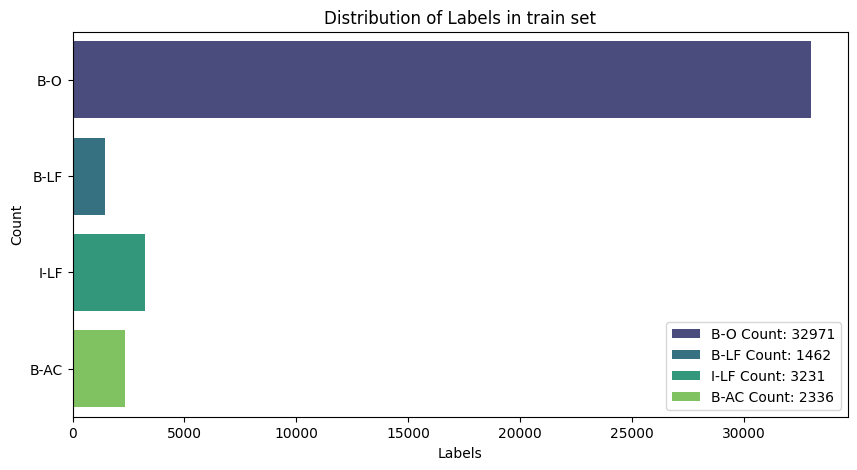

C:\Users\Jian He\AppData\Local\Temp\ipykernel_15840\2271694756.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(item, palette=color_palette[count])


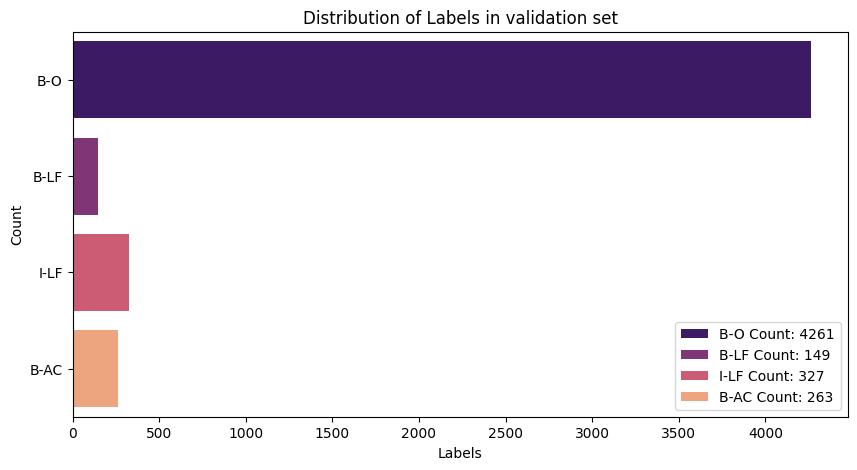

C:\Users\Jian He\AppData\Local\Temp\ipykernel_15840\2271694756.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(item, palette=color_palette[count])


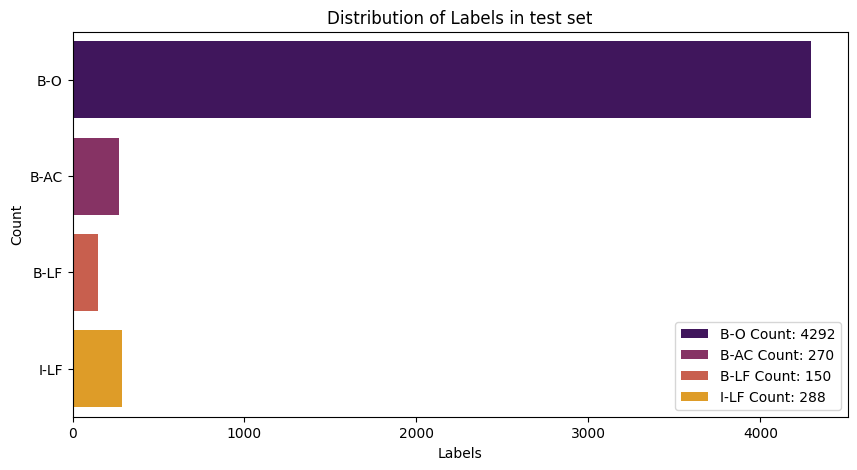

In [9]:
# Here all the different splits of datasets will be visualized
name  = ['train','validation','test']
color_palette = ['viridis','magma','inferno']
train_labels = [item for sublist in datasets['train']['ner_tags'] for item in sublist]
val_labels = [item for sublist in datasets['validation']['ner_tags'] for item in sublist]
test_labels = [item for sublist in datasets['test']['ner_tags'] for item in sublist]

for count, item in enumerate([train_labels, val_labels, test_labels]):
    plt.figure(figsize=(10, 5))
    sns.countplot(item, palette=color_palette[count])
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(f'Distribution of Labels in {name[count]} set')
    count = Counter(item)
    count_dict = {k: count[k] for k in count}
    plt.legend([f'{label} Count: {count_dict[label]}' for label in count_dict])
    
    plt.show()

After that, the distribution of the most common and least common tokens in the datasets were visualized.

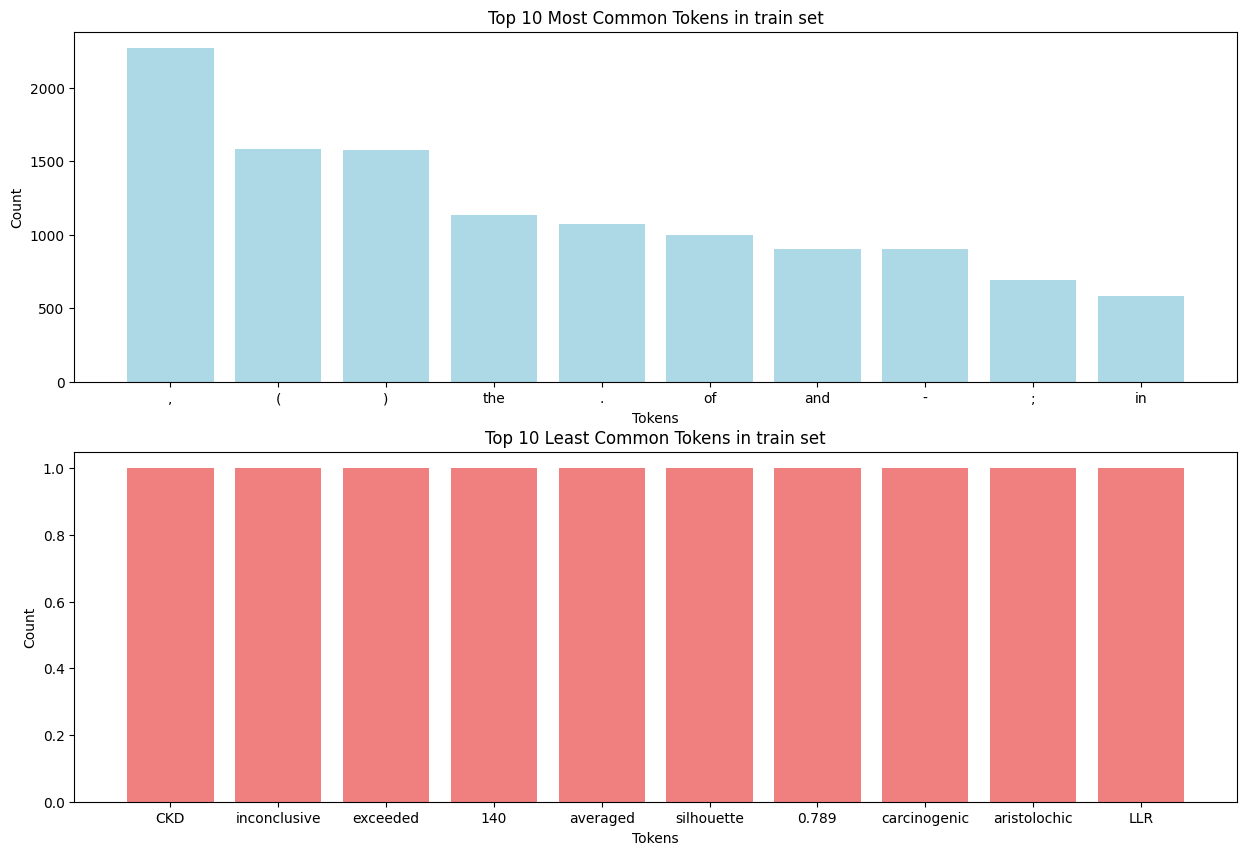

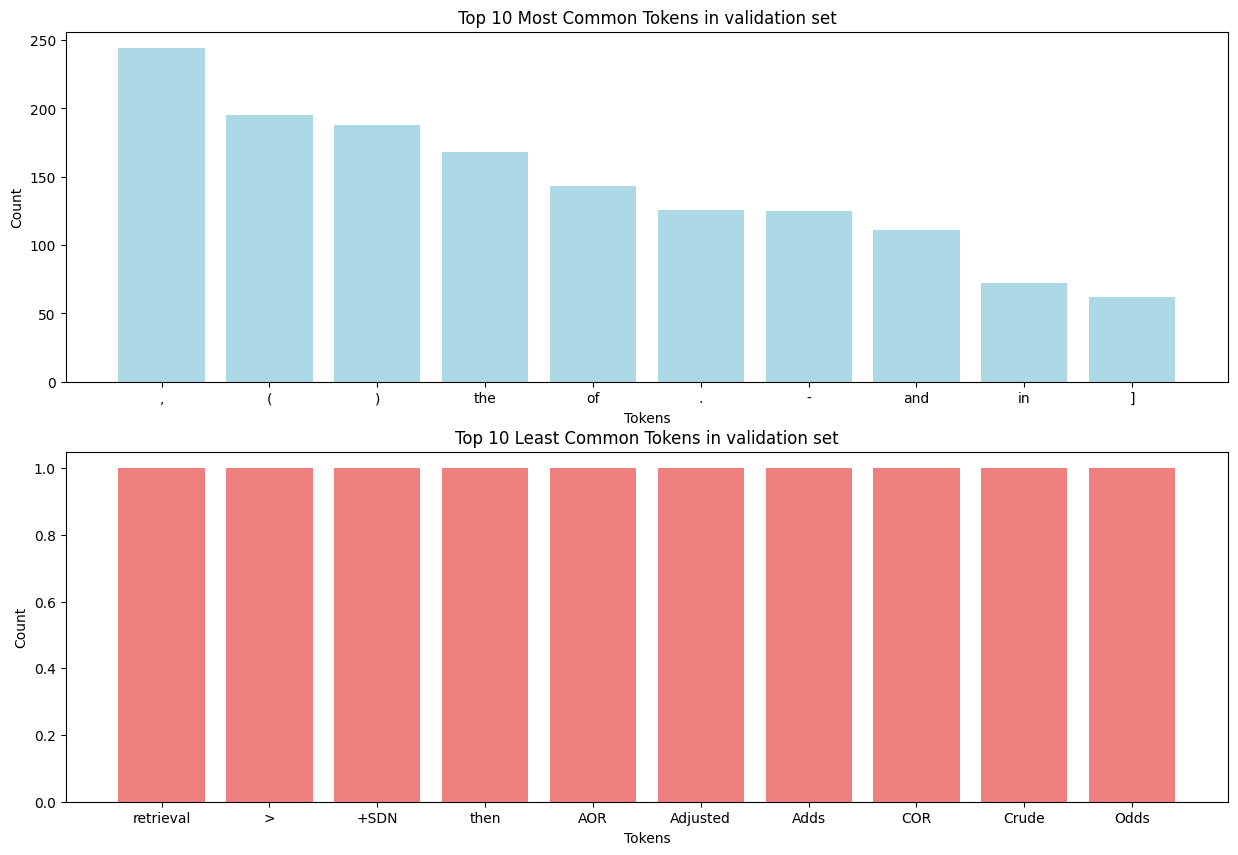

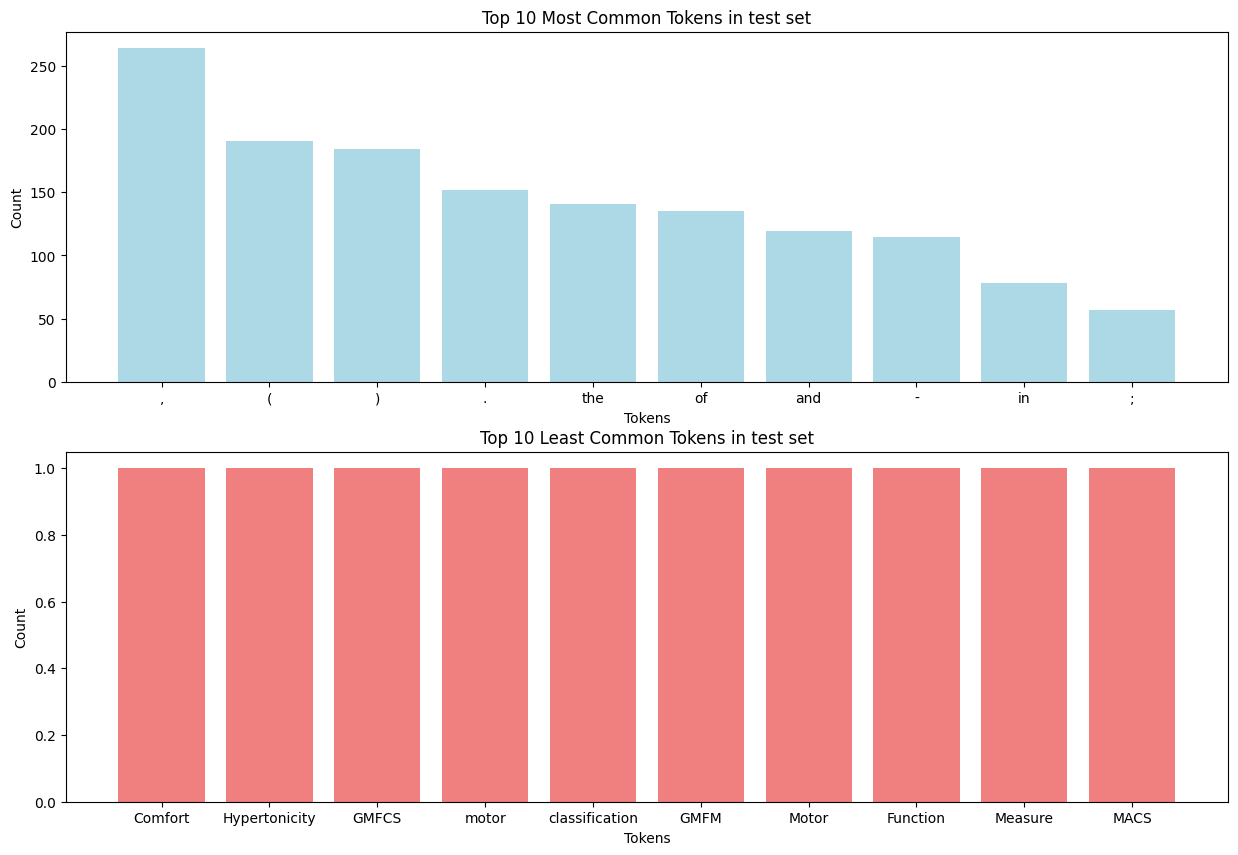

In [5]:
train_tokens = [item for sublist in datasets['train']['tokens'] for item in sublist]
val_tokens = [item for sublist in datasets['validation']['tokens'] for item in sublist]
test_tokens = [item for sublist in datasets['test']['tokens'] for item in sublist]
names = ['train','validation','test']

for count,item in enumerate([train_tokens, val_tokens, test_tokens]): 
    # The Counter Function is used to count the frequency of each token in the dataset
    Most_Common_Tokens = Counter(item).most_common(10)
    Least_Common_Tokens = Counter(item).most_common()[-10:]
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10))
    ax1.bar([x[0] for x in Most_Common_Tokens], [x[1] for x in Most_Common_Tokens], color='lightblue')
    ax1.set_xlabel('Tokens')
    ax1.set_ylabel('Count')
    ax1.set_title(f'Top 10 Most Common Tokens in {names[count]} set')
    ax2.bar([x[0] for x in Least_Common_Tokens], [x[1] for x in Least_Common_Tokens], color='lightcoral')
    ax2.set_xlabel('Tokens')
    ax2.set_ylabel('Count')
    ax2.set_title(f'Top 10 Least Common Tokens in {names[count]} set')
    



Then, the distribution of POS Tag labels were visualized.

C:\Users\Jian He\AppData\Local\Temp\ipykernel_18288\3658739958.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(train_pos, palette='viridis')


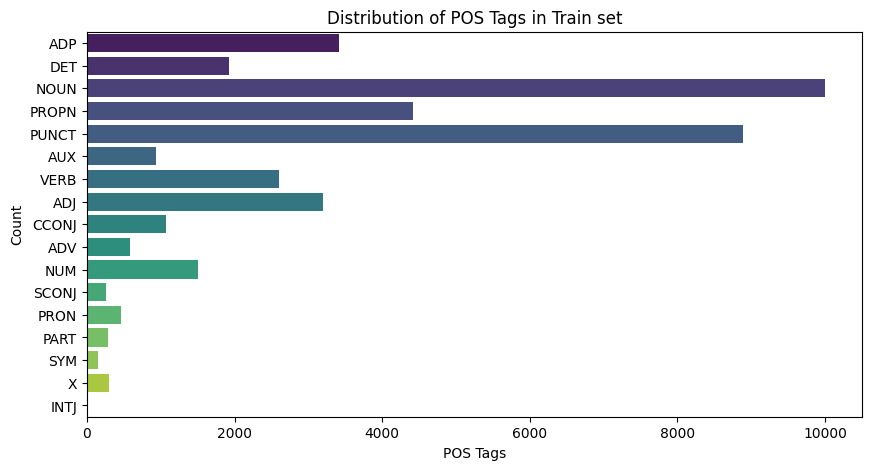

In [31]:
# Here, the POS Tag labels in the train set will be used
train_pos = [item for sublist in datasets['train']['pos_tags'] for item in sublist]

plt.figure(figsize=(10, 5))
sns.countplot(train_pos, palette='viridis')
plt.xlabel('POS Tags')
plt.ylabel('Count')
plt.title('Distribution of POS Tags in Train set')
plt.show()


Finally, the dataset's most common and least common long forma and short form tokens will be visualized.

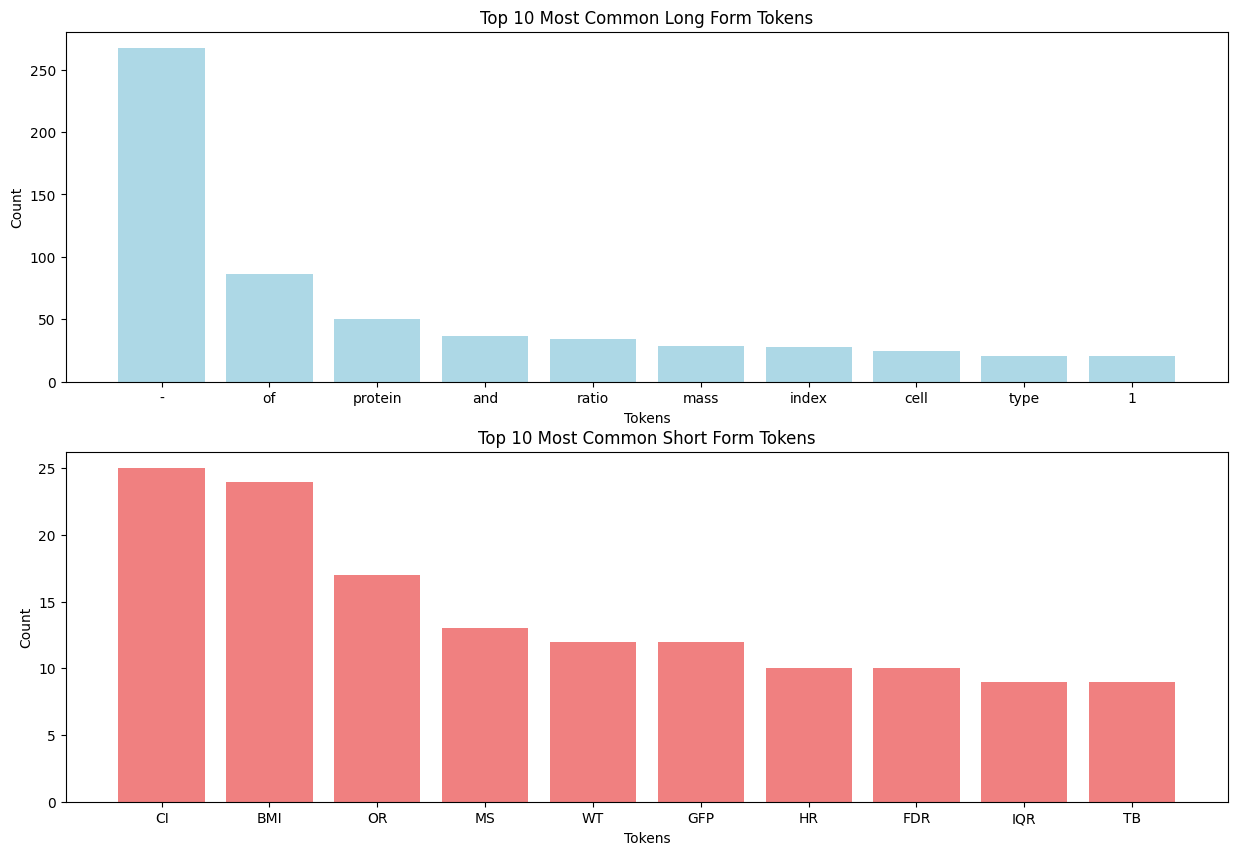

In [46]:
# Create a list that only contains Long Forms
long_form_tokens = [token for token,labels in zip(train_tokens,train_labels) if labels.endswith('LF')]
# Create a list that only contains Short Forms
short_form_tokens = [token for token,labels in zip(train_tokens,train_labels) if labels.endswith('AC')]

# Count the frequency of each token in the long form list
lf_count = Counter(long_form_tokens)
# Count the frequency of each token in the short form list
ac_count = Counter(short_form_tokens)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10))
ax1.bar([x[0] for x in lf_count.most_common(10)], [x[1] for x in lf_count.most_common(10)], color='lightblue')
ax1.set_xlabel('Tokens')
ax1.set_ylabel('Count')
ax1.set_title('Top 10 Most Common Long Form Tokens')
ax2.bar([x[0] for x in ac_count.most_common(10)], [x[1] for x in ac_count.most_common(10)], color='lightcoral')
ax2.set_xlabel('Tokens')
ax2.set_ylabel('Count')
ax2.set_title('Top 10 Most Common Short Form Tokens')
plt.show()


With the data visualized and analysed, the experiments can now begin.

## 2.1 Experiment I: Text Encoding / Transformation into Numerical Vector

Test 1. One-Hot Encoding

Test 2. Word2Vec

Test 3. FastText

Test 4. BERT vectorization

Note: Since Pretrained Word2Vec and FastText models face the Out of Vocabulary error, custom training for these encoders will be done 

Before running the tests, several functions for metrics calculation, plotting, model training, and helper functions will be defined.

In [14]:
#Load Sequence Evaluation Metric
metric = load_metric("seqeval", trust_remote_code=True)
def calculate_results(y_true, y_pred):
    print(f"\nClassification Report\n")
    #Print Results using Classification Report Function
    print(classification_report(y_true, y_pred))

    #Compute Results using Sequence Evaluation Metric
    metric_results = metric.compute(predictions = [y_pred], references = [y_true])
    df = pd.DataFrame([metric_results['AC'], metric_results['LF'], metric_results['O']],index=['AC','LF','O'])
    print(tabulate(df, headers='keys', tablefmt='psql'))
    #Overall Results
    df = pd.DataFrame([metric_results['overall_precision'], 
                       metric_results['overall_recall'], 
                       metric_results['overall_f1'], 
                       metric_results['overall_accuracy']],
                       index=['Overall Precision','Overall Recall','Overall F1','Overall Accuracy'])
    print(tabulate(df, tablefmt='psql'))
    return metric_results

#Confusion Matrix Function obtained from https://github.com/surrey-nlp/PLOD-AbbreviationDetection/blob/main/nbs/fine_tuning_abbr_det.ipynb
def plot_cm(y_true, y_pred, name, figsize=(8,8)):
    #Get Confusion Matrix Values
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            #Annotated Confusion Matrix with Percentage
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(f'Confusion Matrix for {name}')
    #Use seaborn heatmap to plot the confusion matrix
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax).figure

def plot_roc(y_true, y_prob, name):
    #Use Label Binarizer to binarize the labels so it can be used in the roc_curve function
    lb = LabelBinarizer().fit(y_true)
    y_true = lb.transform(y_true)
    plt.figure(figsize=(8, 6))
    for i in range(len(lb.classes_)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{lb.classes_[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance Level (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve with AUC for {name}')
    plt.legend(loc='lower right')
    plt.show()

#The function below is used to create a barplot comparison of performance metrics for different methods (specific class)
def plot_comparison(method_list, method_names, class_name, ylim=(0,1)):
    Precision = [method[class_name]['precision'] for method in method_list]
    Recall = [method[class_name]['recall'] for method in method_list]
    F1 = [method[class_name]['f1'] for method in method_list]
    print(Precision)
    df = pd.DataFrame({f'{class_name.upper()} Precision': Precision, f'{class_name.upper()} Recall': Recall, f'{class_name.upper()} F1': F1}, index=method_names)
    print(tabulate(df, headers='keys', tablefmt='psql'))
    ax = df.plot(kind='bar', figsize=(10, 5), colormap='viridis')
    ax.set_xlabel('Methods')
    ax.set_ylabel('Performance Score')
    ax.xaxis.set_tick_params(rotation=0)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'{class_name.upper()} Result Comparison for Different Methods')
    ax.set_ylim(ylim)
    plt.show()

#The function below is used to create a barplot comparison of performance metrics for different methods (overall)
def plot_overall_comparison(method_list, method_names, ylim=(0,1)):
    Precision = [method['overall_precision'] for method in method_list]
    Recall = [method['overall_recall'] for method in method_list]
    F1 = [method['overall_f1'] for method in method_list]
    Accuracy = [method['overall_accuracy'] for method in method_list]
    df = pd.DataFrame({'Overall Precision': Precision, 'Overall Recall': Recall, 'Overall F1': F1, 'Overall Accuracy': Accuracy}, index=method_names)
    print(tabulate(df, headers='keys', tablefmt='psql'))
    ax = df.plot(kind='bar', figsize=(10, 5), colormap='viridis')
    ax.set_xlabel('Methods')
    ax.set_ylabel('Performance Score')
    ax.set_ylim(ylim)
    ax.xaxis.set_tick_params(rotation=0)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('Overall Result Comparison for Different Methods')
    plt.show()

#Create a wrapper to time the model
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        print(f"Execution Time: {float(time.time()-start):.2f} seconds")
        return result
    return wrapper

@timing_decorator
def train(train_vec_tokens, train_labels):
    #Initialize a basic multiclass logistic regression model
    #Use the 'saga' solver for faster convergence
    #Use the 'multinomial' option for multiclass classification
    #Use the 'random_state' parameter for reproducibility
    model = LogisticRegression(multi_class='multinomial', solver='saga', random_state=1)
    model.fit(train_vec_tokens, train_labels)
    return model

def train_and_eval(train_vec_tokens, test_vec_tokens, train_labels, test_labels, input_name):
    model = train(train_vec_tokens, train_labels)
    predictions = model.predict(test_vec_tokens)
    pred_prob = model.predict_proba(test_vec_tokens)
    results = calculate_results(test_labels, predictions)
    plot_cm(test_labels, predictions, name=input_name)
    plot_roc(test_labels, pred_prob, input_name)
    filename = 'LR_NERtask_model.sav'             ### Comment if not needed for saving
    pickle.dump(model, open(filename, 'wb'))
    return results

combined_dataset = datasets['train']['tokens'] + datasets['validation']['tokens'] + datasets['test']['tokens']
flatten_combined_data = [item for sublist in combined_dataset for item in sublist]


Once the functions are created, the test will be carried out below.

# Test 1. One Hot Encoding

In [7]:
#Pass the flattened dataset through a set to filter out repeating tokens
#Get the length of the set to get the total number of unique tokens
vector_dimension = len(set(flatten_combined_data))

#Create a zero vector of the same length as the unique tokens
zero_vector = np.zeros(vector_dimension)

#Create a lambda function that creates the one hot encoding based on the token's index
replace_zero = lambda count: [0 if i != count else 1 for i in range(vector_dimension)]

#Create a dictionary with the unique tokens as keys and the one hot encoding as values
vocab = {token: replace_zero(count) for count,token in enumerate(set(flatten_combined_data))}


Train Vector Shape: 40000

Classification Report

              precision    recall  f1-score   support

        B-AC       0.85      0.19      0.31       270
        B-LF       0.38      0.05      0.09       150
         B-O       0.88      0.99      0.93      4292
        I-LF       0.57      0.15      0.23       288

    accuracy                           0.87      5000
   macro avg       0.67      0.35      0.39      5000
weighted avg       0.84      0.87      0.83      5000

+----+-------------+-----------+-----------+----------+
|    |   precision |    recall |        f1 |   number |
|----+-------------+-----------+-----------+----------|
| AC |   0.852459  | 0.192593  | 0.314199  |      270 |
| LF |   0.0227273 | 0.0131579 | 0.0166667 |      152 |
| O  |   0.876342  | 0.989049  | 0.929291  |     4292 |
+----+-------------+-----------+-----------+----------+
+-------------------+----------+
| Overall Precision | 0.861005 |
| Overall Recall    | 0.911964 |
| Overall F1        | 0.

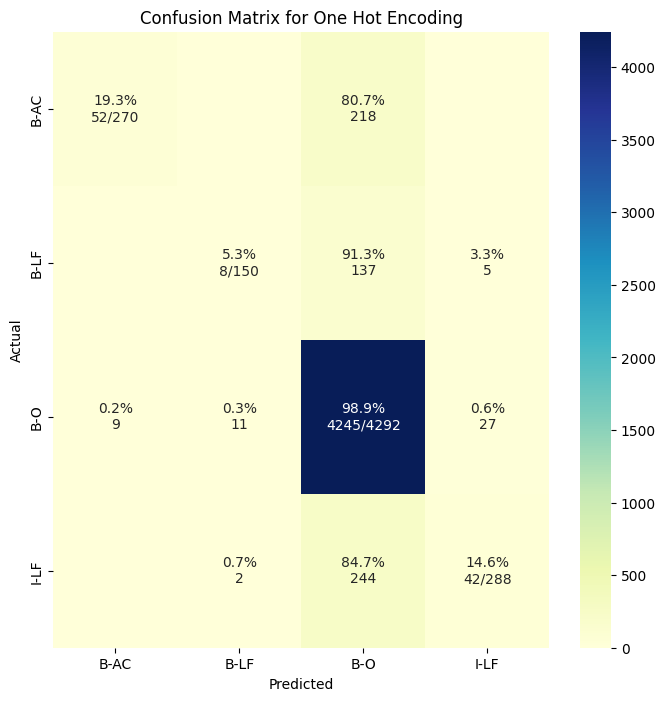

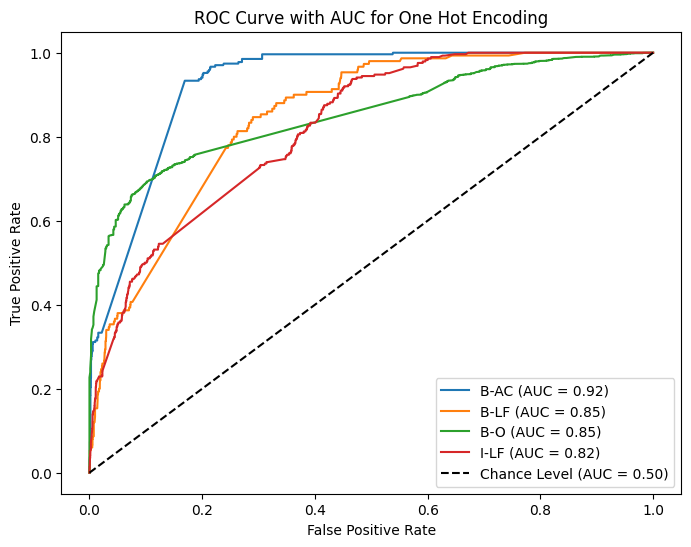

Execution Time: 143.48 seconds


In [14]:
train_vec_tokens = [vocab[token] for token in train_tokens]
test_vec_tokens = [vocab[token] for token in test_tokens]

ohe_results = train_and_eval(train_vec_tokens, test_vec_tokens, train_labels, test_labels, 'One Hot Encoding')

# Test 2. Word2Vec

Here, 2 sizes of the Word2Vec model will be trained.

In [15]:
#Small Word2Vec model with 100 dimension vector
small_w2v_model = Word2Vec(sentences=combined_dataset, vector_size=100, workers=8, min_count=0, epochs=100, window=5)

#Large Word2Vec model with 1000 dimension vector
#Epoch was raised to make sure the model is trained well
large_w2v_model = Word2Vec(sentences=combined_dataset, vector_size=1000, workers=8, min_count=0, epochs=200, window=5)


c:\Users\Jian He\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification Report

              precision    recall  f1-score   support

        B-AC       0.45      0.17      0.25       270
        B-LF       0.00      0.00      0.00       150
         B-O       0.87      0.98      0.92      4292
        I-LF       0.39      0.13      0.19       288

    accuracy                           0.86      5000
   macro avg       0.43      0.32      0.34      5000
weighted avg       0.80      0.86      0.82      5000

+----+-------------+----------+----------+----------+
|    |   precision |   recall |       f1 |   number |
|----+-------------+----------+----------+----------|
| AC |    0.447619 | 0.174074 | 0.250667 |      270 |
| LF |    0        | 0        | 0        |      152 |
| O  |    0.873906 | 0.976934 | 0.922552 |     4292 |
+----+-------------+----------+----------+----------+
+-------------------+----------+
| Overall Precision | 0.848849 |
| Overall Recall    | 0.899448 |
| Overall F1        | 0.873416 |
| Overall Accuracy  | 0.8554   

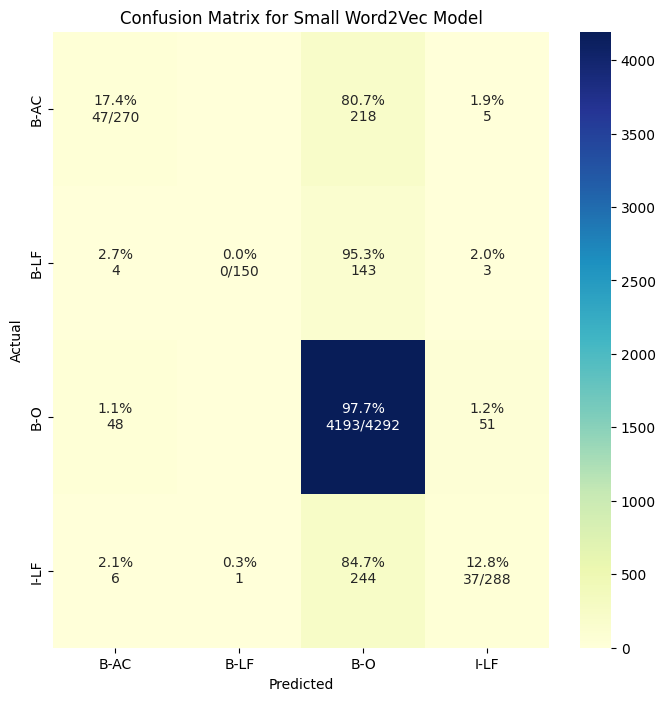

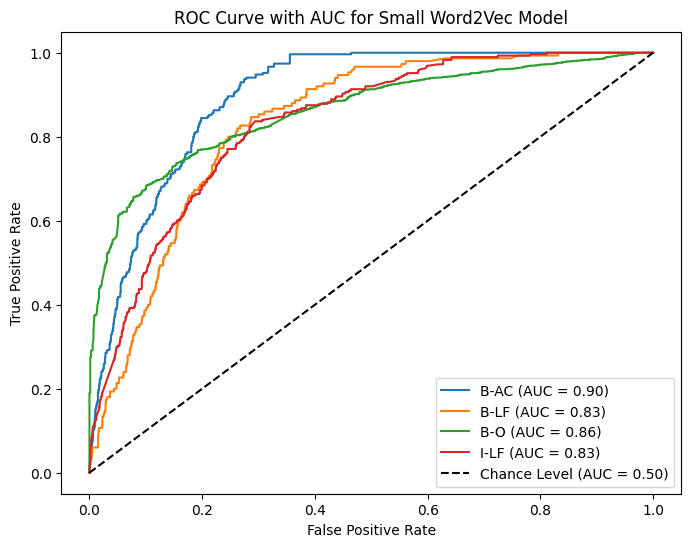

Execution Time: 7.02 seconds


In [666]:
#Vectorize token with small word2vec model
train_vec_tokens = small_w2v_model.wv[train_tokens]
test_vec_tokens = small_w2v_model.wv[test_tokens]
#Train and evaluate the model
small_w2v_results = train_and_eval(train_vec_tokens, test_vec_tokens, train_labels, test_labels, 'Small Word2Vec Model')

c:\Users\Jian He\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification Report

              precision    recall  f1-score   support

        B-AC       0.48      0.21      0.29       270
        B-LF       0.60      0.02      0.04       150
         B-O       0.88      0.98      0.92      4292
        I-LF       0.44      0.16      0.24       288

    accuracy                           0.86      5000
   macro avg       0.60      0.34      0.37      5000
weighted avg       0.82      0.86      0.82      5000

+----+-------------+-----------+-----------+----------+
|    |   precision |    recall |        f1 |   number |
|----+-------------+-----------+-----------+----------|
| AC |   0.478992  | 0.211111  | 0.293059  |      270 |
| LF |   0.0288462 | 0.0197368 | 0.0234375 |      152 |
| O  |   0.878356  | 0.975769  | 0.924503  |     4292 |
+----+-------------+-----------+-----------+----------+
+-------------------+----------+
| Overall Precision | 0.851132 |
| Overall Recall    | 0.901146 |
| Overall F1        | 0.875425 |
| Overall Accurac

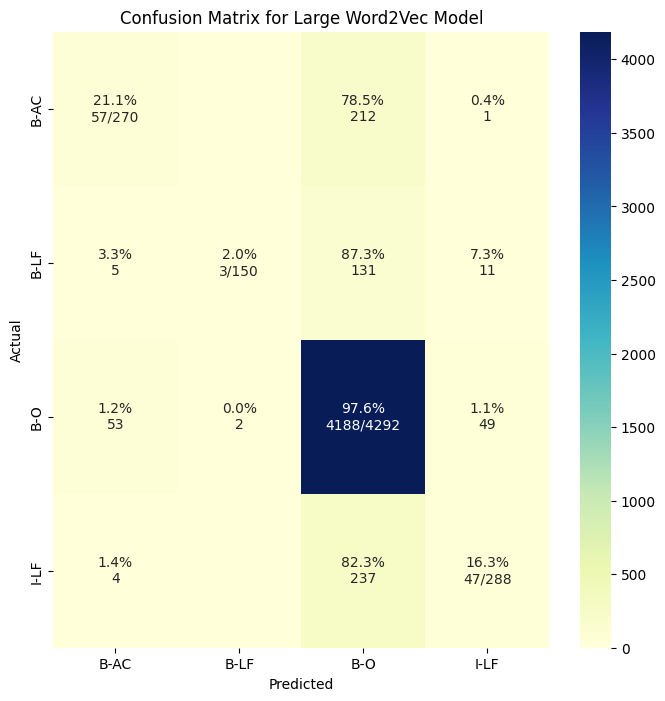

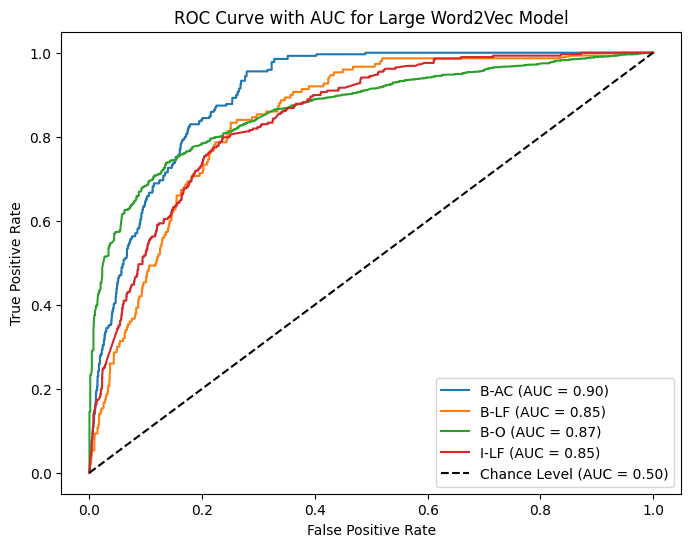

Execution Time: 51.49 seconds


In [17]:
train_vec_tokens = large_w2v_model.wv[train_tokens]
test_vec_tokens = large_w2v_model.wv[test_tokens]

large_w2v_results = train_and_eval(train_vec_tokens, test_vec_tokens, train_labels, test_labels, 'Large Word2Vec Model')

# Test 3. FastText

2 sizes of FastText will also be trained.

In [18]:
#Small FastText model
small_ft_model = FastText(sentences=combined_dataset, vector_size=100, workers=8, epochs=100)

#FastText model with larger vector dimension of 1000
large_ft_model = FastText(sentences=combined_dataset, vector_size=1000, workers=8, epochs=200)

c:\Users\Jian He\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification Report

              precision    recall  f1-score   support

        B-AC       0.50      0.64      0.56       270
        B-LF       0.00      0.00      0.00       150
         B-O       0.89      0.96      0.92      4292
        I-LF       0.49      0.06      0.11       288

    accuracy                           0.86      5000
   macro avg       0.47      0.42      0.40      5000
weighted avg       0.82      0.86      0.83      5000

+----+-------------+----------+----------+----------+
|    |   precision |   recall |       f1 |   number |
|----+-------------+----------+----------+----------|
| AC |    0.50289  | 0.644444 | 0.564935 |      270 |
| LF |    0        | 0        | 0        |      152 |
| O  |    0.889322 | 0.956664 | 0.921765 |     4292 |
+----+-------------+----------+----------+----------+
+-------------------+----------+
| Overall Precision | 0.856171 |
| Overall Recall    | 0.907934 |
| Overall F1        | 0.881293 |
| Overall Accuracy  | 0.8594   

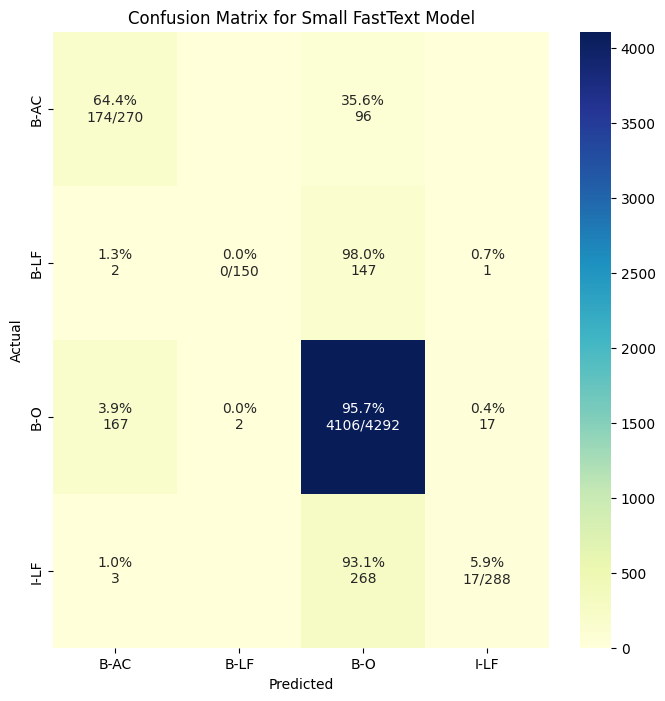

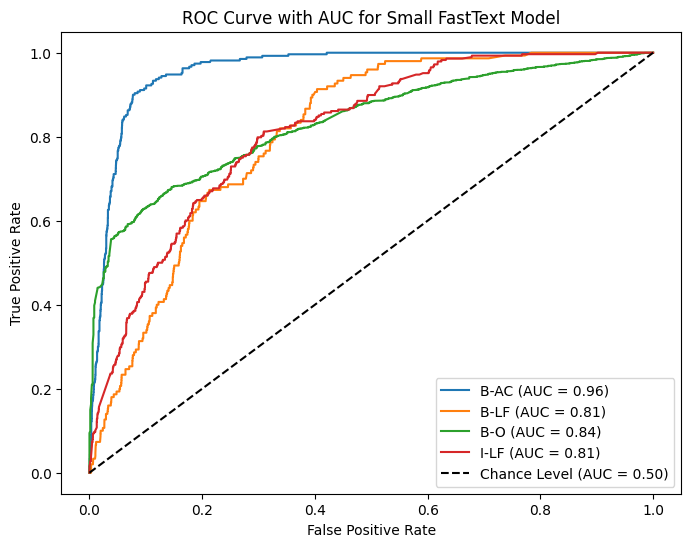

Execution Time: 5.61 seconds


In [19]:
train_vec_tokens = small_ft_model.wv[train_tokens]
test_vec_tokens = small_ft_model.wv[test_tokens]
small_ft_results = train_and_eval(train_vec_tokens, test_vec_tokens, train_labels, test_labels, 'Small FastText Model')

c:\Users\Jian He\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification Report

              precision    recall  f1-score   support

        B-AC       0.50      0.70      0.58       270
        B-LF       0.00      0.00      0.00       150
         B-O       0.89      0.95      0.92      4292
        I-LF       0.44      0.07      0.13       288

    accuracy                           0.86      5000
   macro avg       0.46      0.43      0.41      5000
weighted avg       0.82      0.86      0.83      5000

+----+-------------+----------+----------+----------+
|    |   precision |   recall |       f1 |   number |
|----+-------------+----------+----------+----------|
| AC |    0.497382 | 0.703704 | 0.582822 |      270 |
| LF |    0        | 0        | 0        |      152 |
| O  |    0.89364  | 0.949441 | 0.920696 |     4292 |
+----+-------------+----------+----------+----------+
+-------------------+----------+
| Overall Precision | 0.853512 |
| Overall Recall    | 0.904752 |
| Overall F1        | 0.878385 |
| Overall Accuracy  | 0.8572   

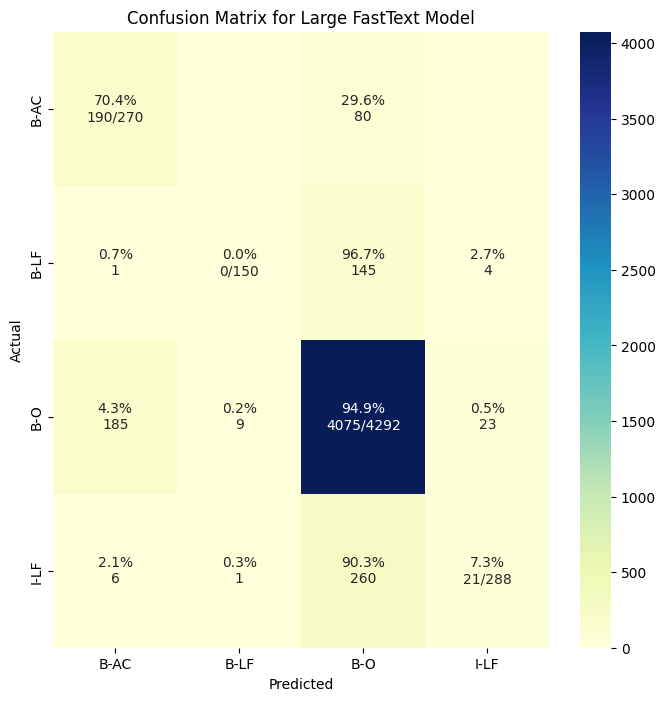

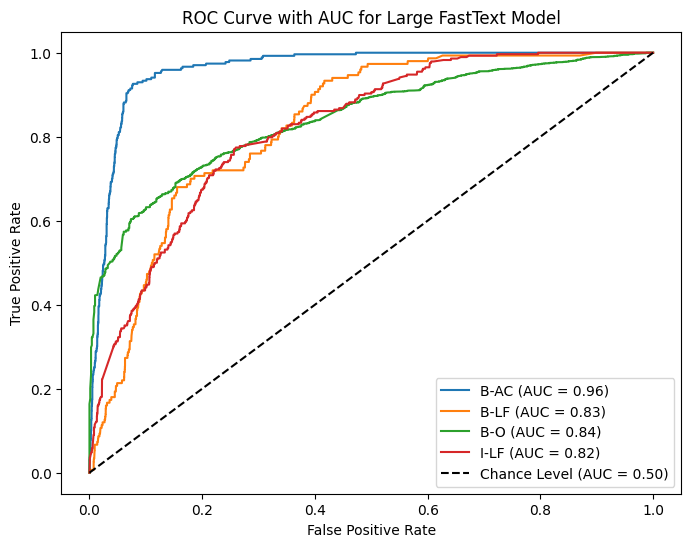

Execution Time: 49.47 seconds


In [20]:
train_vec_tokens = large_ft_model.wv[train_tokens]
test_vec_tokens = large_ft_model.wv[test_tokens]
large_ft_results = train_and_eval(train_vec_tokens, test_vec_tokens, train_labels, test_labels, 'Large FastText Model')

Comparing Results of Custom Word Vectorizers

[0.8524590163934426, 0.44761904761904764, 0.4789915966386555, 0.5028901734104047, 0.4973821989528796]
+------------------+----------------+-------------+----------+
|                  |   AC Precision |   AC Recall |    AC F1 |
|------------------+----------------+-------------+----------|
| One Hot Encoding |       0.852459 |    0.192593 | 0.314199 |
| Small Word2Vec   |       0.447619 |    0.174074 | 0.250667 |
| Large Word2Vec   |       0.478992 |    0.211111 | 0.293059 |
| Small FastText   |       0.50289  |    0.644444 | 0.564935 |
| Large FastText   |       0.497382 |    0.703704 | 0.582822 |
+------------------+----------------+-------------+----------+


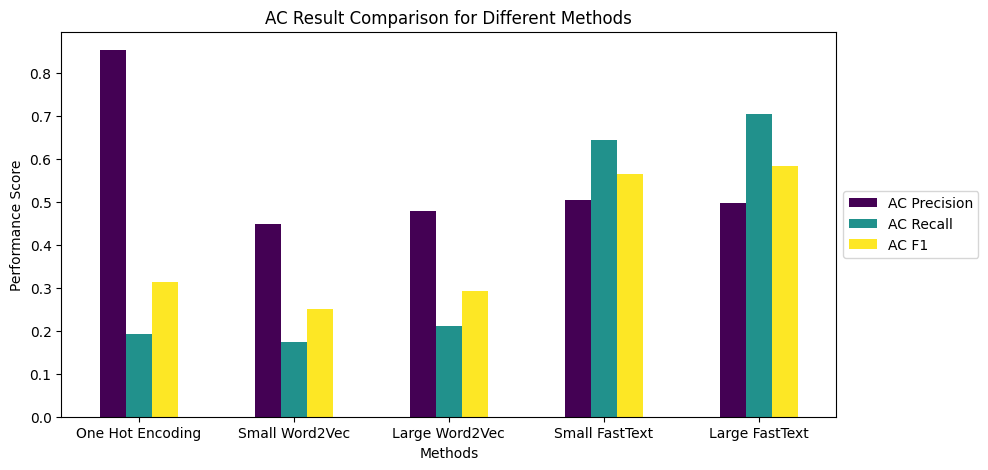

[0.022727272727272728, 0.0, 0.028846153846153848, 0.0, 0.0]
+------------------+----------------+-------------+-----------+
|                  |   LF Precision |   LF Recall |     LF F1 |
|------------------+----------------+-------------+-----------|
| One Hot Encoding |      0.0227273 |   0.0131579 | 0.0166667 |
| Small Word2Vec   |      0         |   0         | 0         |
| Large Word2Vec   |      0.0288462 |   0.0197368 | 0.0234375 |
| Small FastText   |      0         |   0         | 0         |
| Large FastText   |      0         |   0         | 0         |
+------------------+----------------+-------------+-----------+


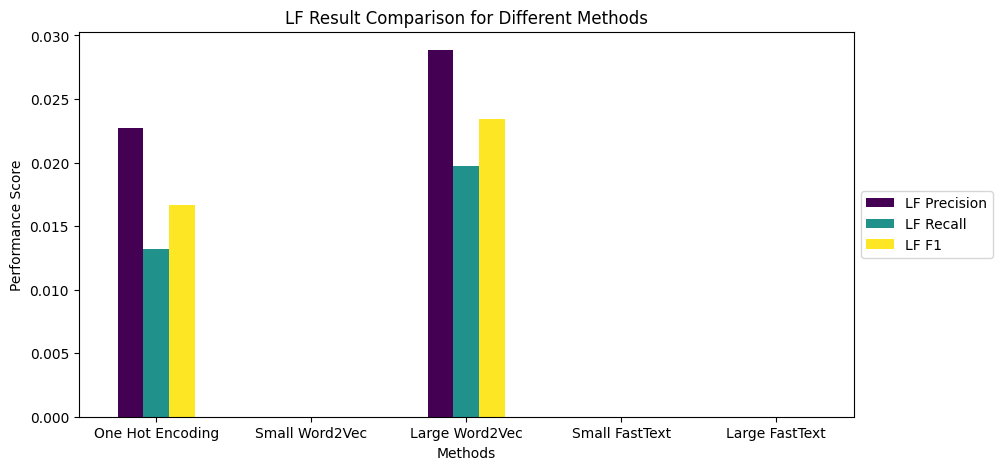

[0.8763418662262593, 0.873905794080867, 0.8783557046979866, 0.8893220706086203, 0.893640350877193]
+------------------+---------------+------------+----------+
|                  |   O Precision |   O Recall |     O F1 |
|------------------+---------------+------------+----------|
| One Hot Encoding |      0.876342 |   0.989049 | 0.929291 |
| Small Word2Vec   |      0.873906 |   0.976934 | 0.922552 |
| Large Word2Vec   |      0.878356 |   0.975769 | 0.924503 |
| Small FastText   |      0.889322 |   0.956664 | 0.921765 |
| Large FastText   |      0.89364  |   0.949441 | 0.920696 |
+------------------+---------------+------------+----------+


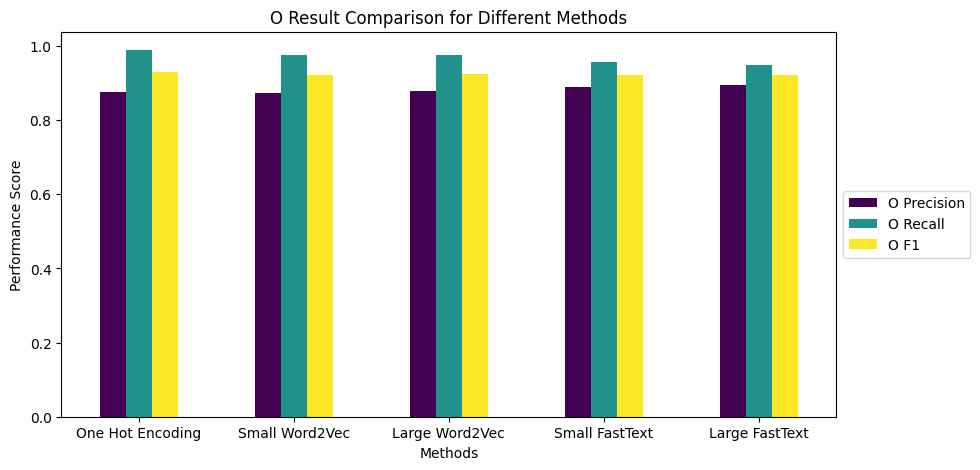

In [201]:
names = ['One Hot Encoding', 'Small Word2Vec', 'Large Word2Vec', 'Small FastText', 'Large FastText']
methods = [ohe_results, small_w2v_results, large_w2v_results, small_ft_results, large_ft_results]
plot_comparison(methods, names, 'AC')
plot_comparison(methods, names, 'LF')
plot_comparison(methods, names, 'O')

# Test 4. RoBERTa vectorization

In [4]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}
label_list = []
for sample in datasets["train"]["ner_tags"]:
    label_list.append([label_encoding[tag] for tag in sample])

val_label_list = []
for sample in datasets["validation"]["ner_tags"]:
    val_label_list.append([label_encoding[tag] for tag in sample])

test_label_list = []
for sample in datasets["test"]["ner_tags"]:
    test_label_list.append([label_encoding[tag] for tag in sample])

For RoBERTa model, there will be a specific pretrained tokenizer. This tokenizer splits tokens into substokens. So it will need to be realigned with its labels.

In [5]:
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
import transformers


model_checkpoint = "surrey-nlp/roberta-large-finetuned-abbr"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

label_all_tokens = True
#Tokenization code obtained from https://github.com/surrey-nlp/NLP-2024/blob/main/lab06/BERT-finetuning.ipynb 
def tokenize_and_align_labels(short_dataset, list_name):
    tokenized_inputs = tokenizer(short_dataset["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(list_name):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = tokenize_and_align_labels(datasets["train"], label_list)
tokenized_val_datasets = tokenize_and_align_labels(datasets["validation"], val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(datasets["test"], test_label_list)


With the dataset tokenized, the model will then be initialized. Then, it is important to remove the RoBERTa model's classifier layer so that its embeddings can be obtained. To do this, the classifier model will be replaced with an Identity function.

In [6]:
model_checkpoint = "surrey-nlp/roberta-large-finetuned-abbr"
#Initialize the model with the pretrained model check point
RobBERTa_model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=5)

#Set the classifier to Identity to get the word embeddings
RobBERTa_model.classifier = torch.nn.Identity()


train_vec_tokens = [RobBERTa_model(torch.tensor(row).unsqueeze(0)).logits.detach().squeeze().numpy() for row in tokenized_datasets['input_ids']]
test_vec_tokens = [RobBERTa_model(torch.tensor(row).unsqueeze(0)).logits.detach().squeeze().numpy() for row in tokenized_test_datasets['input_ids']]


In [7]:
reverse_label_encoding = {0: "B-O", 1: "B-AC", 2: "B-LF", 3: "I-LF", -100: "Unknown"}
flatten_train_vec_tokens = [item for sublist in train_vec_tokens for item in sublist]
flatten_test_vec_tokens = [item for sublist in test_vec_tokens for item in sublist]
flatten_train_labels = [reverse_label_encoding[item] for sublist in tokenized_datasets['labels'] for item in sublist]
flatten_test_labels = [reverse_label_encoding[item] for sublist in tokenized_test_datasets['labels'] for item in sublist]

def remove_unknown_tokens(tokens, labels):
    new_tokens, new_labels = [], []
    for token,label in zip(tokens,labels):
        if label != 'Unknown':
            new_tokens.append(token)
            new_labels.append(label)
    return new_tokens, new_labels

flatten_train_vec_tokens, flatten_train_labels = remove_unknown_tokens(flatten_train_vec_tokens, flatten_train_labels)
flatten_test_vec_tokens, flatten_test_labels = remove_unknown_tokens(flatten_test_vec_tokens, flatten_test_labels)

c:\Users\Jian He\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution Time: 64.19 seconds

Classification Report

              precision    recall  f1-score   support

        B-AC       0.94      0.93      0.94       559
        B-LF       0.95      0.95      0.95       288
         B-O       0.99      0.99      0.99      5274
        I-LF       0.93      0.99      0.96       389

    accuracy                           0.98      6510
   macro avg       0.96      0.96      0.96      6510
weighted avg       0.98      0.98      0.98      6510

+----+-------------+----------+----------+----------+
|    |   precision |   recall |       f1 |   number |
|----+-------------+----------+----------+----------|
| AC |    0.942134 | 0.932021 | 0.93705  |      559 |
| LF |    0.922297 | 0.941379 | 0.931741 |      290 |
| O  |    0.98954  | 0.986538 | 0.988036 |     5274 |
+----+-------------+----------+----------+----------+
+-------------------+----------+
| Overall Precision | 0.981988 |
| Overall Recall    | 0.979422 |
| Overall F1        | 0.980703 |
|

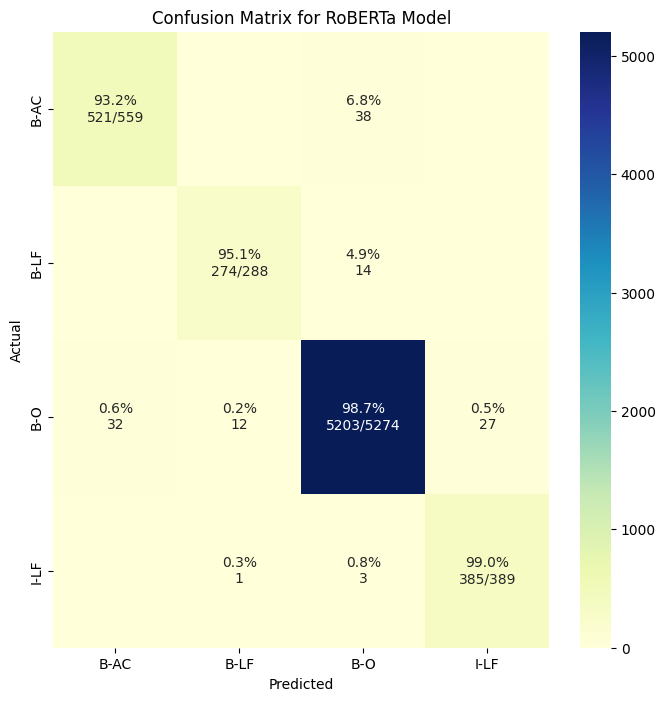

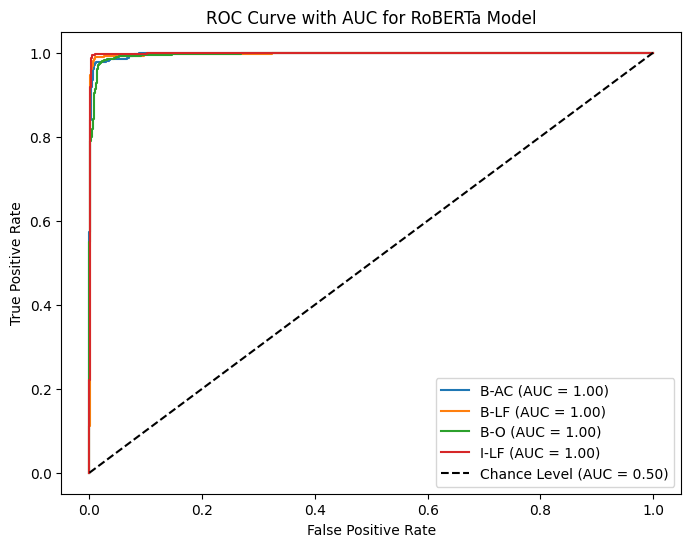

In [698]:
roberta_results = train_and_eval(flatten_train_vec_tokens, flatten_test_vec_tokens, flatten_train_labels, flatten_test_labels, 'RoBERTa Model')

# Compare all 4 Tests

+------------------+---------------------+------------------+--------------+--------------------+
|                  |   Overall Precision |   Overall Recall |   Overall F1 |   Overall Accuracy |
|------------------+---------------------+------------------+--------------+--------------------|
| One Hot Encoding |            0.861005 |         0.911964 |     0.885753 |           0.8694   |
| Small Word2Vec   |            0.848849 |         0.899448 |     0.873416 |           0.8554   |
| Large Word2Vec   |            0.851132 |         0.901146 |     0.875425 |           0.859    |
| Small FastText   |            0.856171 |         0.907934 |     0.881293 |           0.8594   |
| Large FastText   |            0.853512 |         0.904752 |     0.878385 |           0.8572   |
| RoBERTa Model    |            0.981988 |         0.979422 |     0.980703 |           0.980492 |
+------------------+---------------------+------------------+--------------+--------------------+


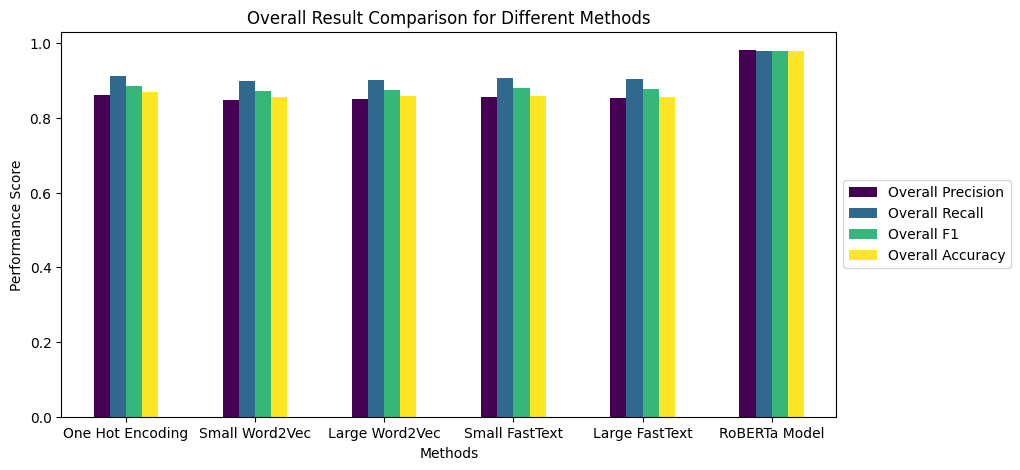

[0.8524590163934426, 0.44761904761904764, 0.4789915966386555, 0.5028901734104047, 0.4973821989528796, 0.9421338155515371]
+------------------+----------------+-------------+----------+
|                  |   AC Precision |   AC Recall |    AC F1 |
|------------------+----------------+-------------+----------|
| One Hot Encoding |       0.852459 |    0.192593 | 0.314199 |
| Small Word2Vec   |       0.447619 |    0.174074 | 0.250667 |
| Large Word2Vec   |       0.478992 |    0.211111 | 0.293059 |
| Small FastText   |       0.50289  |    0.644444 | 0.564935 |
| Large FastText   |       0.497382 |    0.703704 | 0.582822 |
| RoBERTa Model    |       0.942134 |    0.932021 | 0.93705  |
+------------------+----------------+-------------+----------+


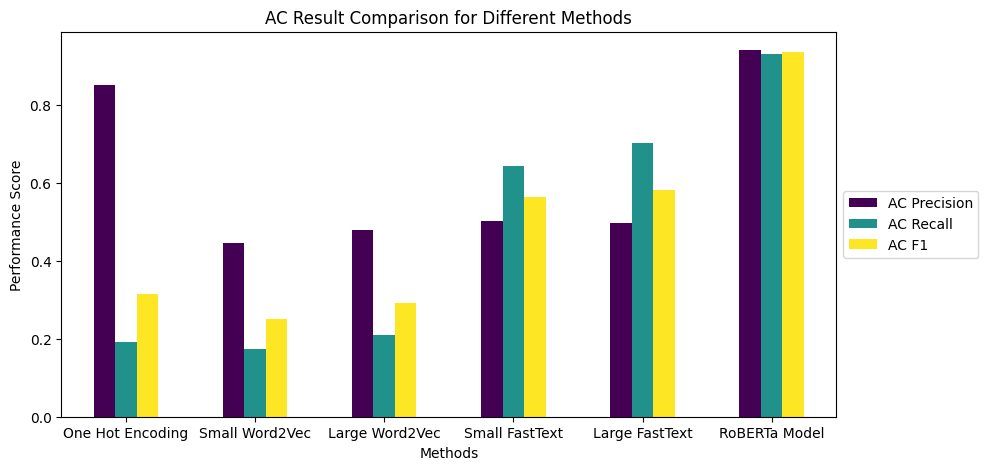

[0.022727272727272728, 0.0, 0.028846153846153848, 0.0, 0.0, 0.9222972972972973]
+------------------+----------------+-------------+-----------+
|                  |   LF Precision |   LF Recall |     LF F1 |
|------------------+----------------+-------------+-----------|
| One Hot Encoding |      0.0227273 |   0.0131579 | 0.0166667 |
| Small Word2Vec   |      0         |   0         | 0         |
| Large Word2Vec   |      0.0288462 |   0.0197368 | 0.0234375 |
| Small FastText   |      0         |   0         | 0         |
| Large FastText   |      0         |   0         | 0         |
| RoBERTa Model    |      0.922297  |   0.941379  | 0.931741  |
+------------------+----------------+-------------+-----------+


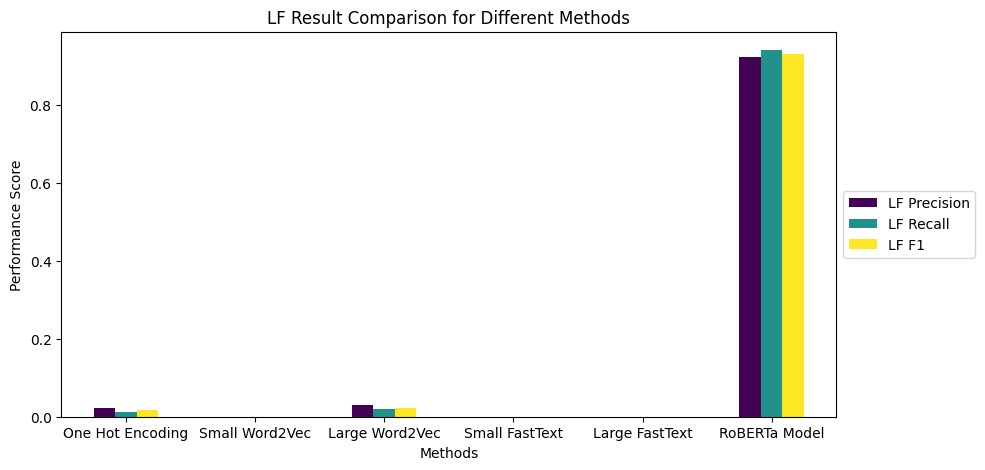

[0.8763418662262593, 0.873905794080867, 0.8783557046979866, 0.8893220706086203, 0.893640350877193, 0.9895397489539749]
+------------------+---------------+------------+----------+
|                  |   O Precision |   O Recall |     O F1 |
|------------------+---------------+------------+----------|
| One Hot Encoding |      0.876342 |   0.989049 | 0.929291 |
| Small Word2Vec   |      0.873906 |   0.976934 | 0.922552 |
| Large Word2Vec   |      0.878356 |   0.975769 | 0.924503 |
| Small FastText   |      0.889322 |   0.956664 | 0.921765 |
| Large FastText   |      0.89364  |   0.949441 | 0.920696 |
| RoBERTa Model    |      0.98954  |   0.986538 | 0.988036 |
+------------------+---------------+------------+----------+


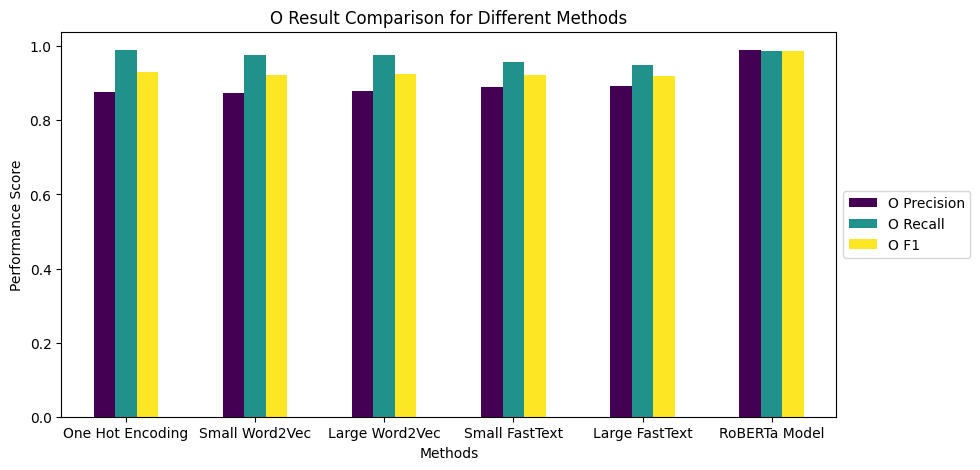

In [699]:
methods = [ohe_results, small_w2v_results, large_w2v_results, small_ft_results, large_ft_results, roberta_results]
Names = ['One Hot Encoding', 'Small Word2Vec', 'Large Word2Vec', 'Small FastText', 'Large FastText', 'RoBERTa Model']
plot_overall_comparison(methods, Names)
plot_comparison(methods, Names, 'AC')
plot_comparison(methods, Names, 'LF')
plot_comparison(methods, Names, 'O')

## 2.2. Experiment II: NLP Algorithm

Test 1. Logistic Regression

Test 2. Simple Artificial Neural Network

Test 3. Recurrent Neural Network

Test 4. LSTM

After determining the pretrained RoBERTa as the best, it will be used in Experiment 2 to determine the best NLP Algorithm.

# Test 1. Logistic Regression

The code for Logistic Regression from Experiment 1 will serve as a Baseline of Comparison between the different Algorithms.

c:\Users\Jian He\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution Time: 61.96 seconds

Classification Report

              precision    recall  f1-score   support

        B-AC       0.94      0.93      0.94       559
        B-LF       0.95      0.95      0.95       288
         B-O       0.99      0.99      0.99      5274
        I-LF       0.93      0.99      0.96       389

    accuracy                           0.98      6510
   macro avg       0.96      0.96      0.96      6510
weighted avg       0.98      0.98      0.98      6510

+----+-------------+----------+----------+----------+
|    |   precision |   recall |       f1 |   number |
|----+-------------+----------+----------+----------|
| AC |    0.942134 | 0.932021 | 0.93705  |      559 |
| LF |    0.922297 | 0.941379 | 0.931741 |      290 |
| O  |    0.98954  | 0.986538 | 0.988036 |     5274 |
+----+-------------+----------+----------+----------+
+-------------------+----------+
| Overall Precision | 0.981988 |
| Overall Recall    | 0.979422 |
| Overall F1        | 0.980703 |
|

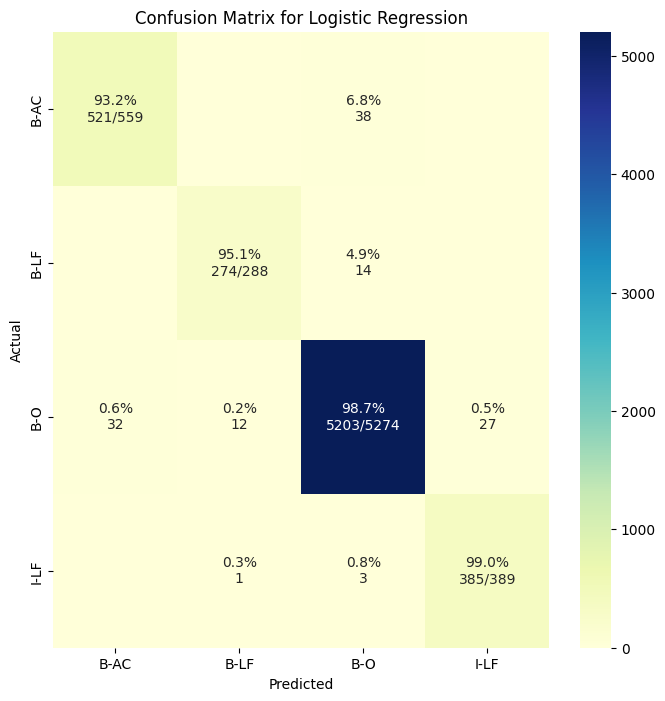

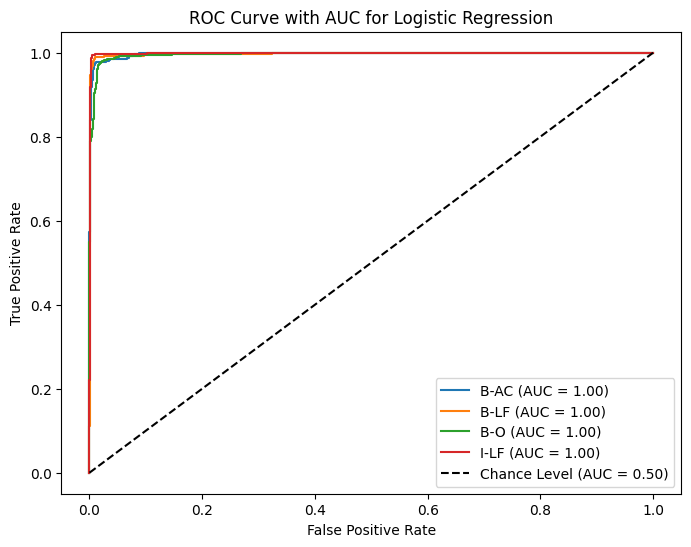

In [15]:
import pickle
LR_results = train_and_eval(flatten_train_vec_tokens, flatten_test_vec_tokens, flatten_train_labels, flatten_test_labels, 'Logistic Regression')


# Test 2. Simple Artificial Neural Network

To implement the word embeddings for the ANN, we have to retokenize and revectorize our data because it needs to be in Tensor form.

In [701]:
import torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

#Here, the model will be initialized and the classifier will be removed
RobBERTa_model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=5)
RobBERTa_model.classifier = torch.nn.Identity()

#Get word embeddings for all datasets. Here, we will not need to use numpy(), so everything is in Tensor form.
train_tokens_tensor = [RobBERTa_model(torch.tensor(row).unsqueeze(0)).logits.detach().squeeze() for row in tokenized_datasets['input_ids']]
val_tokens_tensor = [RobBERTa_model(torch.tensor(row).unsqueeze(0)).logits.detach().squeeze() for row in tokenized_val_datasets['input_ids']]
test_tokens_tensor = [RobBERTa_model(torch.tensor(row).unsqueeze(0)).logits.detach().squeeze() for row in tokenized_test_datasets['input_ids']]

In [702]:
flatten_train_tensor = [item for sublist in train_tokens_tensor for item in sublist]
flatten_val_vec_tensor = [item for sublist in val_tokens_tensor for item in sublist]
flatten_test_vec_tensor = [item for sublist in test_tokens_tensor for item in sublist]

flatten_train = [item for sublist in tokenized_datasets['labels'] for item in sublist]
flatten_val = [item for sublist in tokenized_val_datasets['labels'] for item in sublist]
flatten_test = [item for sublist in tokenized_test_datasets['labels'] for item in sublist]

#Load the data in (token,label) pair, but omit the -100 (Unknown) labels
train_data = [(tokens, labels) for tokens, labels in zip(flatten_train_tensor, flatten_train) if labels != -100]
val_data = [(tokens, labels) for tokens, labels in zip(flatten_val_vec_tensor, flatten_val) if labels != -100]
test_data = [(tokens, labels) for tokens, labels in zip(flatten_test_vec_tensor, flatten_test) if labels != -100]

Before performing training, several functions will need to be created to train the neural networks.

In [783]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os.path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Create a Train and Eval Loop
@timing_decorator
def train_NN(model, train_data, val_data,  learning_rate = 0.001, epochs=10, batch_size=32, identifier='model'):
    #Set the seed for reproducibility
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
    #Setup optimizer and loss
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    result_dict = {'Epoch':[], 'Train Loss':[], 'Train Accuracy':[], 'Validation Loss':[], 'Validation Accuracy':[]}
    model.to(device)
    for epoch in range(epochs):
        train_loss = 0.0
        train_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0
        model.train()
        #Train the model
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += ((outputs.argmax(1) == labels).sum().item())/len(labels)
        print(f"Epoch: {epoch} | Training Loss: {train_loss/len(train_loader):.4f}   | Training Accuracy: {train_accuracy/len(train_loader):.4f}")
        model.eval()
        #Validate the model
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += ((outputs.argmax(1) == labels).sum().item())/len(labels)
        print(f"Epoch: {epoch} | Validation Loss: {val_loss/len(val_loader):.4f} | Validation Accuracy: {val_accuracy/len(val_loader):.4f}")    
        result_dict['Epoch'].append(epoch)
        result_dict['Train Loss'].append(train_loss/len(train_loader)); result_dict['Train Accuracy'].append(train_accuracy/len(train_loader))
        result_dict['Validation Loss'].append(val_loss/len(val_loader)); result_dict['Validation Accuracy'].append(val_accuracy/len(val_loader))
        if epoch == epochs-1:
            save_dir = f'./{identifier}_lr{learning_rate}_epochs{epochs}_batch{batch_size}'
            torch.save(obj=model.state_dict(),f=save_dir)
            print(f'Model Saved to Path {save_dir}')
    df = pd.DataFrame(result_dict)
    ax1 = df.plot(x='Epoch', y=['Train Loss', 'Validation Loss'], figsize=(10, 5))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax2 = df.plot(x='Epoch', y=['Train Accuracy', 'Validation Accuracy'], figsize=(10, 5))
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    print("Finished Training")
    return model

#Create a function to perform all result calculations and visualizations
def get_test_results(model,data,name):
    reverse_label_encoding = {0: "B-O", 1: "B-AC", 2: "B-LF", 3: "I-LF"}
    roc_encoding = {0: "B-AC", 1: "B-LF", 2: "B-O", 3: "I-LF"}
    model.to(device)
    model.eval()
    predictions_list = []
    proba_list = []
    labels_list = []
    for i, data in enumerate(data, 0):
        inputs, labels = data
        outputs = model(inputs.unsqueeze(0))
        predictions_list.append(outputs.argmax().item())
        proba_list.append(nn.functional.one_hot(outputs.argmax(), num_classes=4).detach().numpy().tolist())
        labels_list.append(labels)
    results = calculate_results([reverse_label_encoding[label] for label in labels_list], [reverse_label_encoding[label] for label in predictions_list])
    plot_cm([reverse_label_encoding[label] for label in labels_list], [reverse_label_encoding[label] for label in predictions_list], name)
    plot_roc([roc_encoding[label] for label in labels_list], np.array(proba_list), name)
    return results

With the helper functions created, we can now initialize the ANN.

In [604]:
#Create a simple 3-layer neural network model
class Simple_NN(nn.Module):
    def __init__(self, input_dim, output_dim = 4, hidden_dim=512):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.network(x)

#Initialize the model with input dimension of 1024 to match the RoBERTa word embedding
Simple_NN_model = Simple_NN(1024)

Epoch: 0 | Training Loss: 0.0620   | Training Accuracy: 0.9839
Epoch: 0 | Validation Loss: 0.0854 | Validation Accuracy: 0.9833
Epoch: 1 | Training Loss: 0.0502   | Training Accuracy: 0.9844
Epoch: 1 | Validation Loss: 0.0931 | Validation Accuracy: 0.9831
Epoch: 2 | Training Loss: 0.0528   | Training Accuracy: 0.9846
Epoch: 2 | Validation Loss: 0.0832 | Validation Accuracy: 0.9827
Epoch: 3 | Training Loss: 0.0507   | Training Accuracy: 0.9847
Epoch: 3 | Validation Loss: 0.0760 | Validation Accuracy: 0.9825
Epoch: 4 | Training Loss: 0.0499   | Training Accuracy: 0.9841
Epoch: 4 | Validation Loss: 0.0796 | Validation Accuracy: 0.9824
Epoch: 5 | Training Loss: 0.0501   | Training Accuracy: 0.9842
Epoch: 5 | Validation Loss: 0.0689 | Validation Accuracy: 0.9830
Epoch: 6 | Training Loss: 0.0492   | Training Accuracy: 0.9846
Epoch: 6 | Validation Loss: 0.0749 | Validation Accuracy: 0.9813
Epoch: 7 | Training Loss: 0.0474   | Training Accuracy: 0.9846
Epoch: 7 | Validation Loss: 0.0723 | Vali

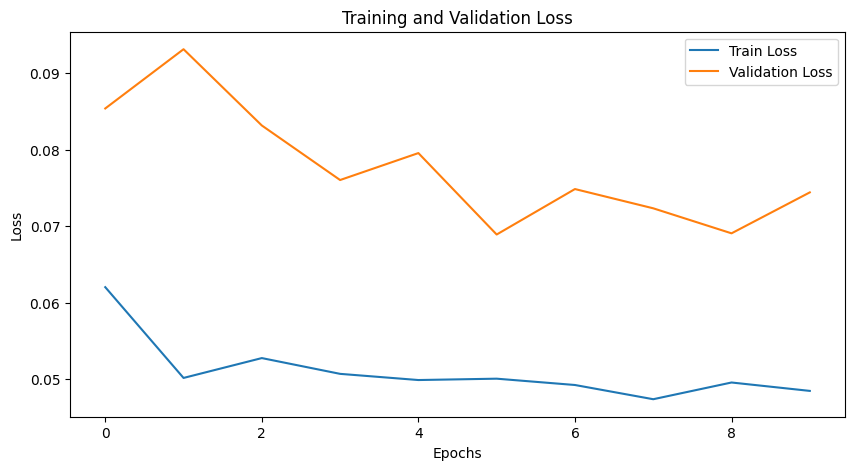

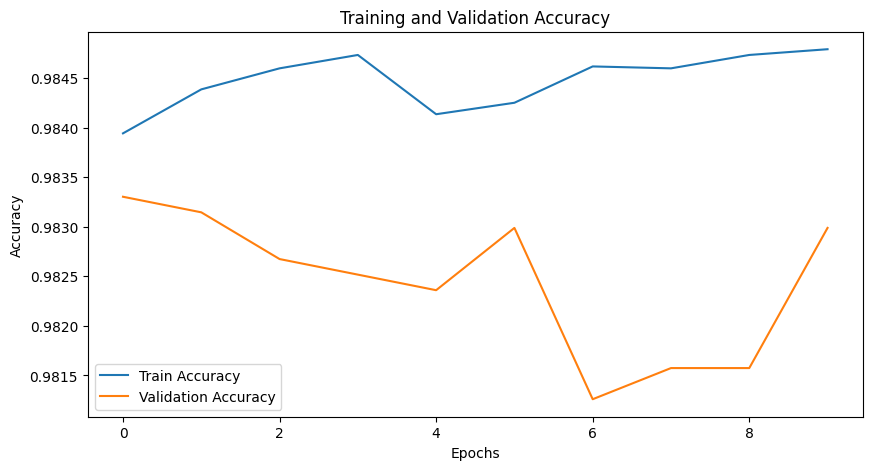

In [713]:
ANN_model = train_NN(Simple_NN_model, train_data, val_data, learning_rate=0.001, epochs=10, batch_size=32)


Classification Report

              precision    recall  f1-score   support

        B-AC       0.95      0.94      0.95       559
        B-LF       0.96      0.95      0.95       288
         B-O       0.99      0.99      0.99      5274
        I-LF       0.94      0.99      0.97       389

    accuracy                           0.98      6510
   macro avg       0.96      0.97      0.96      6510
weighted avg       0.98      0.98      0.98      6510

+----+-------------+----------+----------+----------+
|    |   precision |   recall |       f1 |   number |
|----+-------------+----------+----------+----------|
| AC |    0.947842 | 0.942755 | 0.945291 |      559 |
| LF |    0.922297 | 0.941379 | 0.931741 |      290 |
| O  |    0.991056 | 0.987486 | 0.989268 |     5274 |
+----+-------------+----------+----------+----------+
+-------------------+----------+
| Overall Precision | 0.983789 |
| Overall Recall    | 0.981218 |
| Overall F1        | 0.982502 |
| Overall Accuracy  | 0.982488 

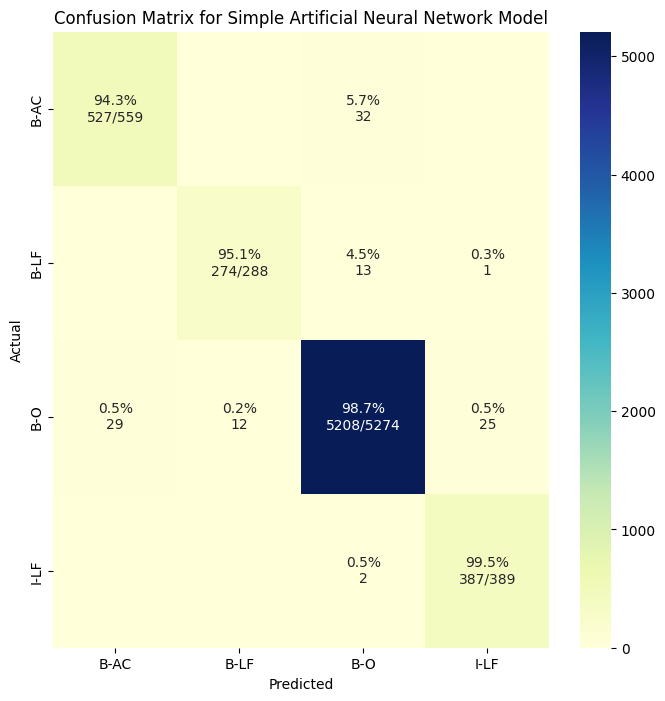

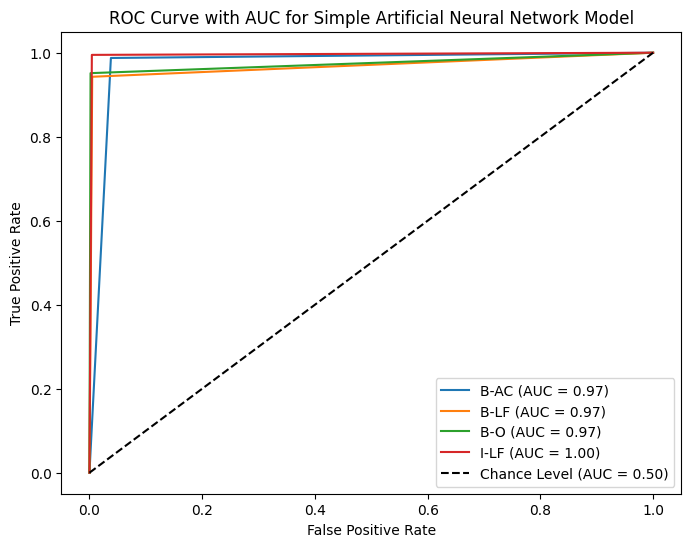

In [714]:
ANN_results = get_test_results(ANN_model, test_data, 'Simple Artificial Neural Network Model')

# Test 3. Recurrent Neural Network

Here, a simple RNN model is initialized.

In [624]:
#Create a Recurrent Neural Network Model
class RNN(nn.Module):
    def __init__(self, input_dim, num_layers = 3, output_dim = 4, hidden_dim=512):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x, hidden = self.rnn(x)
        x = self.fc(x)
        return x

#Initialize the RNN model with 1024 input dimensions to match the 1024 word embedding dimension
RNN_model = RNN(1024)

Epoch: 0 | Training Loss: 0.0668   | Training Accuracy: 0.9818
Epoch: 0 | Validation Loss: 0.0660 | Validation Accuracy: 0.9825
Epoch: 1 | Training Loss: 0.0664   | Training Accuracy: 0.9817
Epoch: 1 | Validation Loss: 0.0711 | Validation Accuracy: 0.9806
Epoch: 2 | Training Loss: 0.0687   | Training Accuracy: 0.9813
Epoch: 2 | Validation Loss: 0.0710 | Validation Accuracy: 0.9813
Epoch: 3 | Training Loss: 0.0669   | Training Accuracy: 0.9803
Epoch: 3 | Validation Loss: 0.0732 | Validation Accuracy: 0.9809
Epoch: 4 | Training Loss: 0.0657   | Training Accuracy: 0.9821
Epoch: 4 | Validation Loss: 0.0701 | Validation Accuracy: 0.9803
Epoch: 5 | Training Loss: 0.0684   | Training Accuracy: 0.9809
Epoch: 5 | Validation Loss: 0.0777 | Validation Accuracy: 0.9797
Epoch: 6 | Training Loss: 0.0746   | Training Accuracy: 0.9802
Epoch: 6 | Validation Loss: 0.0783 | Validation Accuracy: 0.9808
Epoch: 7 | Training Loss: 0.0707   | Training Accuracy: 0.9809
Epoch: 7 | Validation Loss: 0.0699 | Vali

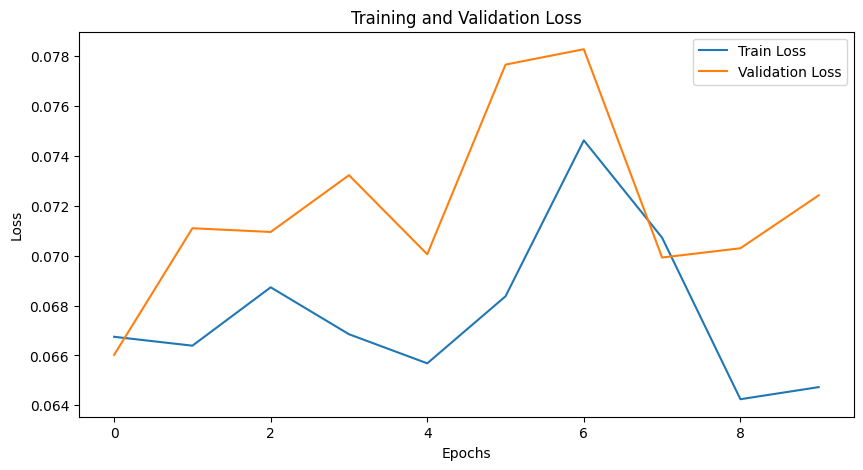

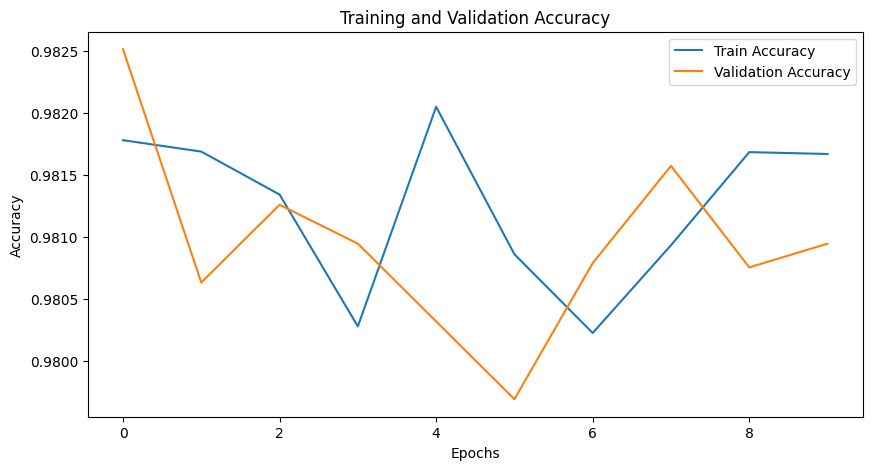

In [715]:
RNN_trained_model = train_NN(RNN_model, train_data, val_data, learning_rate=0.001, epochs=10, batch_size=32)


Classification Report

              precision    recall  f1-score   support

        B-AC       0.95      0.93      0.94       559
        B-LF       0.95      0.96      0.96       288
         B-O       0.99      0.99      0.99      5274
        I-LF       0.94      1.00      0.97       389

    accuracy                           0.98      6510
   macro avg       0.96      0.97      0.96      6510
weighted avg       0.98      0.98      0.98      6510

+----+-------------+----------+----------+----------+
|    |   precision |   recall |       f1 |   number |
|----+-------------+----------+----------+----------|
| AC |    0.952468 | 0.932021 | 0.942134 |      559 |
| LF |    0.92953  | 0.955172 | 0.942177 |      290 |
| O  |    0.990679 | 0.987486 | 0.98908  |     5274 |
+----+-------------+----------+----------+----------+
+-------------------+----------+
| Overall Precision | 0.984267 |
| Overall Recall    | 0.980892 |
| Overall F1        | 0.982577 |
| Overall Accuracy  | 0.982181 

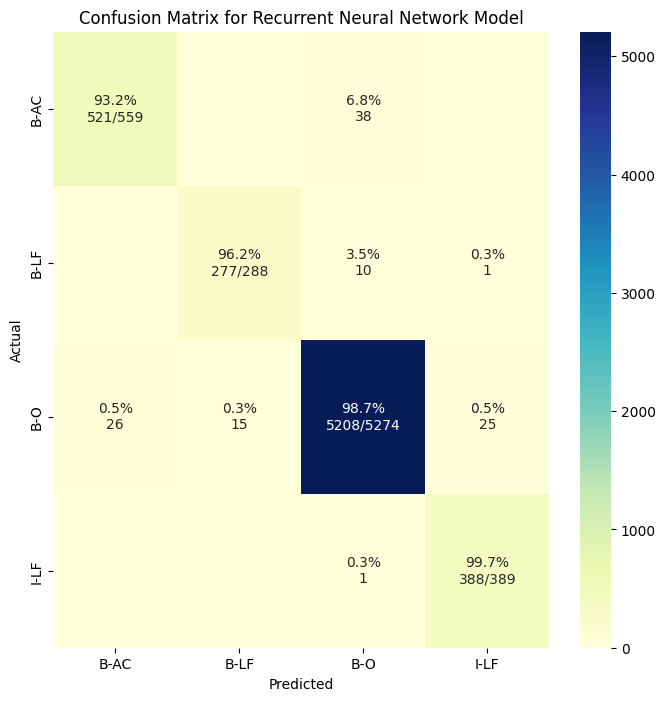

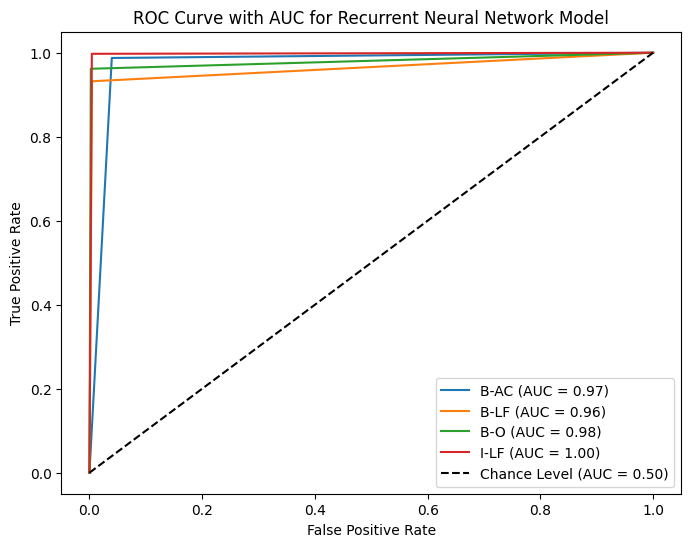

In [716]:
RNN_results = get_test_results(RNN_model, test_data, 'Recurrent Neural Network Model')



# Test 4. LSTM

Here, a simple LSTM model is initialized.

In [627]:
#Create a Long Short Term Memory Model
class LSTM(nn.Module):
    def __init__(self, input_dim, num_layers = 3, output_dim = 4, hidden_dim=512):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

#Initialize the LSTM model with 1024 input dimensions to match the 1024 word embedding
LSTM_model = LSTM(1024)

Epoch: 0 | Training Loss: 0.0635   | Training Accuracy: 0.9819
Epoch: 0 | Validation Loss: 0.0618 | Validation Accuracy: 0.9811
Epoch: 1 | Training Loss: 0.0607   | Training Accuracy: 0.9824
Epoch: 1 | Validation Loss: 0.0639 | Validation Accuracy: 0.9808
Epoch: 2 | Training Loss: 0.0592   | Training Accuracy: 0.9829
Epoch: 2 | Validation Loss: 0.0630 | Validation Accuracy: 0.9827
Epoch: 3 | Training Loss: 0.0574   | Training Accuracy: 0.9833
Epoch: 3 | Validation Loss: 0.0641 | Validation Accuracy: 0.9817
Epoch: 4 | Training Loss: 0.0578   | Training Accuracy: 0.9831
Epoch: 4 | Validation Loss: 0.0614 | Validation Accuracy: 0.9828
Epoch: 5 | Training Loss: 0.0540   | Training Accuracy: 0.9844
Epoch: 5 | Validation Loss: 0.0610 | Validation Accuracy: 0.9830
Epoch: 6 | Training Loss: 0.0524   | Training Accuracy: 0.9844
Epoch: 6 | Validation Loss: 0.0630 | Validation Accuracy: 0.9819
Epoch: 7 | Training Loss: 0.0514   | Training Accuracy: 0.9847
Epoch: 7 | Validation Loss: 0.0622 | Vali

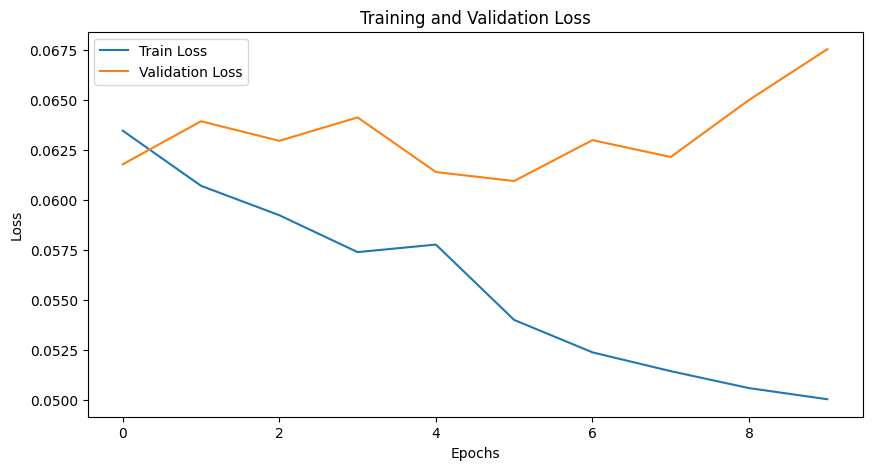

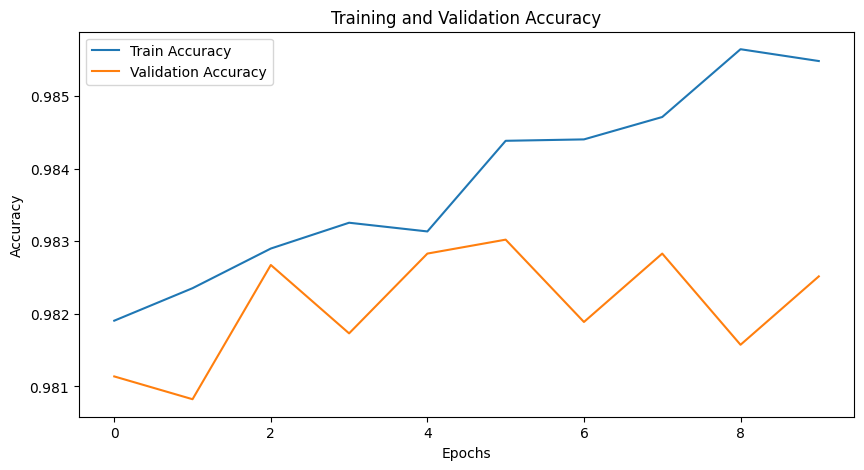

In [717]:
LSTM_trained_model = train_NN(LSTM_model, train_data, val_data, learning_rate=0.001, epochs=10, batch_size=32)


Classification Report

              precision    recall  f1-score   support

        B-AC       0.95      0.93      0.94       559
        B-LF       0.94      0.94      0.94       288
         B-O       0.99      0.99      0.99      5274
        I-LF       0.93      1.00      0.96       389

    accuracy                           0.98      6510
   macro avg       0.95      0.96      0.96      6510
weighted avg       0.98      0.98      0.98      6510

+----+-------------+----------+----------+----------+
|    |   precision |   recall |       f1 |   number |
|----+-------------+----------+----------+----------|
| AC |    0.952294 | 0.928444 | 0.940217 |      559 |
| LF |    0.912162 | 0.931034 | 0.921502 |      290 |
| O  |    0.989354 | 0.986727 | 0.988039 |     5274 |
+----+-------------+----------+----------+----------+
+-------------------+----------+
| Overall Precision | 0.982298 |
| Overall Recall    | 0.978769 |
| Overall F1        | 0.98053  |
| Overall Accuracy  | 0.980184 

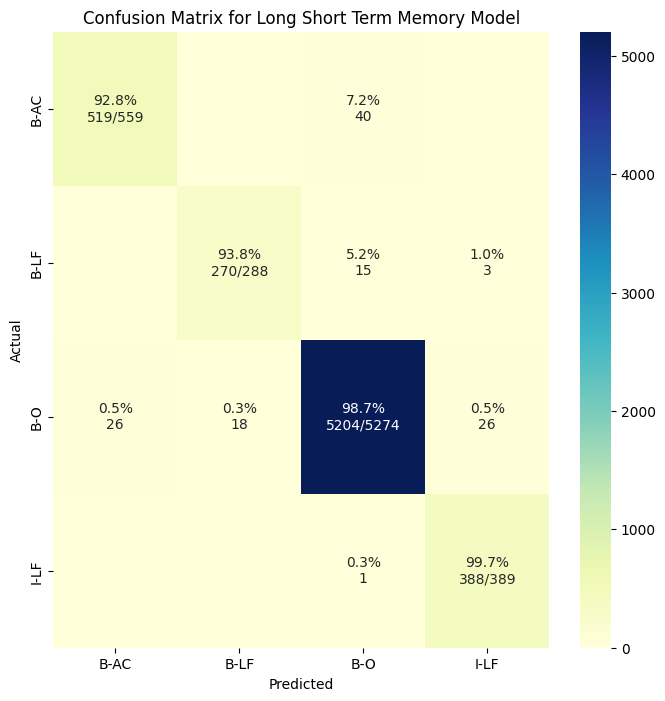

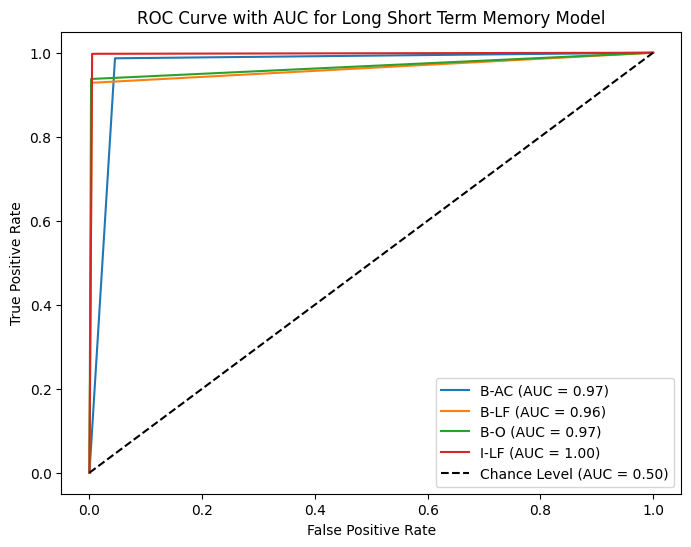

In [718]:
LSTM_results = get_test_results(LSTM_model, test_data, 'Long Short Term Memory Model')

# Compare Results of all Methods

+---------------------+---------------------+------------------+--------------+--------------------+
|                     |   Overall Precision |   Overall Recall |   Overall F1 |   Overall Accuracy |
|---------------------+---------------------+------------------+--------------+--------------------|
| Logistic Regression |            0.981988 |         0.979422 |     0.980703 |           0.980492 |
| Simple ANN          |            0.983789 |         0.981218 |     0.982502 |           0.982488 |
| RNN                 |            0.984267 |         0.980892 |     0.982577 |           0.982181 |
| LSTM                |            0.982298 |         0.978769 |     0.98053  |           0.980184 |
+---------------------+---------------------+------------------+--------------+--------------------+


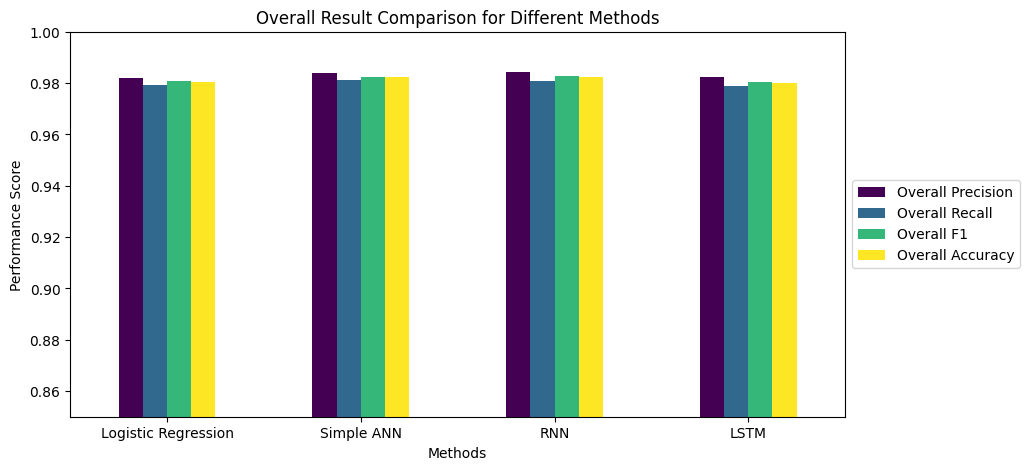

[0.9421338155515371, 0.947841726618705, 0.9524680073126143, 0.9522935779816514]
+---------------------+----------------+-------------+----------+
|                     |   AC Precision |   AC Recall |    AC F1 |
|---------------------+----------------+-------------+----------|
| Logistic Regression |       0.942134 |    0.932021 | 0.93705  |
| Simple ANN          |       0.947842 |    0.942755 | 0.945291 |
| RNN                 |       0.952468 |    0.932021 | 0.942134 |
| LSTM                |       0.952294 |    0.928444 | 0.940217 |
+---------------------+----------------+-------------+----------+


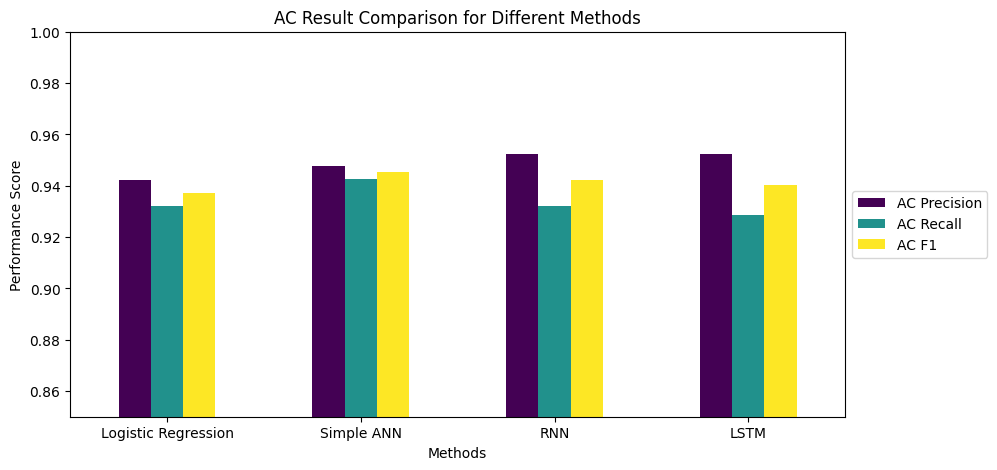

[0.9222972972972973, 0.9222972972972973, 0.9295302013422819, 0.9121621621621622]
+---------------------+----------------+-------------+----------+
|                     |   LF Precision |   LF Recall |    LF F1 |
|---------------------+----------------+-------------+----------|
| Logistic Regression |       0.922297 |    0.941379 | 0.931741 |
| Simple ANN          |       0.922297 |    0.941379 | 0.931741 |
| RNN                 |       0.92953  |    0.955172 | 0.942177 |
| LSTM                |       0.912162 |    0.931034 | 0.921502 |
+---------------------+----------------+-------------+----------+


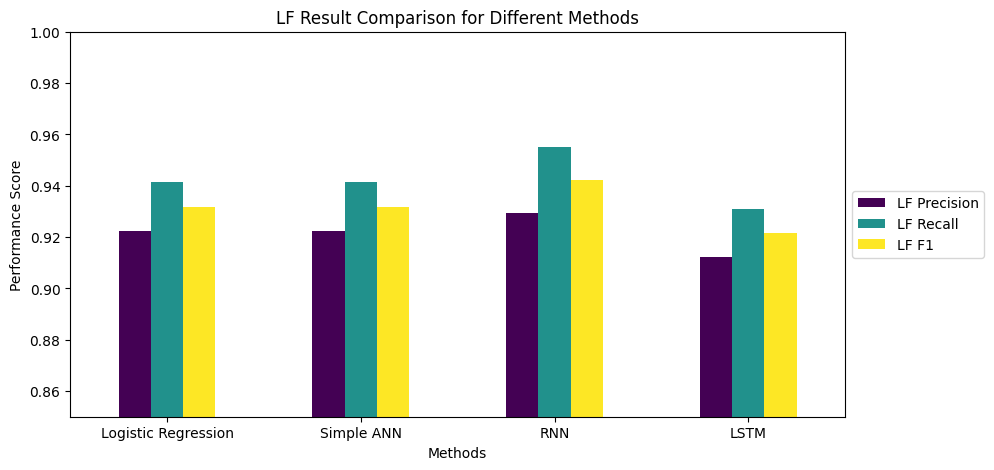

[0.9895397489539749, 0.9910561370123692, 0.9906790945406125, 0.9893536121673003]
+---------------------+---------------+------------+----------+
|                     |   O Precision |   O Recall |     O F1 |
|---------------------+---------------+------------+----------|
| Logistic Regression |      0.98954  |   0.986538 | 0.988036 |
| Simple ANN          |      0.991056 |   0.987486 | 0.989268 |
| RNN                 |      0.990679 |   0.987486 | 0.98908  |
| LSTM                |      0.989354 |   0.986727 | 0.988039 |
+---------------------+---------------+------------+----------+


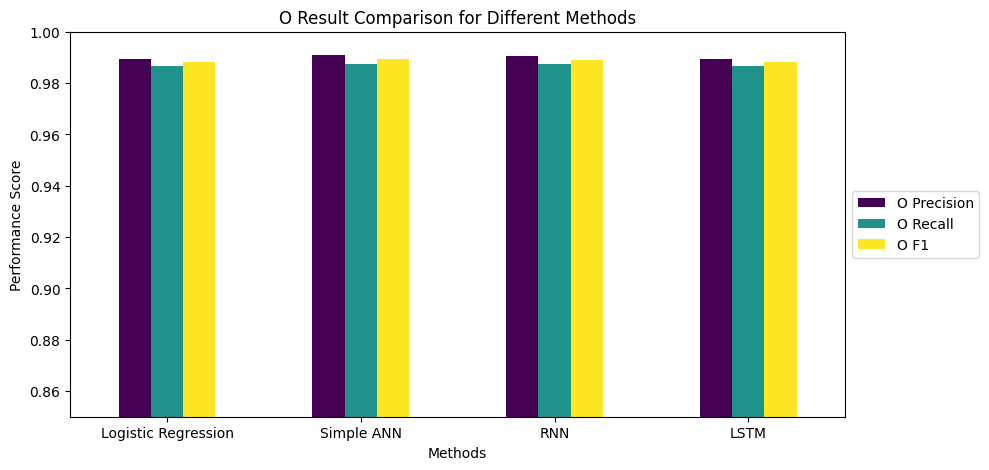

In [723]:
methods = [LR_results, ANN_results, RNN_results, LSTM_results]
names = ['Logistic Regression', 'Simple ANN', 'RNN', 'LSTM']
plot_overall_comparison(methods, names, ylim=(0.85,1))
plot_comparison(methods, names, 'AC', ylim=(0.85,1))
plot_comparison(methods, names, 'LF', ylim=(0.85,1))
plot_comparison(methods, names, 'O', ylim=(0.85,1))

## 2.3. Experiment III: Hyperparameter Optimisation
Test 1. Learning Rate

Test 2. Batch Size

Test 3. Epoch

Here, the hyperparameters will be tuned by iterating over a range of values in a list.

# Test 1. Learning Rate

Training for Learning Rate: 0.0001
Epoch: 0 | Training Loss: 0.0778   | Training Accuracy: 0.9772
Epoch: 0 | Validation Loss: 0.0662 | Validation Accuracy: 0.9808
Epoch: 1 | Training Loss: 0.0634   | Training Accuracy: 0.9818
Epoch: 1 | Validation Loss: 0.0654 | Validation Accuracy: 0.9811
Epoch: 2 | Training Loss: 0.0593   | Training Accuracy: 0.9824
Epoch: 2 | Validation Loss: 0.0637 | Validation Accuracy: 0.9807
Epoch: 3 | Training Loss: 0.0565   | Training Accuracy: 0.9828
Epoch: 3 | Validation Loss: 0.0615 | Validation Accuracy: 0.9799
Epoch: 4 | Training Loss: 0.0542   | Training Accuracy: 0.9835
Epoch: 4 | Validation Loss: 0.0595 | Validation Accuracy: 0.9824
Epoch: 5 | Training Loss: 0.0532   | Training Accuracy: 0.9837
Epoch: 5 | Validation Loss: 0.0575 | Validation Accuracy: 0.9824
Epoch: 6 | Training Loss: 0.0509   | Training Accuracy: 0.9845
Epoch: 6 | Validation Loss: 0.0581 | Validation Accuracy: 0.9827
Epoch: 7 | Training Loss: 0.0491   | Training Accuracy: 0.9847
Epoch:

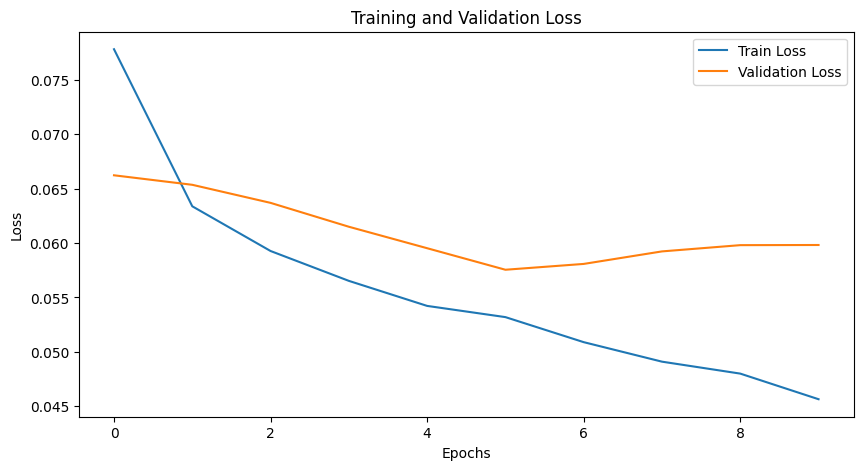

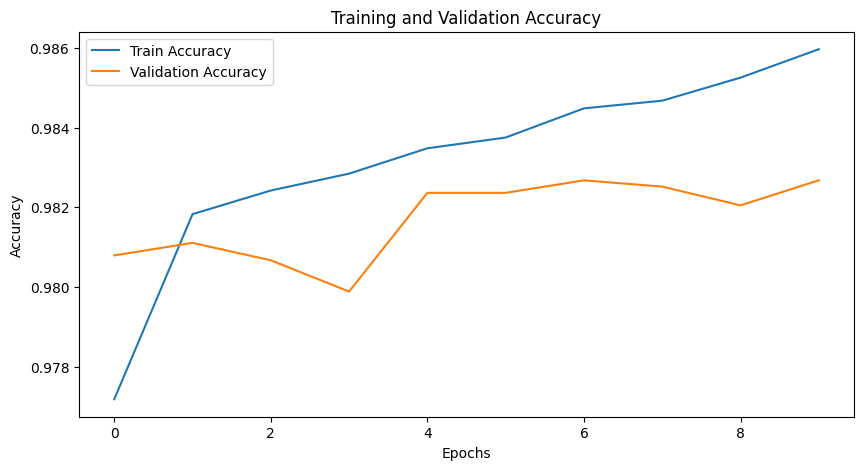

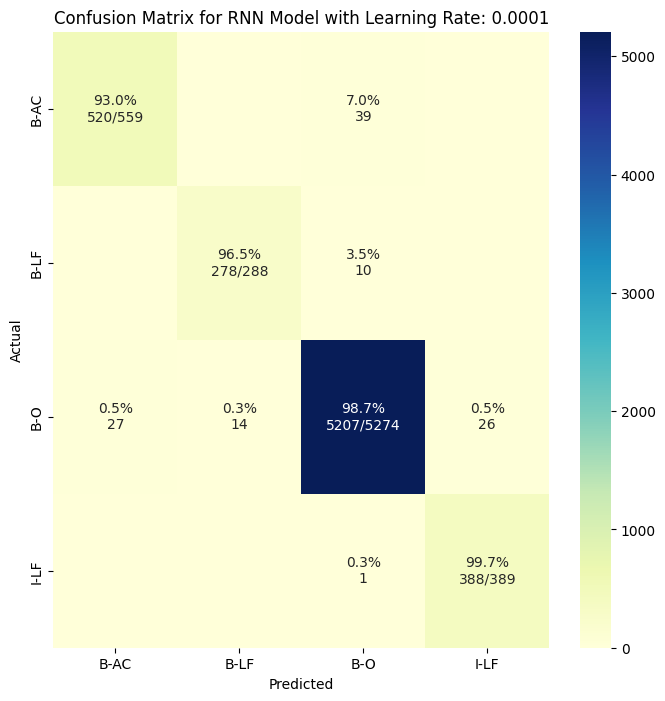

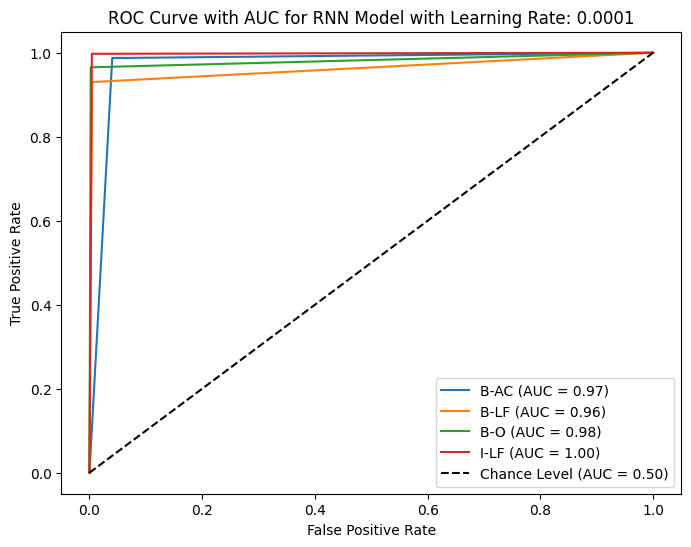

Training for Learning Rate: 0.0005
Epoch: 0 | Training Loss: 0.0983   | Training Accuracy: 0.9747
Epoch: 0 | Validation Loss: 0.0819 | Validation Accuracy: 0.9722
Epoch: 1 | Training Loss: 0.0795   | Training Accuracy: 0.9780
Epoch: 1 | Validation Loss: 0.0821 | Validation Accuracy: 0.9758
Epoch: 2 | Training Loss: 0.0732   | Training Accuracy: 0.9800
Epoch: 2 | Validation Loss: 0.0730 | Validation Accuracy: 0.9785
Epoch: 3 | Training Loss: 0.0703   | Training Accuracy: 0.9801
Epoch: 3 | Validation Loss: 0.0690 | Validation Accuracy: 0.9800
Epoch: 4 | Training Loss: 0.0678   | Training Accuracy: 0.9812
Epoch: 4 | Validation Loss: 0.0677 | Validation Accuracy: 0.9809
Epoch: 5 | Training Loss: 0.0676   | Training Accuracy: 0.9804
Epoch: 5 | Validation Loss: 0.0709 | Validation Accuracy: 0.9791
Epoch: 6 | Training Loss: 0.0655   | Training Accuracy: 0.9810
Epoch: 6 | Validation Loss: 0.0703 | Validation Accuracy: 0.9797
Epoch: 7 | Training Loss: 0.0651   | Training Accuracy: 0.9816
Epoch:

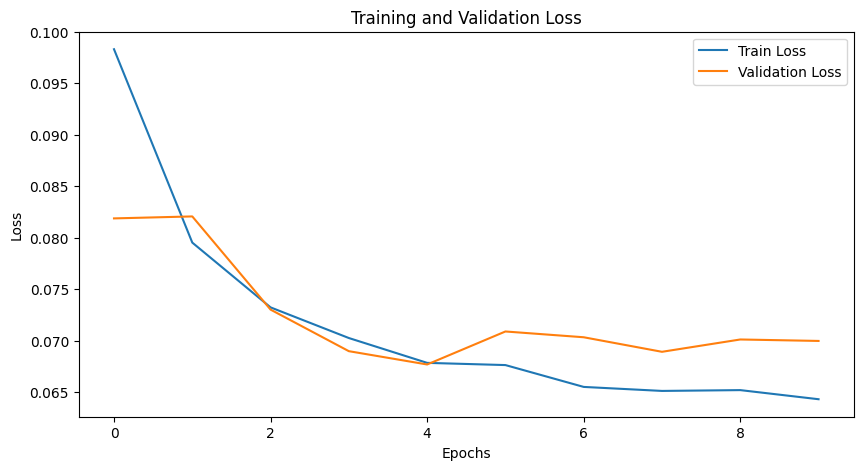

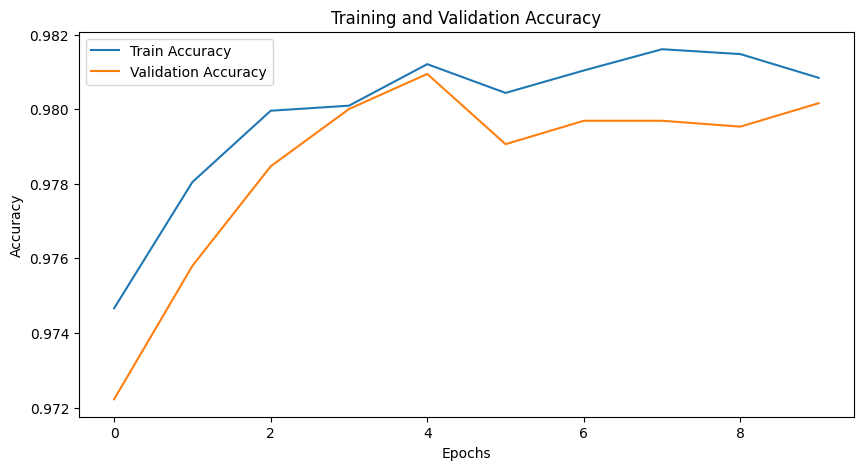

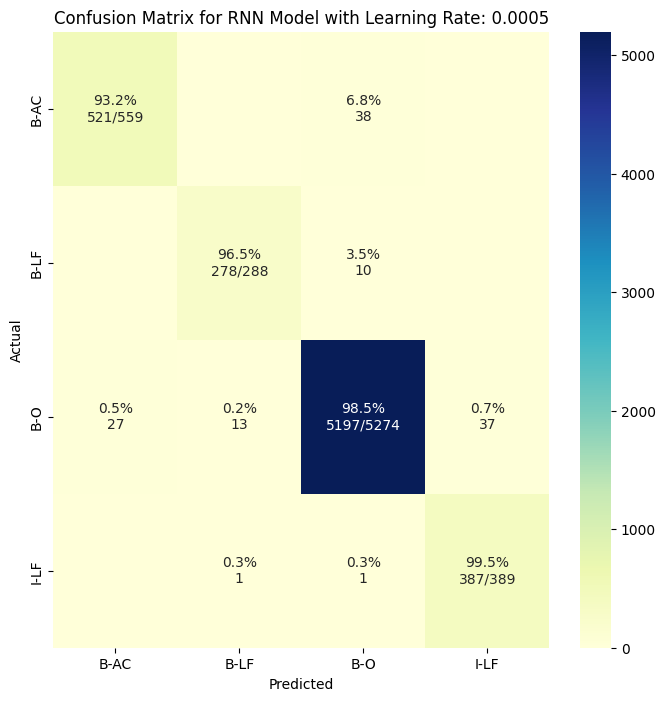

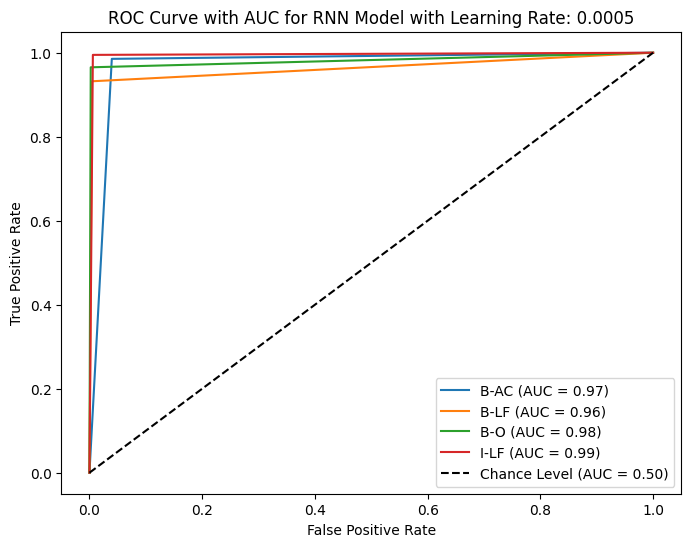

Training for Learning Rate: 0.001
Epoch: 0 | Training Loss: 0.1140   | Training Accuracy: 0.9723
Epoch: 0 | Validation Loss: 0.0860 | Validation Accuracy: 0.9747
Epoch: 1 | Training Loss: 0.0888   | Training Accuracy: 0.9773
Epoch: 1 | Validation Loss: 0.0800 | Validation Accuracy: 0.9786
Epoch: 2 | Training Loss: 0.0845   | Training Accuracy: 0.9771
Epoch: 2 | Validation Loss: 0.0724 | Validation Accuracy: 0.9798
Epoch: 3 | Training Loss: 0.0804   | Training Accuracy: 0.9785
Epoch: 3 | Validation Loss: 0.0766 | Validation Accuracy: 0.9802
Epoch: 4 | Training Loss: 0.0778   | Training Accuracy: 0.9791
Epoch: 4 | Validation Loss: 0.0737 | Validation Accuracy: 0.9800
Epoch: 5 | Training Loss: 0.0783   | Training Accuracy: 0.9791
Epoch: 5 | Validation Loss: 0.0747 | Validation Accuracy: 0.9797
Epoch: 6 | Training Loss: 0.0751   | Training Accuracy: 0.9796
Epoch: 6 | Validation Loss: 0.0746 | Validation Accuracy: 0.9802
Epoch: 7 | Training Loss: 0.0737   | Training Accuracy: 0.9799
Epoch: 

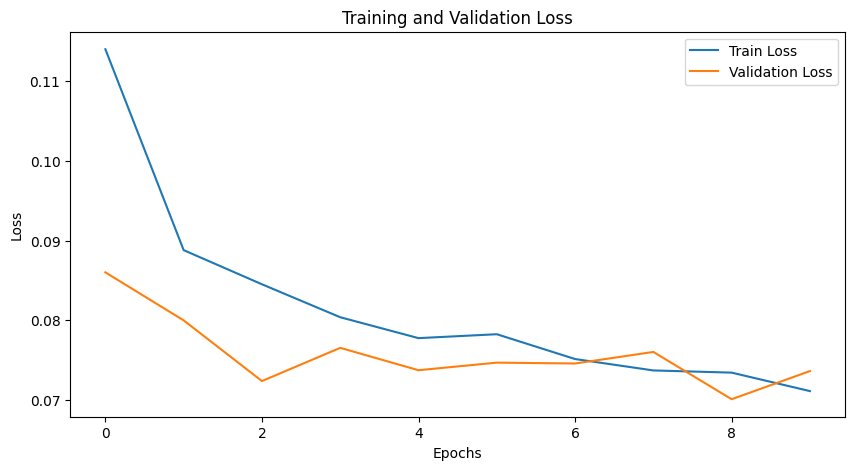

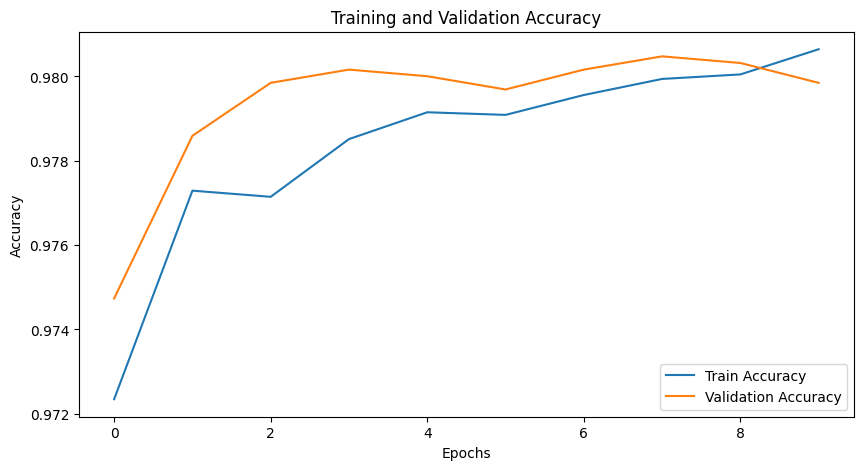

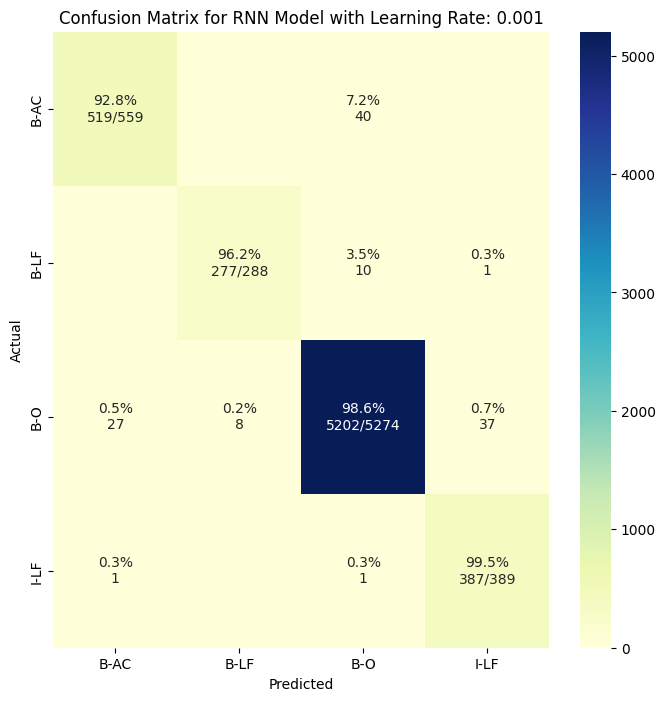

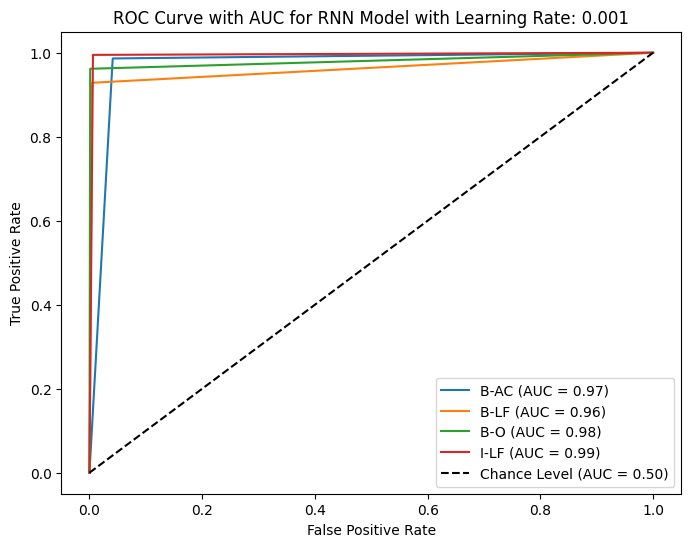

Training for Learning Rate: 0.005
Epoch: 0 | Training Loss: 0.1978   | Training Accuracy: 0.9547
Epoch: 0 | Validation Loss: 0.1009 | Validation Accuracy: 0.9695
Epoch: 1 | Training Loss: 0.2333   | Training Accuracy: 0.9444
Epoch: 1 | Validation Loss: 0.1765 | Validation Accuracy: 0.9706
Epoch: 2 | Training Loss: 0.2256   | Training Accuracy: 0.9533
Epoch: 2 | Validation Loss: 0.3257 | Validation Accuracy: 0.9387
Epoch: 3 | Training Loss: 0.2313   | Training Accuracy: 0.9547
Epoch: 3 | Validation Loss: 0.1555 | Validation Accuracy: 0.9744
Epoch: 4 | Training Loss: 0.2055   | Training Accuracy: 0.9601
Epoch: 4 | Validation Loss: 0.1267 | Validation Accuracy: 0.9789
Epoch: 5 | Training Loss: 0.2782   | Training Accuracy: 0.9444
Epoch: 5 | Validation Loss: 0.4561 | Validation Accuracy: 0.8697
Epoch: 6 | Training Loss: 0.3291   | Training Accuracy: 0.9288
Epoch: 6 | Validation Loss: 0.3765 | Validation Accuracy: 0.8785
Epoch: 7 | Training Loss: 0.4234   | Training Accuracy: 0.9109
Epoch: 

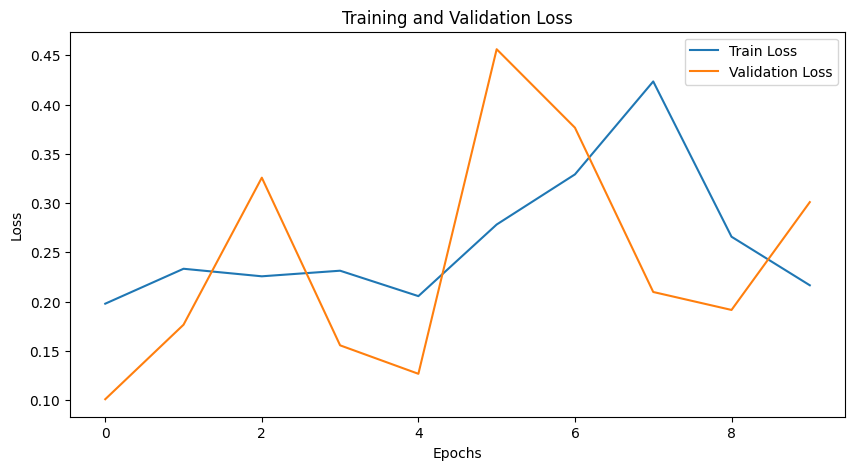

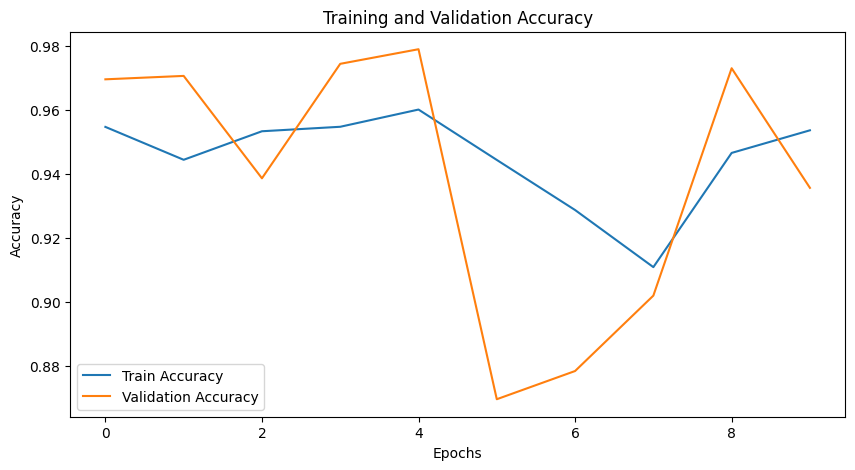

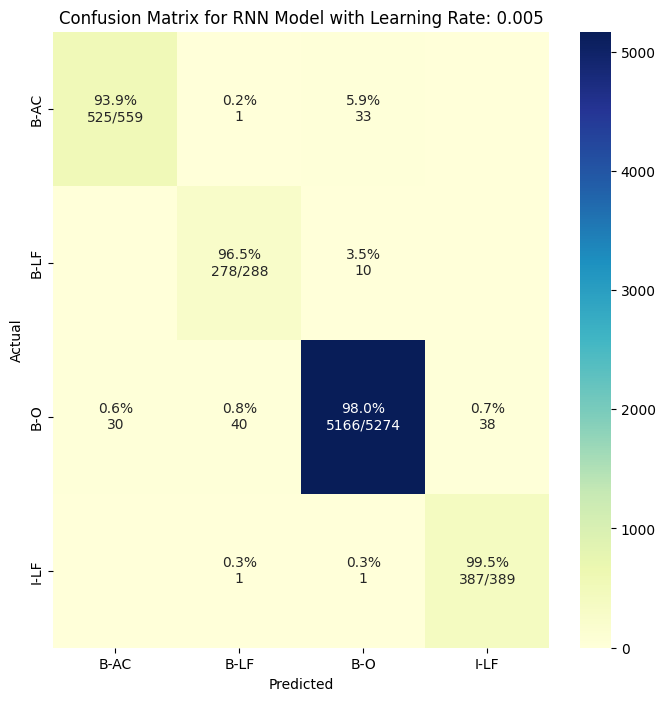

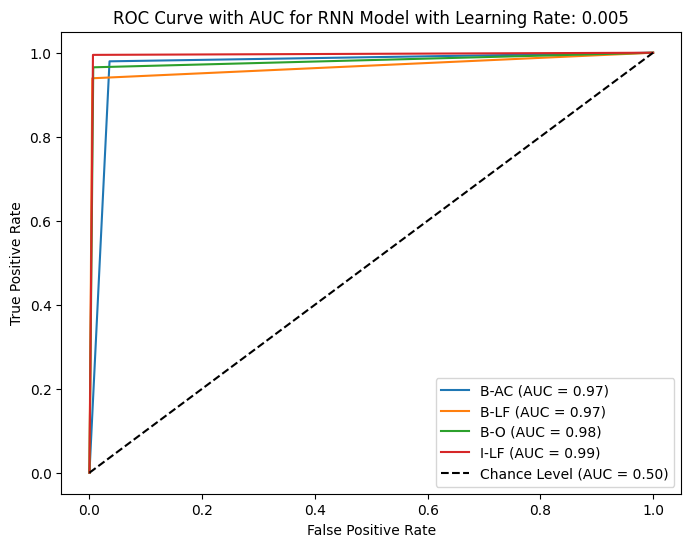

Training for Learning Rate: 0.01
Epoch: 0 | Training Loss: 0.3772   | Training Accuracy: 0.9150
Epoch: 0 | Validation Loss: 0.1893 | Validation Accuracy: 0.9591
Epoch: 1 | Training Loss: 0.5152   | Training Accuracy: 0.9052
Epoch: 1 | Validation Loss: 0.1678 | Validation Accuracy: 0.9760
Epoch: 2 | Training Loss: 0.4337   | Training Accuracy: 0.9102
Epoch: 2 | Validation Loss: 0.5793 | Validation Accuracy: 0.9289
Epoch: 3 | Training Loss: 0.4818   | Training Accuracy: 0.9128
Epoch: 3 | Validation Loss: 0.2439 | Validation Accuracy: 0.9733
Epoch: 4 | Training Loss: 0.5538   | Training Accuracy: 0.9099
Epoch: 4 | Validation Loss: 0.5201 | Validation Accuracy: 0.8622
Epoch: 5 | Training Loss: 1.1494   | Training Accuracy: 0.8106
Epoch: 5 | Validation Loss: 1.1210 | Validation Accuracy: 0.8013
Epoch: 6 | Training Loss: 1.5512   | Training Accuracy: 0.6954
Epoch: 6 | Validation Loss: 0.8399 | Validation Accuracy: 0.7999
Epoch: 7 | Training Loss: 1.1862   | Training Accuracy: 0.7668
Epoch: 7

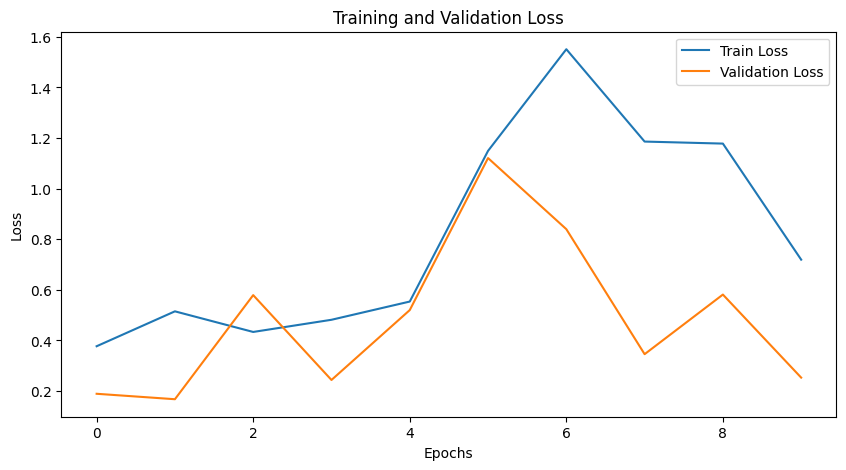

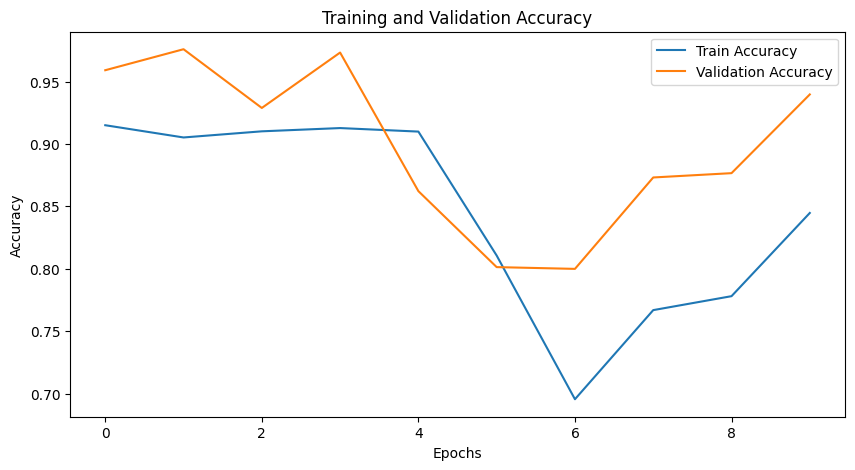

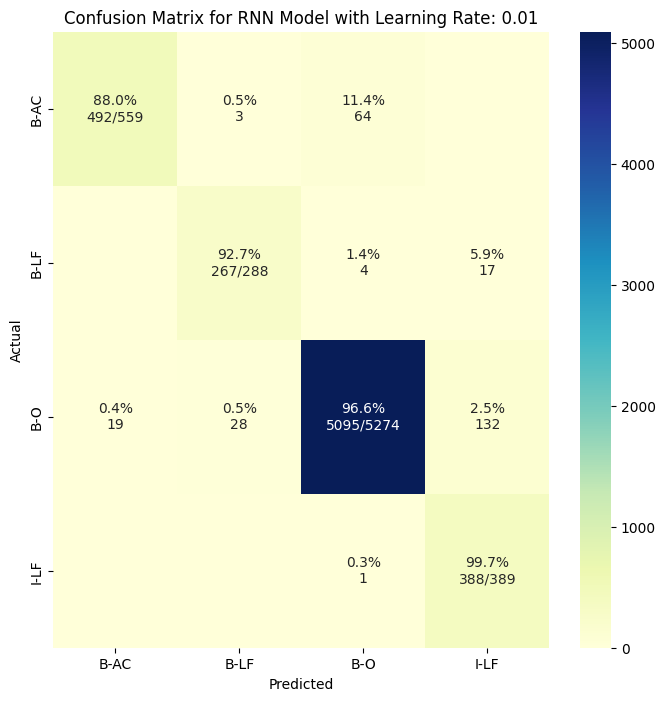

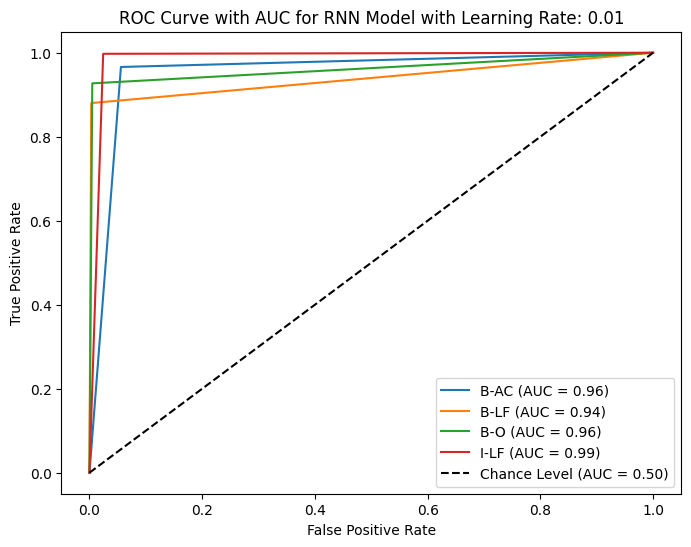

In [749]:
#Learning Rate Values
lr_values = [0.0001, 0.0005, 0.001, 0.005, 0.01]
#Store the results for each learning rate for plotting
lr_result_list = []

for value in lr_values:
    print(f"Training for Learning Rate: {value}")
    RNN_model = RNN(1024)
    model = train_NN(RNN_model, train_data, val_data, learning_rate=value, epochs=10, batch_size=32)
    results = get_test_results(model, test_data, f'RNN Model with Learning Rate: {value}')
    lr_result_list.append(results)

Get Result Comparisons between the different learning rates.

+--------+---------------------+------------------+--------------+--------------------+
|        |   Overall Precision |   Overall Recall |   Overall F1 |   Overall Accuracy |
|--------+---------------------+------------------+--------------+--------------------|
| 0.0001 |            0.984101 |         0.980565 |     0.98233  |           0.982028 |
| 0.0005 |            0.983755 |         0.979095 |     0.981419 |           0.980492 |
| 0.001  |            0.983437 |         0.979422 |     0.981425 |           0.980799 |
| 0.005  |            0.979967 |         0.974686 |     0.977319 |           0.976344 |
| 0.01   |            0.970842 |         0.957047 |     0.963895 |           0.958833 |
+--------+---------------------+------------------+--------------+--------------------+


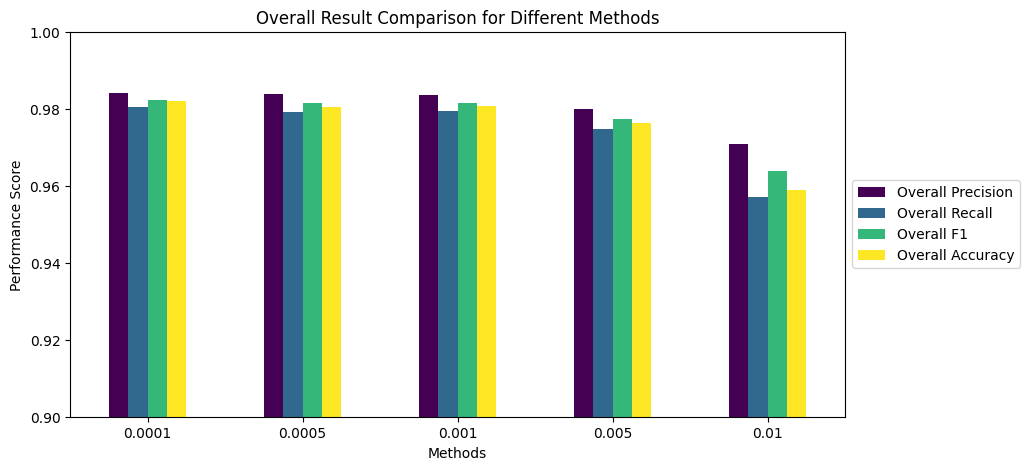

[0.9506398537477148, 0.9507299270072993, 0.9488117001828154, 0.9459459459459459, 0.9628180039138943]
+--------+----------------+-------------+----------+
|        |   AC Precision |   AC Recall |    AC F1 |
|--------+----------------+-------------+----------|
| 0.0001 |       0.95064  |    0.930233 | 0.940325 |
| 0.0005 |       0.95073  |    0.932021 | 0.941283 |
| 0.001  |       0.948812 |    0.928444 | 0.938517 |
| 0.005  |       0.945946 |    0.939177 | 0.942549 |
| 0.01   |       0.962818 |    0.880143 | 0.919626 |
+--------+----------------+-------------+----------+


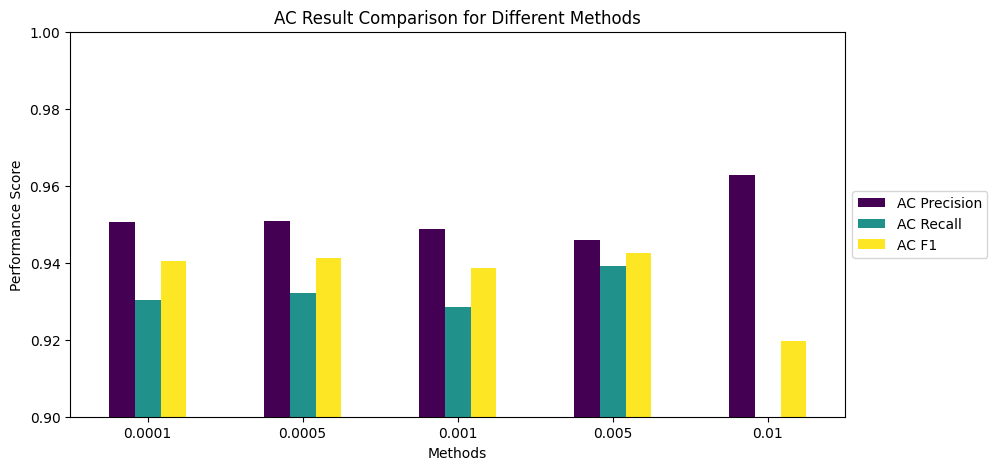

[0.9326599326599326, 0.9233333333333333, 0.9261744966442953, 0.8523076923076923, 0.7562326869806094]
+--------+----------------+-------------+----------+
|        |   LF Precision |   LF Recall |    LF F1 |
|--------+----------------+-------------+----------|
| 0.0001 |       0.93266  |    0.955172 | 0.943782 |
| 0.0005 |       0.923333 |    0.955172 | 0.938983 |
| 0.001  |       0.926174 |    0.951724 | 0.938776 |
| 0.005  |       0.852308 |    0.955172 | 0.900813 |
| 0.01   |       0.756233 |    0.941379 | 0.83871  |
+--------+----------------+-------------+----------+


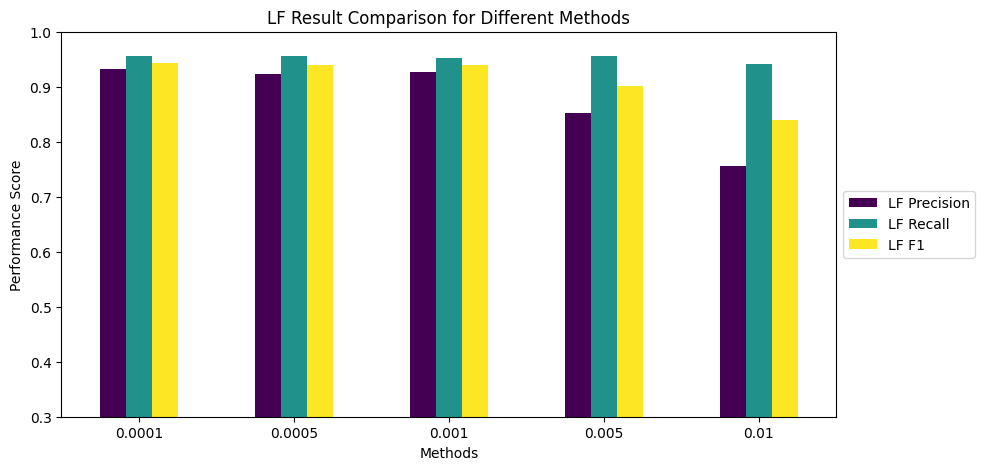

[0.9904888719802168, 0.990659550133435, 0.9902912621359223, 0.9915547024952015, 0.9866382649109218]
+--------+---------------+------------+----------+
|        |   O Precision |   O Recall |     O F1 |
|--------+---------------+------------+----------|
| 0.0001 |      0.990489 |   0.987296 | 0.98889  |
| 0.0005 |      0.99066  |   0.9854   | 0.988023 |
| 0.001  |      0.990291 |   0.986348 | 0.988316 |
| 0.005  |      0.991555 |   0.979522 | 0.985502 |
| 0.01   |      0.986638 |   0.96606  | 0.976241 |
+--------+---------------+------------+----------+


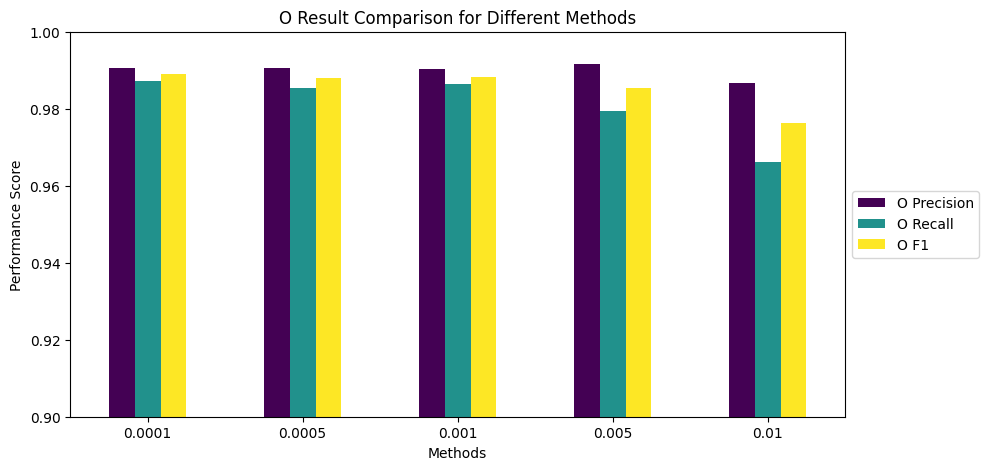

In [750]:
plot_overall_comparison(lr_result_list, lr_values, ylim=(0.9,1))
plot_comparison(lr_result_list, lr_values, 'AC', ylim=(0.9,1))
plot_comparison(lr_result_list, lr_values, 'LF', ylim=(0.3,1))
plot_comparison(lr_result_list, lr_values, 'O', ylim=(0.9,1))

# Test 2. Batch Size

Fixing the best learning rate from the previous test, the batch size will be tuned here.

Training for Batch Size: 16
Epoch: 0 | Training Loss: 0.0802   | Training Accuracy: 0.9771
Epoch: 0 | Validation Loss: 0.0690 | Validation Accuracy: 0.9798
Epoch: 1 | Training Loss: 0.0661   | Training Accuracy: 0.9808
Epoch: 1 | Validation Loss: 0.0627 | Validation Accuracy: 0.9817
Epoch: 2 | Training Loss: 0.0621   | Training Accuracy: 0.9815
Epoch: 2 | Validation Loss: 0.0615 | Validation Accuracy: 0.9822
Epoch: 3 | Training Loss: 0.0582   | Training Accuracy: 0.9821
Epoch: 3 | Validation Loss: 0.0606 | Validation Accuracy: 0.9820
Epoch: 4 | Training Loss: 0.0556   | Training Accuracy: 0.9825
Epoch: 4 | Validation Loss: 0.0608 | Validation Accuracy: 0.9820
Epoch: 5 | Training Loss: 0.0536   | Training Accuracy: 0.9829
Epoch: 5 | Validation Loss: 0.0599 | Validation Accuracy: 0.9828
Epoch: 6 | Training Loss: 0.0520   | Training Accuracy: 0.9835
Epoch: 6 | Validation Loss: 0.0611 | Validation Accuracy: 0.9825
Epoch: 7 | Training Loss: 0.0504   | Training Accuracy: 0.9839
Epoch: 7 | Va

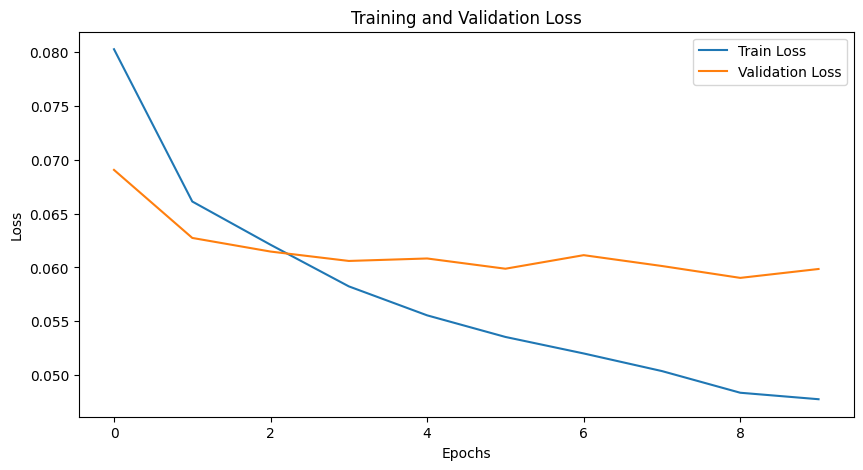

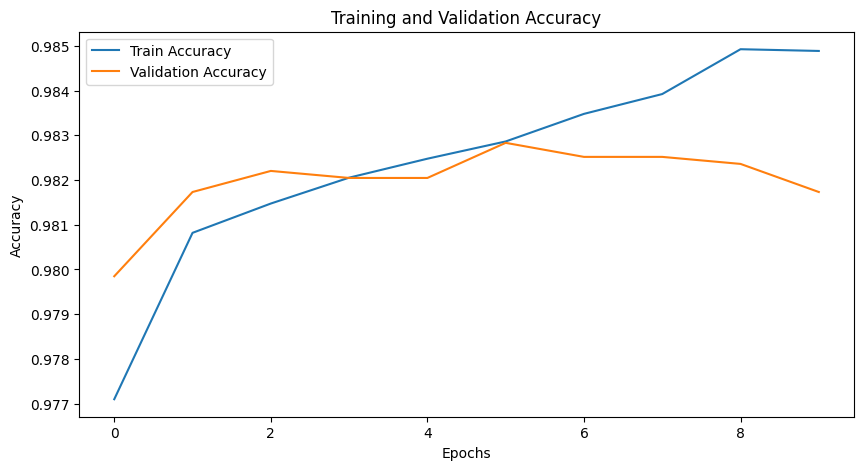

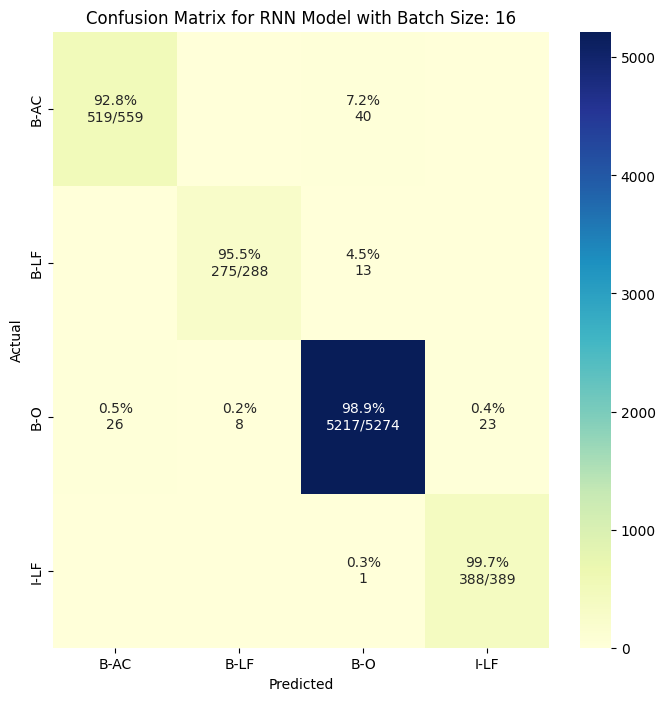

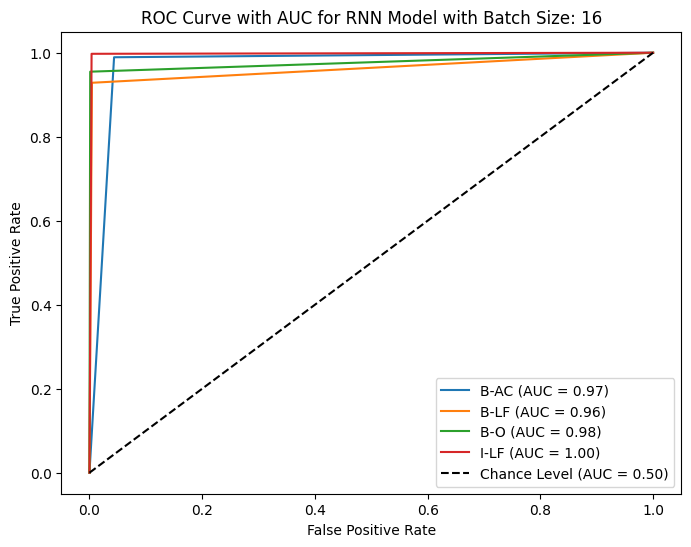

Training for Batch Size: 32
Epoch: 0 | Training Loss: 0.0792   | Training Accuracy: 0.9767
Epoch: 0 | Validation Loss: 0.0674 | Validation Accuracy: 0.9803
Epoch: 1 | Training Loss: 0.0637   | Training Accuracy: 0.9816
Epoch: 1 | Validation Loss: 0.0660 | Validation Accuracy: 0.9813
Epoch: 2 | Training Loss: 0.0596   | Training Accuracy: 0.9824
Epoch: 2 | Validation Loss: 0.0630 | Validation Accuracy: 0.9815
Epoch: 3 | Training Loss: 0.0568   | Training Accuracy: 0.9829
Epoch: 3 | Validation Loss: 0.0642 | Validation Accuracy: 0.9791
Epoch: 4 | Training Loss: 0.0544   | Training Accuracy: 0.9835
Epoch: 4 | Validation Loss: 0.0607 | Validation Accuracy: 0.9830
Epoch: 5 | Training Loss: 0.0529   | Training Accuracy: 0.9839
Epoch: 5 | Validation Loss: 0.0592 | Validation Accuracy: 0.9830
Epoch: 6 | Training Loss: 0.0514   | Training Accuracy: 0.9842
Epoch: 6 | Validation Loss: 0.0590 | Validation Accuracy: 0.9830
Epoch: 7 | Training Loss: 0.0496   | Training Accuracy: 0.9848
Epoch: 7 | Va

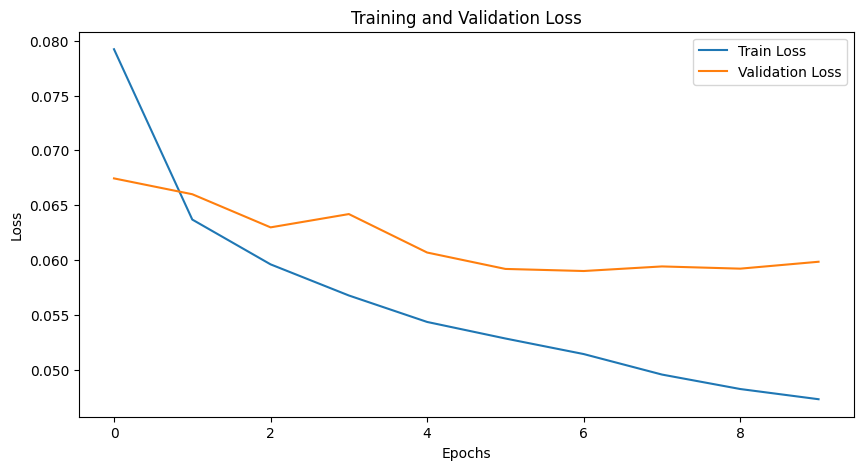

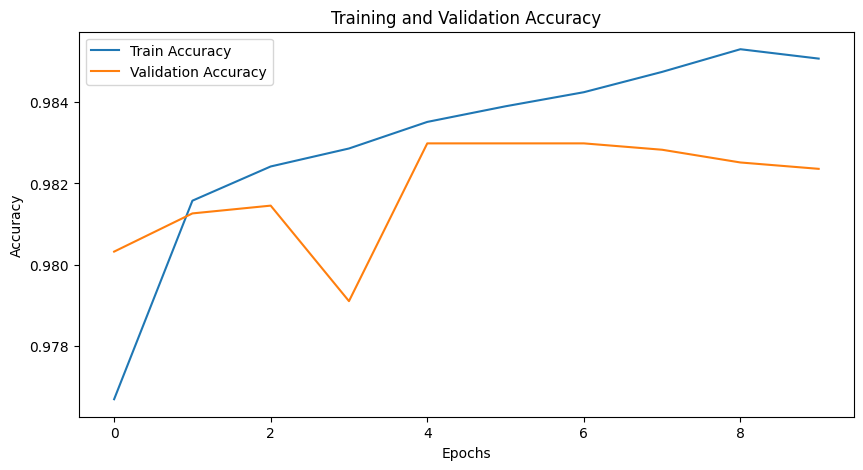

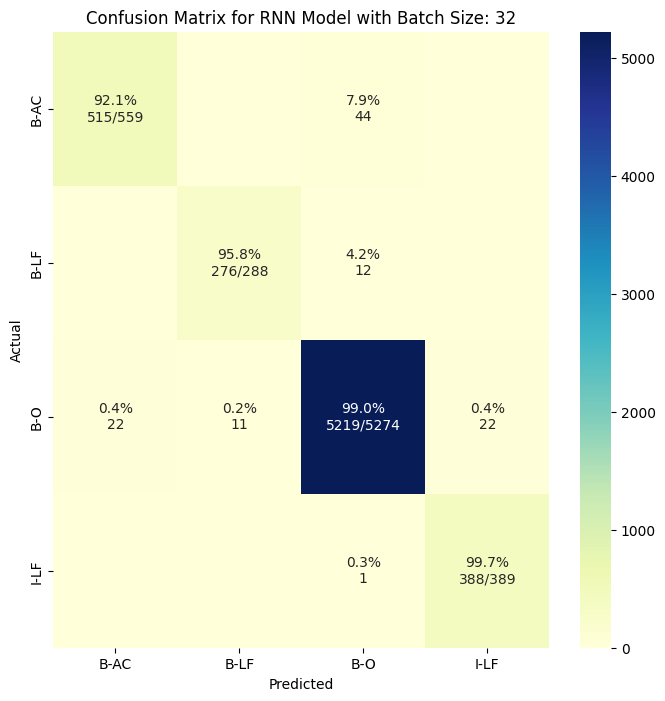

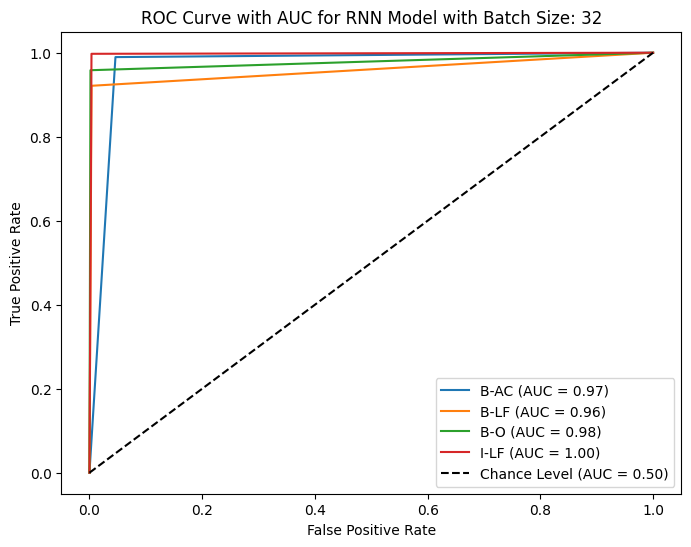

Training for Batch Size: 64
Epoch: 0 | Training Loss: 0.0831   | Training Accuracy: 0.9749
Epoch: 0 | Validation Loss: 0.0670 | Validation Accuracy: 0.9819
Epoch: 1 | Training Loss: 0.0611   | Training Accuracy: 0.9819
Epoch: 1 | Validation Loss: 0.0654 | Validation Accuracy: 0.9822
Epoch: 2 | Training Loss: 0.0583   | Training Accuracy: 0.9827
Epoch: 2 | Validation Loss: 0.0633 | Validation Accuracy: 0.9825
Epoch: 3 | Training Loss: 0.0562   | Training Accuracy: 0.9830
Epoch: 3 | Validation Loss: 0.0616 | Validation Accuracy: 0.9825
Epoch: 4 | Training Loss: 0.0544   | Training Accuracy: 0.9835
Epoch: 4 | Validation Loss: 0.0601 | Validation Accuracy: 0.9830
Epoch: 5 | Training Loss: 0.0527   | Training Accuracy: 0.9839
Epoch: 5 | Validation Loss: 0.0595 | Validation Accuracy: 0.9830
Epoch: 6 | Training Loss: 0.0510   | Training Accuracy: 0.9846
Epoch: 6 | Validation Loss: 0.0593 | Validation Accuracy: 0.9824
Epoch: 7 | Training Loss: 0.0496   | Training Accuracy: 0.9849
Epoch: 7 | Va

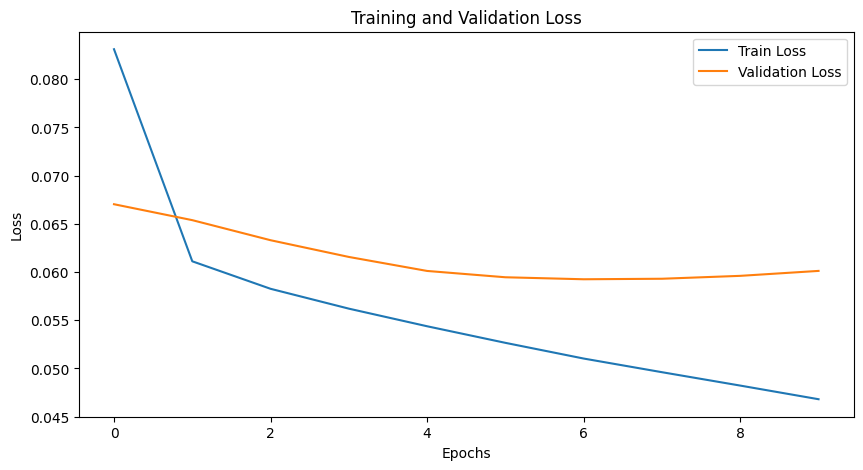

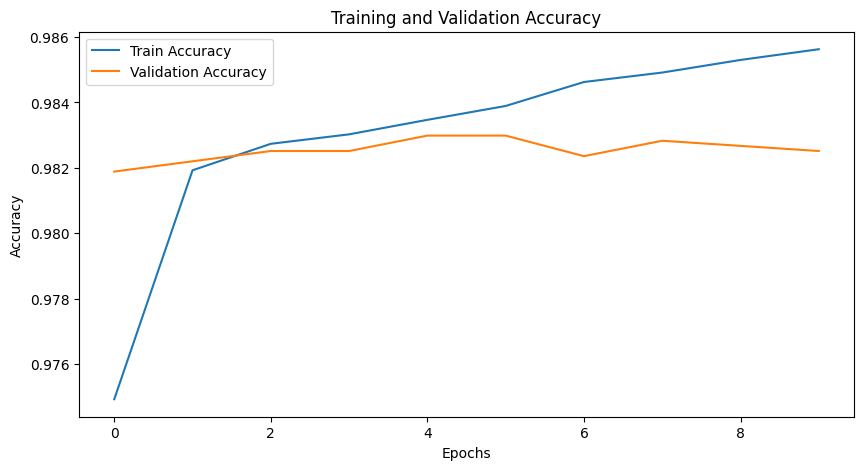

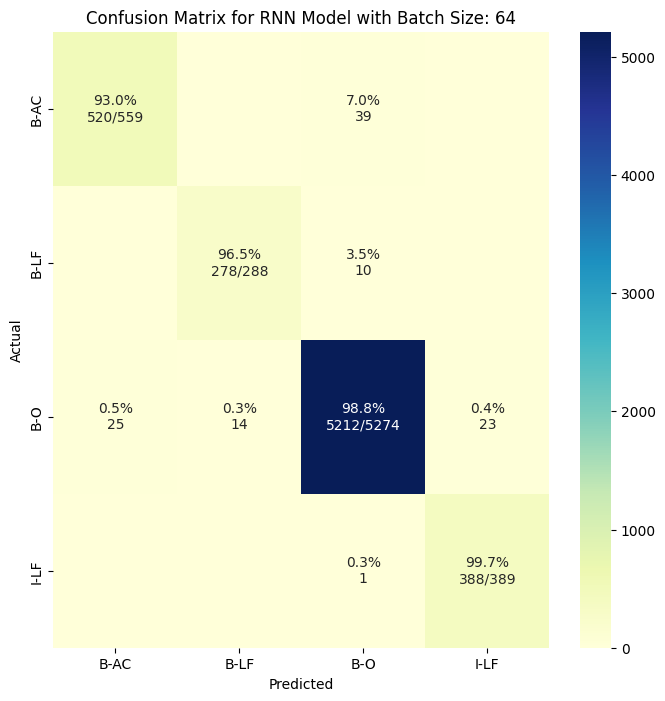

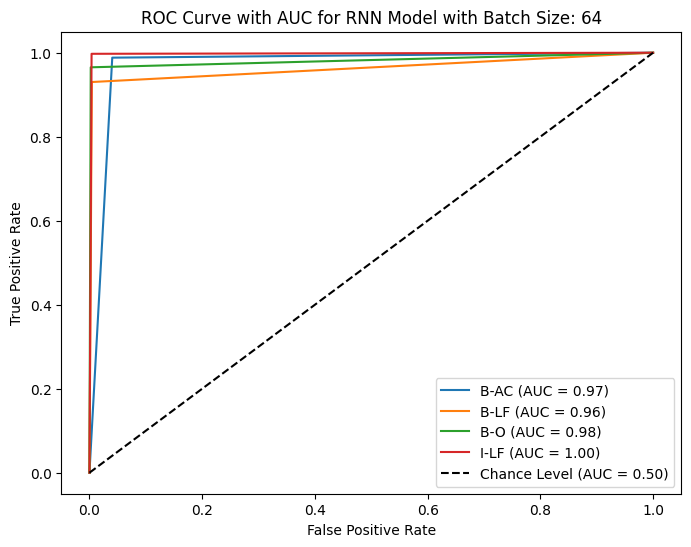

Training for Batch Size: 128
Epoch: 0 | Training Loss: 0.0879   | Training Accuracy: 0.9724
Epoch: 0 | Validation Loss: 0.0695 | Validation Accuracy: 0.9811
Epoch: 1 | Training Loss: 0.0605   | Training Accuracy: 0.9826
Epoch: 1 | Validation Loss: 0.0656 | Validation Accuracy: 0.9816
Epoch: 2 | Training Loss: 0.0578   | Training Accuracy: 0.9832
Epoch: 2 | Validation Loss: 0.0632 | Validation Accuracy: 0.9820
Epoch: 3 | Training Loss: 0.0559   | Training Accuracy: 0.9836
Epoch: 3 | Validation Loss: 0.0613 | Validation Accuracy: 0.9822
Epoch: 4 | Training Loss: 0.0543   | Training Accuracy: 0.9838
Epoch: 4 | Validation Loss: 0.0600 | Validation Accuracy: 0.9825
Epoch: 5 | Training Loss: 0.0528   | Training Accuracy: 0.9840
Epoch: 5 | Validation Loss: 0.0592 | Validation Accuracy: 0.9831
Epoch: 6 | Training Loss: 0.0514   | Training Accuracy: 0.9843
Epoch: 6 | Validation Loss: 0.0588 | Validation Accuracy: 0.9831
Epoch: 7 | Training Loss: 0.0501   | Training Accuracy: 0.9845
Epoch: 7 | V

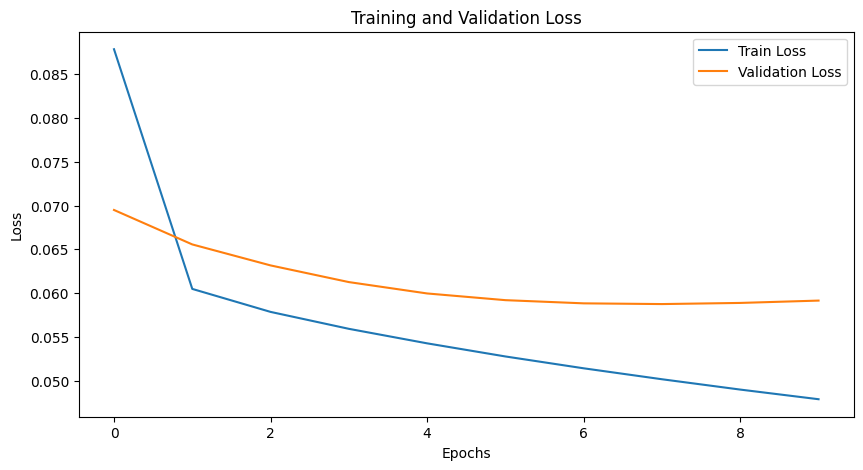

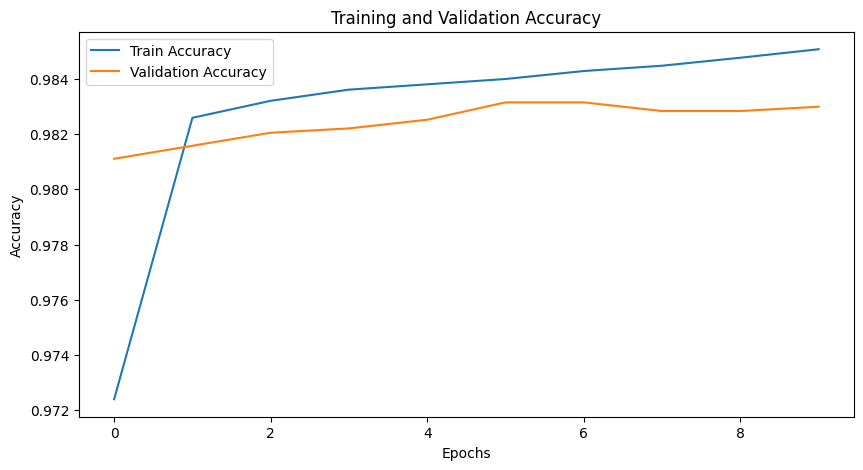

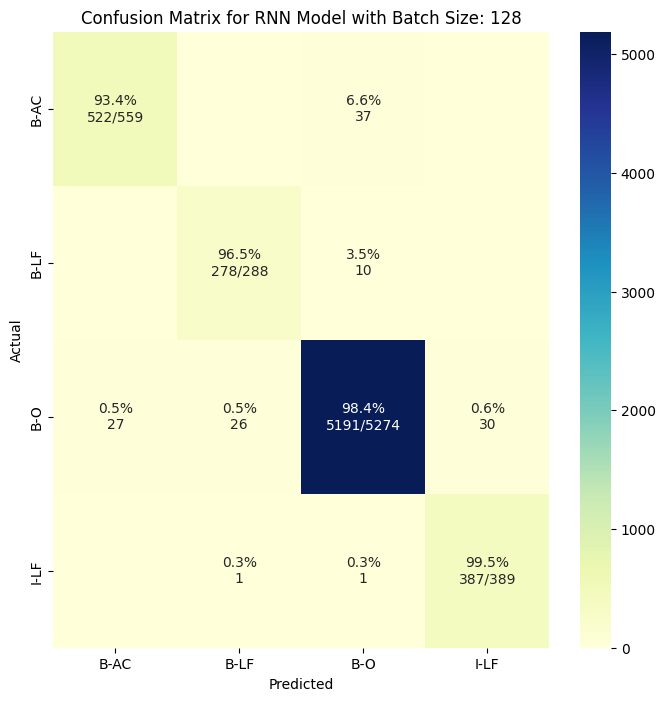

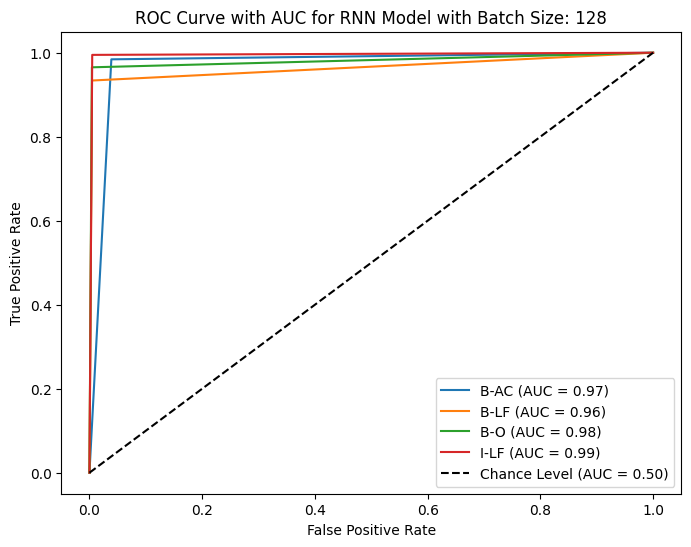

Training for Batch Size: 256
Epoch: 0 | Training Loss: 0.1084   | Training Accuracy: 0.9661
Epoch: 0 | Validation Loss: 0.0621 | Validation Accuracy: 0.9814
Epoch: 1 | Training Loss: 0.0595   | Training Accuracy: 0.9822
Epoch: 1 | Validation Loss: 0.0592 | Validation Accuracy: 0.9826
Epoch: 2 | Training Loss: 0.0570   | Training Accuracy: 0.9827
Epoch: 2 | Validation Loss: 0.0583 | Validation Accuracy: 0.9831
Epoch: 3 | Training Loss: 0.0552   | Training Accuracy: 0.9831
Epoch: 3 | Validation Loss: 0.0577 | Validation Accuracy: 0.9833
Epoch: 4 | Training Loss: 0.0539   | Training Accuracy: 0.9835
Epoch: 4 | Validation Loss: 0.0574 | Validation Accuracy: 0.9831
Epoch: 5 | Training Loss: 0.0527   | Training Accuracy: 0.9838
Epoch: 5 | Validation Loss: 0.0571 | Validation Accuracy: 0.9831
Epoch: 6 | Training Loss: 0.0517   | Training Accuracy: 0.9841
Epoch: 6 | Validation Loss: 0.0570 | Validation Accuracy: 0.9831
Epoch: 7 | Training Loss: 0.0507   | Training Accuracy: 0.9844
Epoch: 7 | V

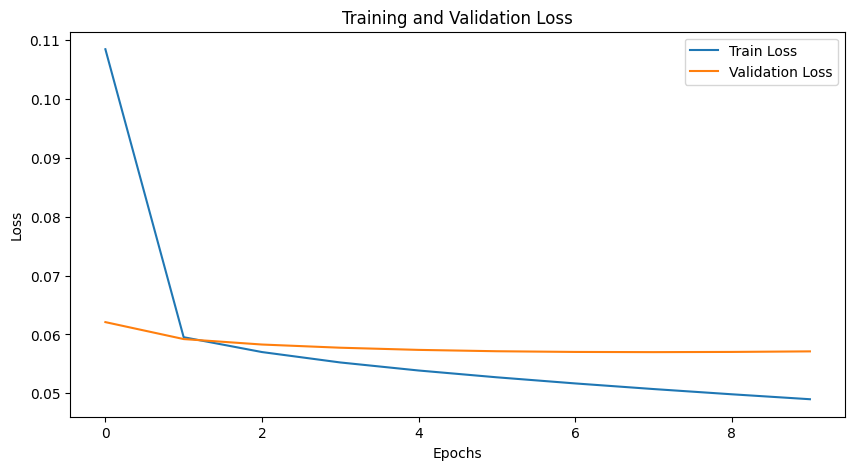

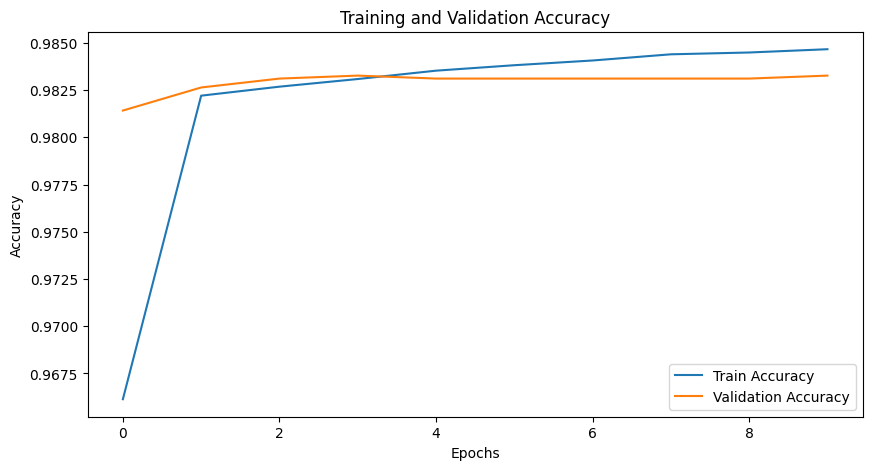

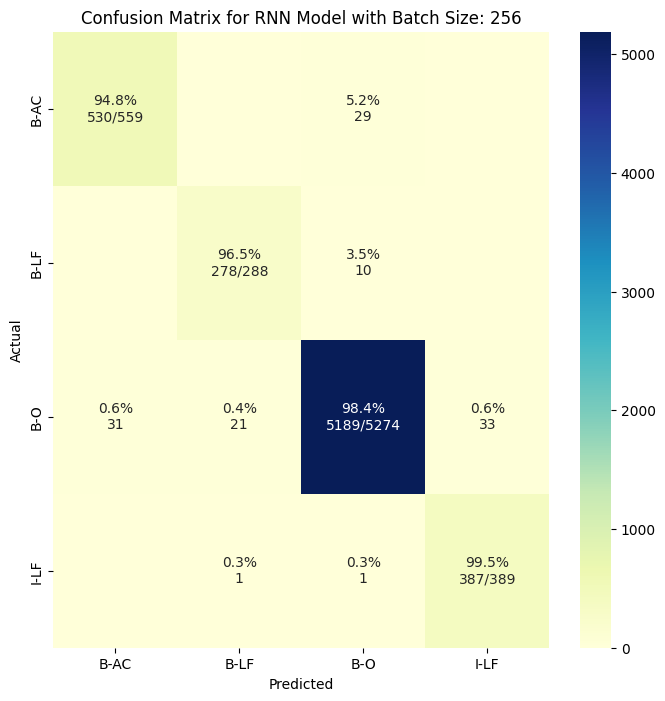

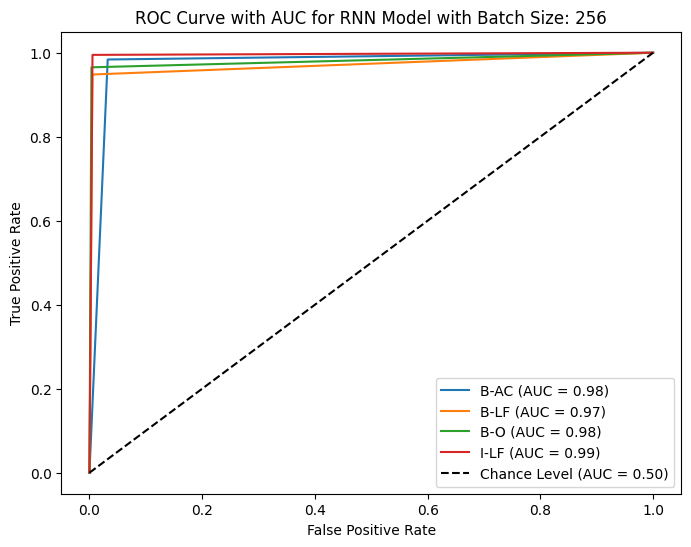

Training for Batch Size: 512
Epoch: 0 | Training Loss: 0.1435   | Training Accuracy: 0.9535
Epoch: 0 | Validation Loss: 0.0647 | Validation Accuracy: 0.9817
Epoch: 1 | Training Loss: 0.0578   | Training Accuracy: 0.9832
Epoch: 1 | Validation Loss: 0.0602 | Validation Accuracy: 0.9820
Epoch: 2 | Training Loss: 0.0553   | Training Accuracy: 0.9837
Epoch: 2 | Validation Loss: 0.0589 | Validation Accuracy: 0.9820
Epoch: 3 | Training Loss: 0.0538   | Training Accuracy: 0.9838
Epoch: 3 | Validation Loss: 0.0583 | Validation Accuracy: 0.9820
Epoch: 4 | Training Loss: 0.0527   | Training Accuracy: 0.9840
Epoch: 4 | Validation Loss: 0.0579 | Validation Accuracy: 0.9820
Epoch: 5 | Training Loss: 0.0518   | Training Accuracy: 0.9842
Epoch: 5 | Validation Loss: 0.0575 | Validation Accuracy: 0.9820
Epoch: 6 | Training Loss: 0.0511   | Training Accuracy: 0.9843
Epoch: 6 | Validation Loss: 0.0573 | Validation Accuracy: 0.9814
Epoch: 7 | Training Loss: 0.0504   | Training Accuracy: 0.9844
Epoch: 7 | V

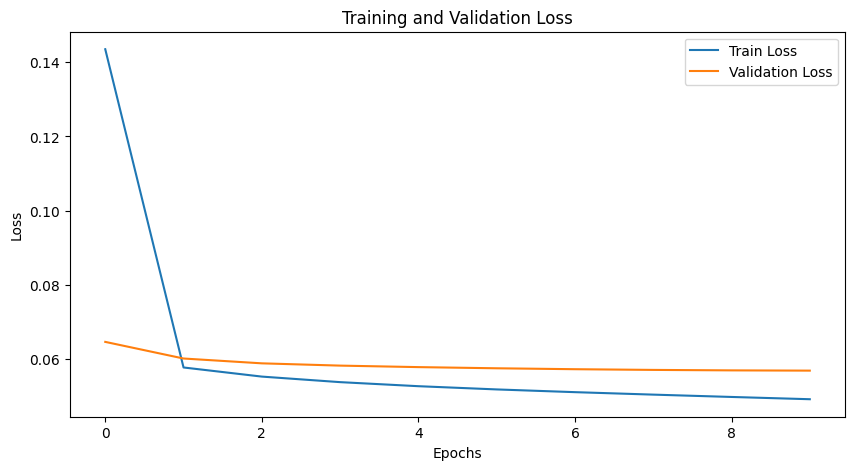

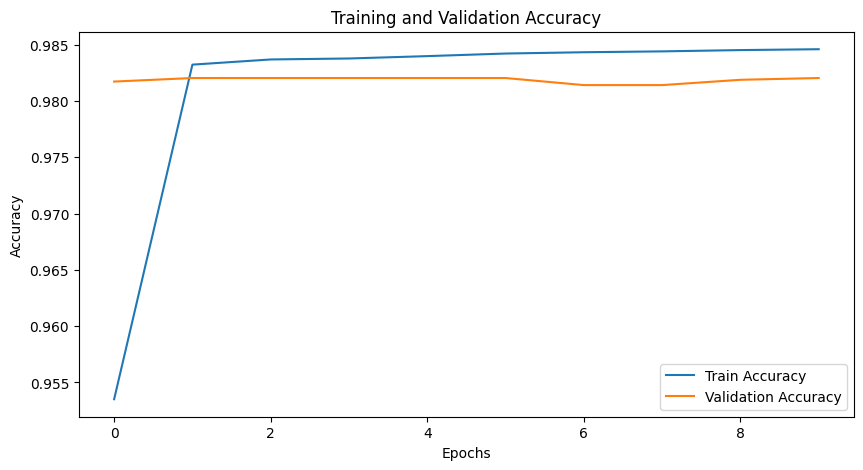

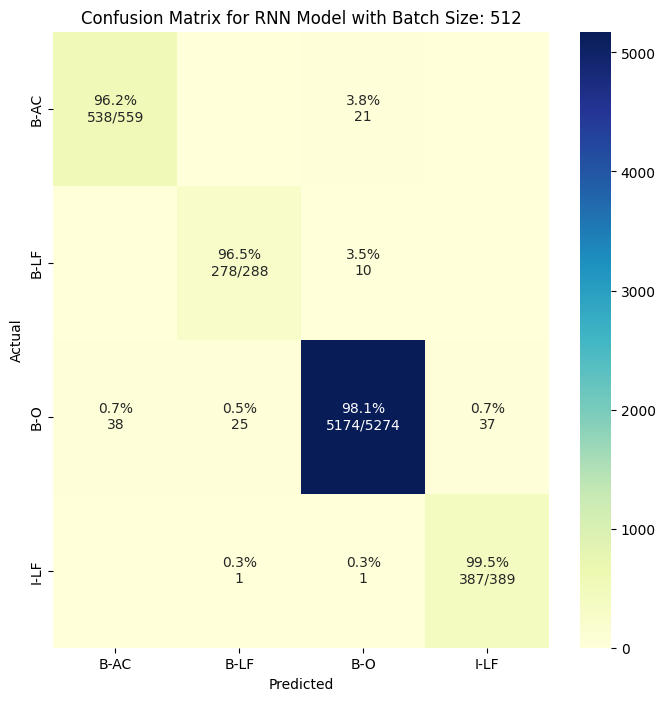

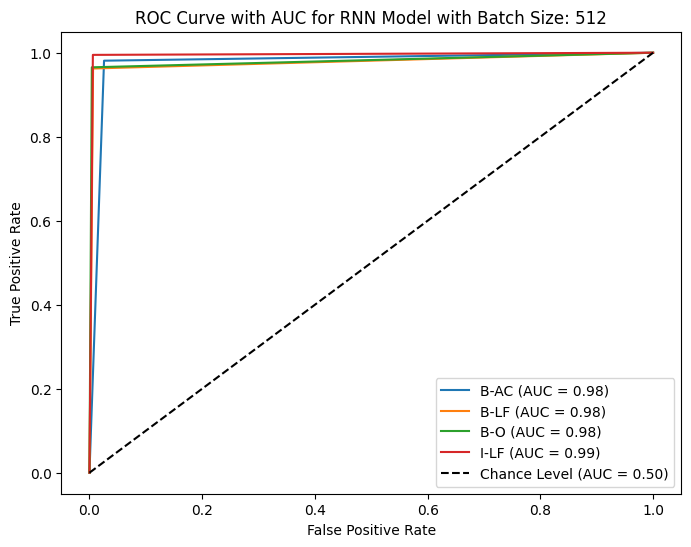

In [752]:
#Batch Size Values
bs_value = [16, 32, 64, 128, 256, 512]
#Store the results for each batch size for plotting
bs_result_list = []

for value in bs_value:
    print(f"Training for Batch Size: {value}")
    RNN_model = RNN(1024)
    model = train_NN(RNN_model, train_data, val_data, learning_rate= 0.0001, epochs=10, batch_size=value)
    results = get_test_results(model, test_data, f'RNN Model with Batch Size: {value}')
    bs_result_list.append(results)

Compare the different results of the different batch sizes.

+-----+---------------------+------------------+--------------+--------------------+
|     |   Overall Precision |   Overall Recall |   Overall F1 |   Overall Accuracy |
|-----+---------------------+------------------+--------------+--------------------|
|  16 |            0.984278 |         0.981545 |     0.982909 |           0.982949 |
|  32 |            0.984439 |         0.981545 |     0.98299  |           0.982796 |
|  64 |            0.984762 |         0.981545 |     0.983151 |           0.982796 |
| 128 |            0.982614 |         0.978442 |     0.980524 |           0.979724 |
| 256 |            0.983919 |         0.979259 |     0.981583 |           0.980645 |
| 512 |            0.983093 |         0.978115 |     0.980598 |           0.97957  |
+-----+---------------------+------------------+--------------+--------------------+


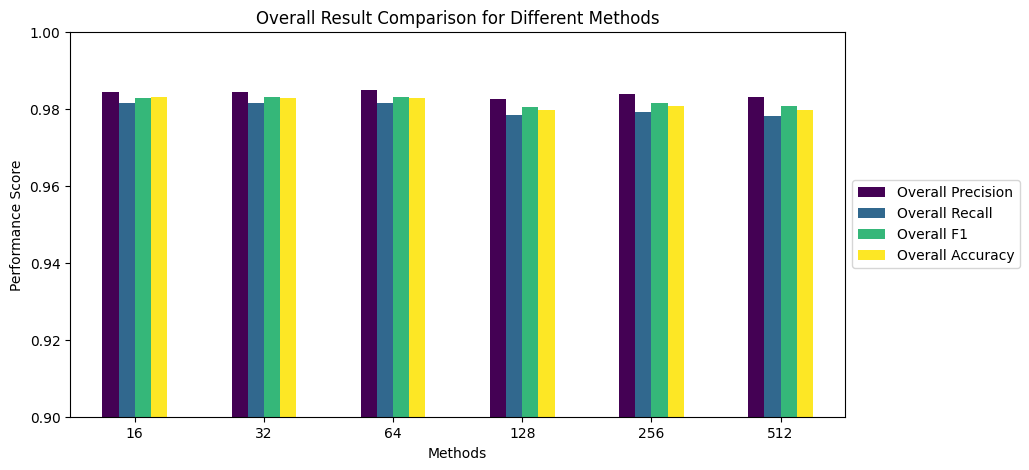

[0.9522935779816514, 0.9590316573556797, 0.9541284403669725, 0.9508196721311475, 0.9447415329768271, 0.9340277777777778]
+-----+----------------+-------------+----------+
|     |   AC Precision |   AC Recall |    AC F1 |
|-----+----------------+-------------+----------|
|  16 |       0.952294 |    0.928444 | 0.940217 |
|  32 |       0.959032 |    0.921288 | 0.939781 |
|  64 |       0.954128 |    0.930233 | 0.942029 |
| 128 |       0.95082  |    0.93381  | 0.942238 |
| 256 |       0.944742 |    0.948122 | 0.946429 |
| 512 |       0.934028 |    0.962433 | 0.948018 |
+-----+----------------+-------------+----------+


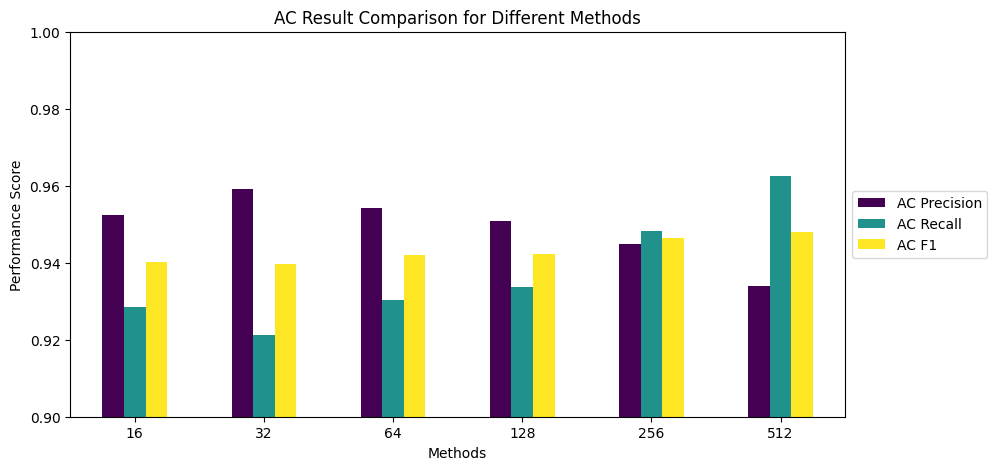

[0.9448275862068966, 0.9452054794520548, 0.9391891891891891, 0.8996763754045307, 0.9111842105263158, 0.8935483870967742]
+-----+----------------+-------------+----------+
|     |   LF Precision |   LF Recall |    LF F1 |
|-----+----------------+-------------+----------|
|  16 |       0.944828 |    0.944828 | 0.944828 |
|  32 |       0.945205 |    0.951724 | 0.948454 |
|  64 |       0.939189 |    0.958621 | 0.948805 |
| 128 |       0.899676 |    0.958621 | 0.928214 |
| 256 |       0.911184 |    0.955172 | 0.93266  |
| 512 |       0.893548 |    0.955172 | 0.923333 |
+-----+----------------+-------------+----------+


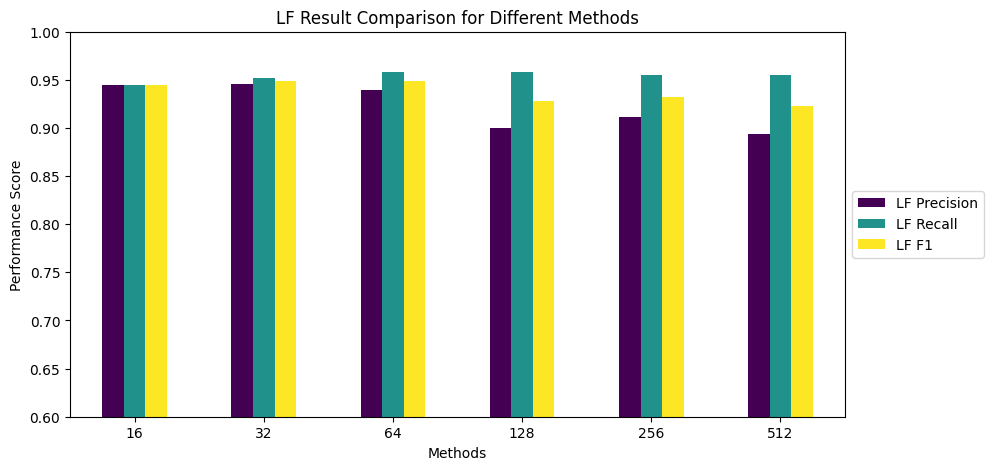

[0.9897552646556631, 0.9891963608794542, 0.9904979095400989, 0.9908379461729337, 0.9923503537961369, 0.9938532462543219]
+-----+---------------+------------+----------+
|     |   O Precision |   O Recall |     O F1 |
|-----+---------------+------------+----------|
|  16 |      0.989755 |   0.989192 | 0.989474 |
|  32 |      0.989196 |   0.989571 | 0.989384 |
|  64 |      0.990498 |   0.988244 | 0.98937  |
| 128 |      0.990838 |   0.984262 | 0.987539 |
| 256 |      0.99235  |   0.983883 | 0.988099 |
| 512 |      0.993853 |   0.981039 | 0.987405 |
+-----+---------------+------------+----------+


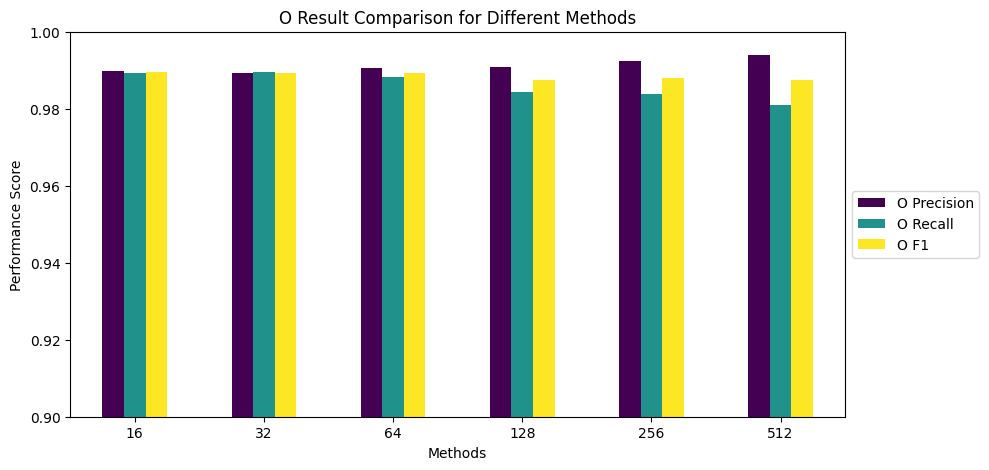

In [753]:
plot_overall_comparison(bs_result_list, bs_value, ylim=(0.9,1))
plot_comparison(bs_result_list, bs_value, 'AC', ylim=(0.9,1))
plot_comparison(bs_result_list, bs_value, 'LF', ylim=(0.6,1))
plot_comparison(bs_result_list, bs_value, 'O', ylim=(0.9,1))

# Test 3. Epoch Length

Fixing both the learning rate and batch sizes from the previous section, we will tune the epochs.

Training for Epochs: 5
Epoch: 0 | Training Loss: 0.0831   | Training Accuracy: 0.9749
Epoch: 0 | Validation Loss: 0.0670 | Validation Accuracy: 0.9819
Epoch: 1 | Training Loss: 0.0611   | Training Accuracy: 0.9819
Epoch: 1 | Validation Loss: 0.0654 | Validation Accuracy: 0.9822
Epoch: 2 | Training Loss: 0.0583   | Training Accuracy: 0.9827
Epoch: 2 | Validation Loss: 0.0633 | Validation Accuracy: 0.9825
Epoch: 3 | Training Loss: 0.0562   | Training Accuracy: 0.9830
Epoch: 3 | Validation Loss: 0.0616 | Validation Accuracy: 0.9825
Epoch: 4 | Training Loss: 0.0544   | Training Accuracy: 0.9835
Epoch: 4 | Validation Loss: 0.0601 | Validation Accuracy: 0.9830
Model Saved to Path ./model_lr0.0001_epochs5_batch64
Finished Training
Execution Time: 249.07 seconds

Classification Report

              precision    recall  f1-score   support

        B-AC       0.96      0.92      0.94       559
        B-LF       0.95      0.97      0.96       288
         B-O       0.99      0.99      0.99     

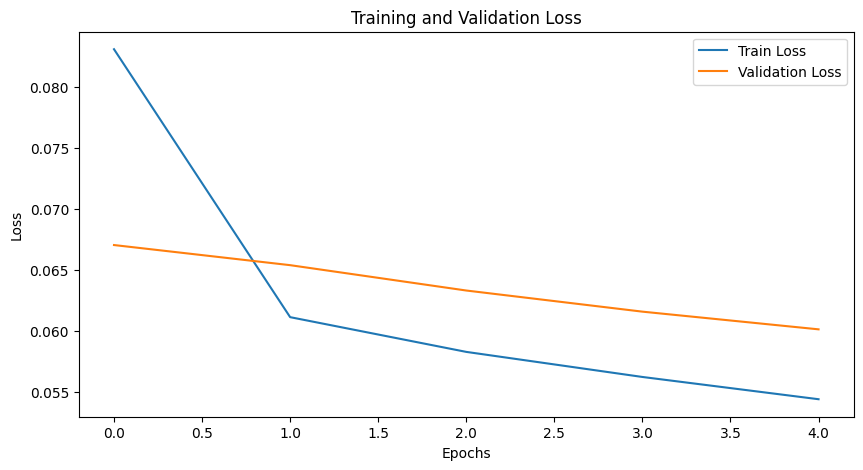

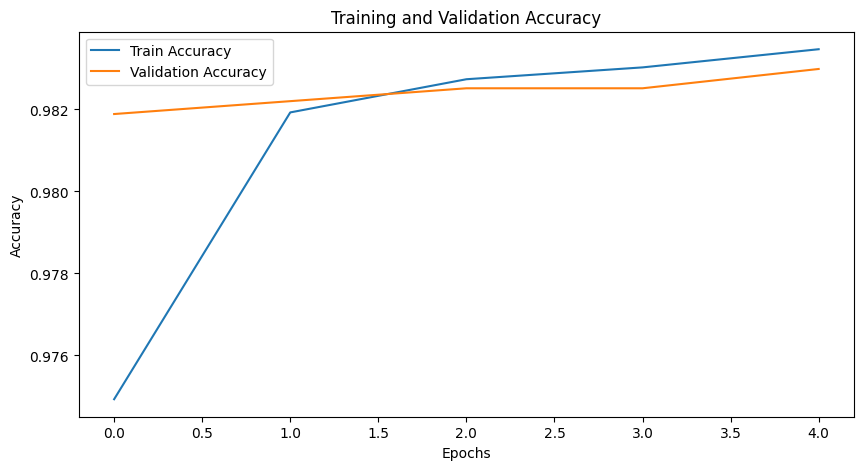

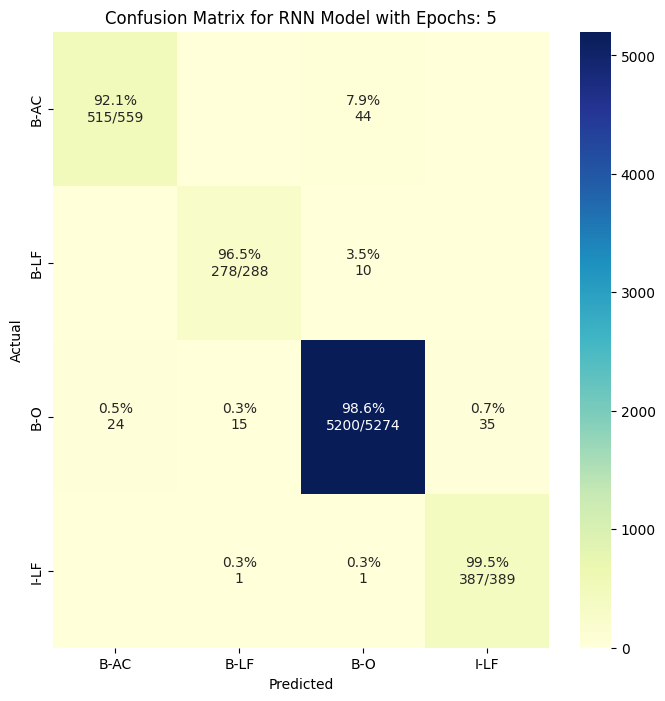

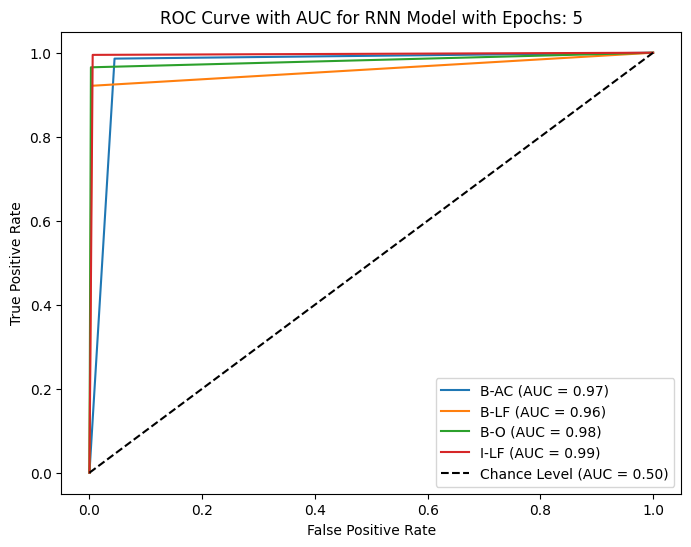

Training for Epochs: 10
Epoch: 0 | Training Loss: 0.0818   | Training Accuracy: 0.9755
Epoch: 0 | Validation Loss: 0.0672 | Validation Accuracy: 0.9822
Epoch: 1 | Training Loss: 0.0612   | Training Accuracy: 0.9819
Epoch: 1 | Validation Loss: 0.0651 | Validation Accuracy: 0.9819
Epoch: 2 | Training Loss: 0.0583   | Training Accuracy: 0.9827
Epoch: 2 | Validation Loss: 0.0631 | Validation Accuracy: 0.9824
Epoch: 3 | Training Loss: 0.0562   | Training Accuracy: 0.9829
Epoch: 3 | Validation Loss: 0.0615 | Validation Accuracy: 0.9825
Epoch: 4 | Training Loss: 0.0544   | Training Accuracy: 0.9834
Epoch: 4 | Validation Loss: 0.0600 | Validation Accuracy: 0.9827
Epoch: 5 | Training Loss: 0.0526   | Training Accuracy: 0.9839
Epoch: 5 | Validation Loss: 0.0594 | Validation Accuracy: 0.9825
Epoch: 6 | Training Loss: 0.0509   | Training Accuracy: 0.9847
Epoch: 6 | Validation Loss: 0.0594 | Validation Accuracy: 0.9824
Epoch: 7 | Training Loss: 0.0497   | Training Accuracy: 0.9848
Epoch: 7 | Valida

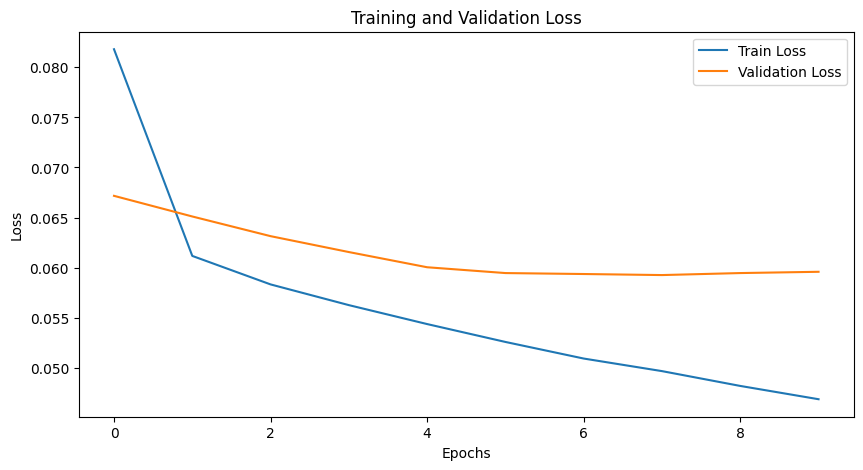

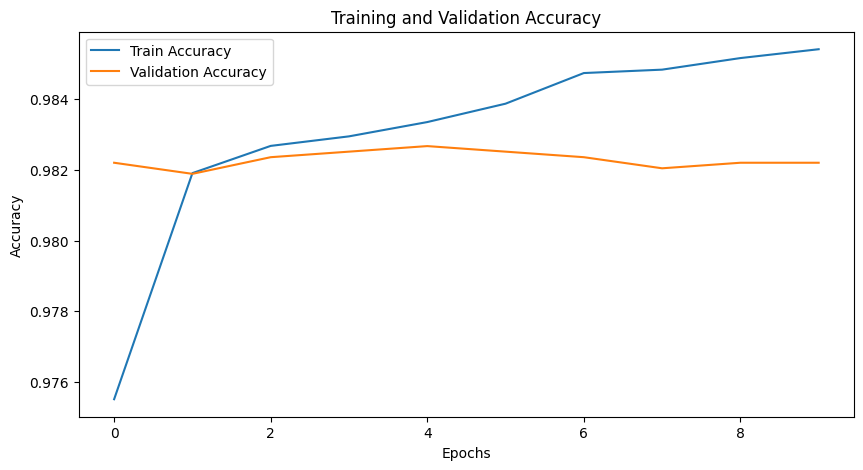

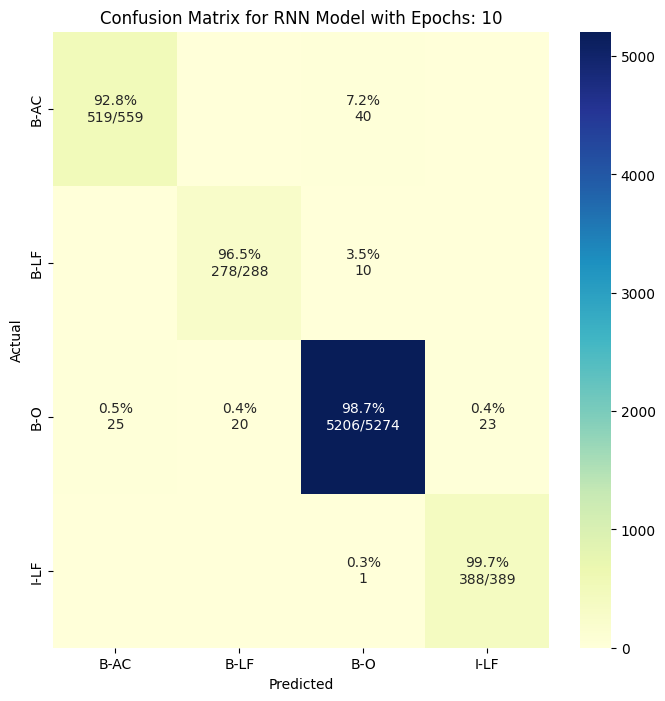

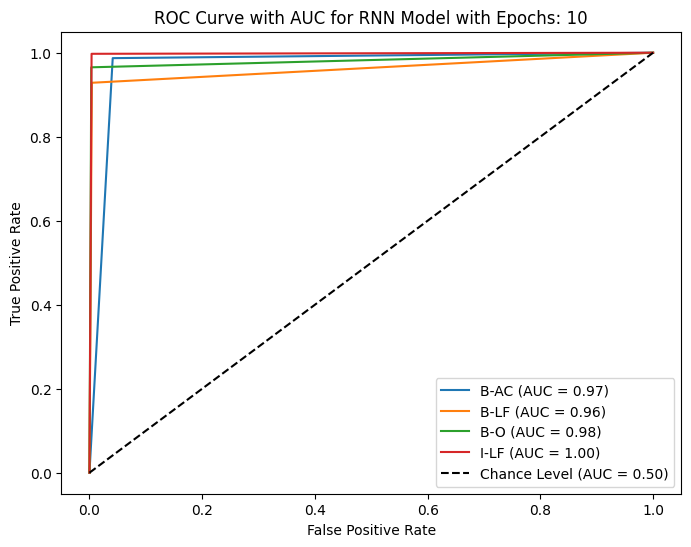

Training for Epochs: 15
Epoch: 0 | Training Loss: 0.0831   | Training Accuracy: 0.9749
Epoch: 0 | Validation Loss: 0.0670 | Validation Accuracy: 0.9819
Epoch: 1 | Training Loss: 0.0611   | Training Accuracy: 0.9819
Epoch: 1 | Validation Loss: 0.0654 | Validation Accuracy: 0.9822
Epoch: 2 | Training Loss: 0.0583   | Training Accuracy: 0.9827
Epoch: 2 | Validation Loss: 0.0633 | Validation Accuracy: 0.9825
Epoch: 3 | Training Loss: 0.0562   | Training Accuracy: 0.9830
Epoch: 3 | Validation Loss: 0.0616 | Validation Accuracy: 0.9825
Epoch: 4 | Training Loss: 0.0544   | Training Accuracy: 0.9835
Epoch: 4 | Validation Loss: 0.0601 | Validation Accuracy: 0.9830
Epoch: 5 | Training Loss: 0.0527   | Training Accuracy: 0.9839
Epoch: 5 | Validation Loss: 0.0595 | Validation Accuracy: 0.9830
Epoch: 6 | Training Loss: 0.0510   | Training Accuracy: 0.9846
Epoch: 6 | Validation Loss: 0.0593 | Validation Accuracy: 0.9824
Epoch: 7 | Training Loss: 0.0496   | Training Accuracy: 0.9849
Epoch: 7 | Valida

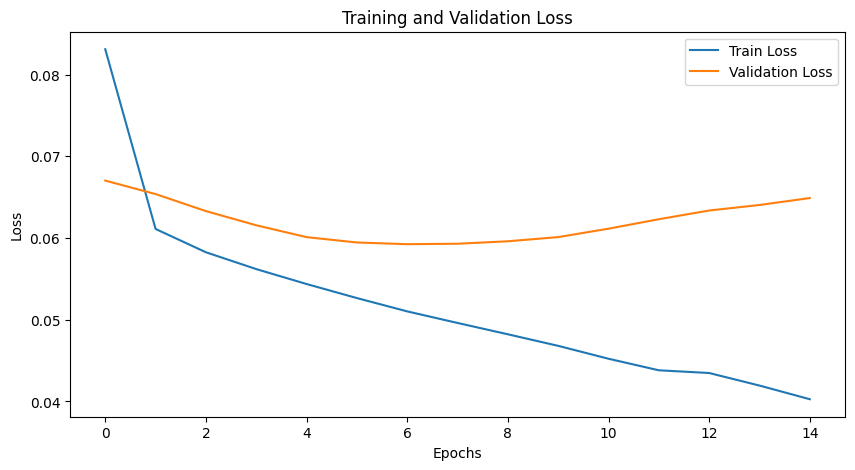

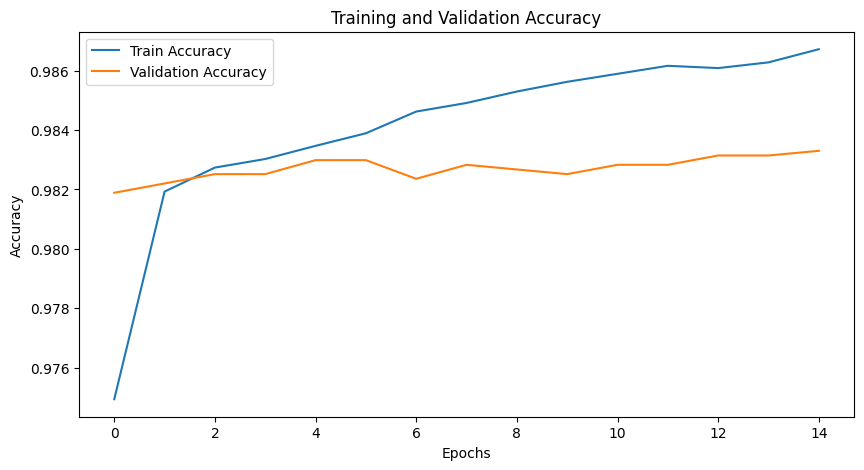

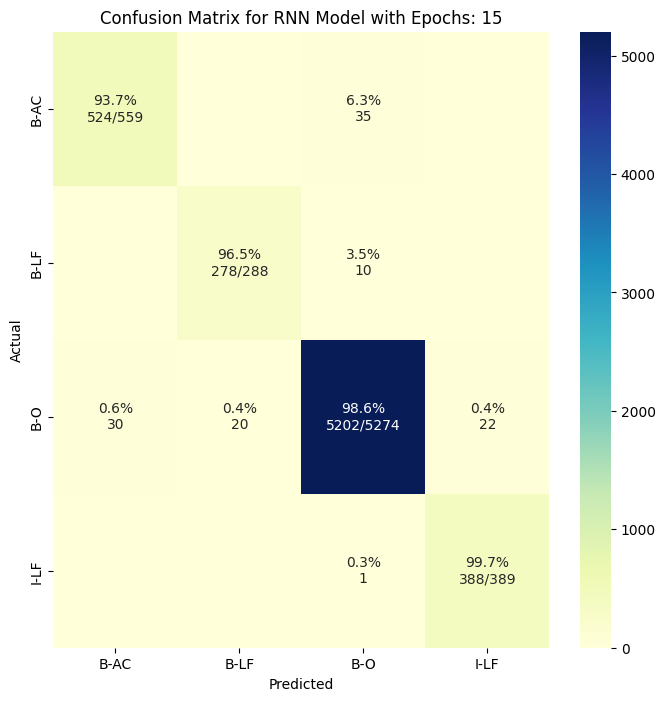

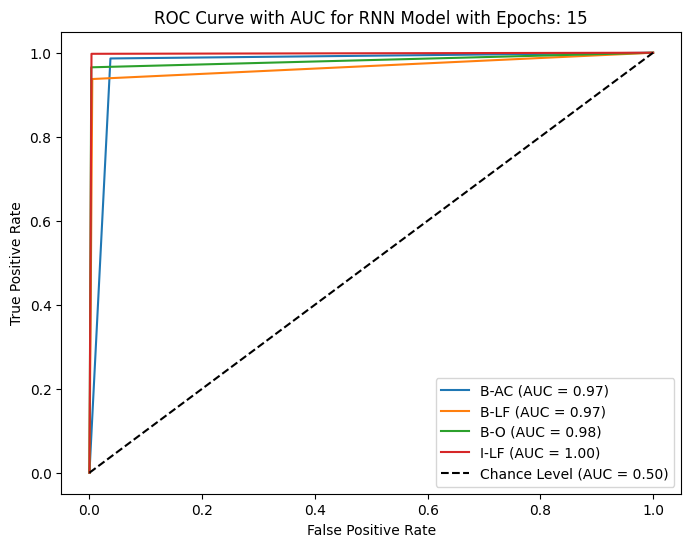

Training for Epochs: 20
Epoch: 0 | Training Loss: 0.0810   | Training Accuracy: 0.9756
Epoch: 0 | Validation Loss: 0.0682 | Validation Accuracy: 0.9820
Epoch: 1 | Training Loss: 0.0612   | Training Accuracy: 0.9818
Epoch: 1 | Validation Loss: 0.0665 | Validation Accuracy: 0.9819
Epoch: 2 | Training Loss: 0.0582   | Training Accuracy: 0.9827
Epoch: 2 | Validation Loss: 0.0637 | Validation Accuracy: 0.9822
Epoch: 3 | Training Loss: 0.0560   | Training Accuracy: 0.9831
Epoch: 3 | Validation Loss: 0.0617 | Validation Accuracy: 0.9824
Epoch: 4 | Training Loss: 0.0541   | Training Accuracy: 0.9836
Epoch: 4 | Validation Loss: 0.0604 | Validation Accuracy: 0.9825
Epoch: 5 | Training Loss: 0.0523   | Training Accuracy: 0.9841
Epoch: 5 | Validation Loss: 0.0599 | Validation Accuracy: 0.9827
Epoch: 6 | Training Loss: 0.0509   | Training Accuracy: 0.9846
Epoch: 6 | Validation Loss: 0.0596 | Validation Accuracy: 0.9828
Epoch: 7 | Training Loss: 0.0494   | Training Accuracy: 0.9848
Epoch: 7 | Valida

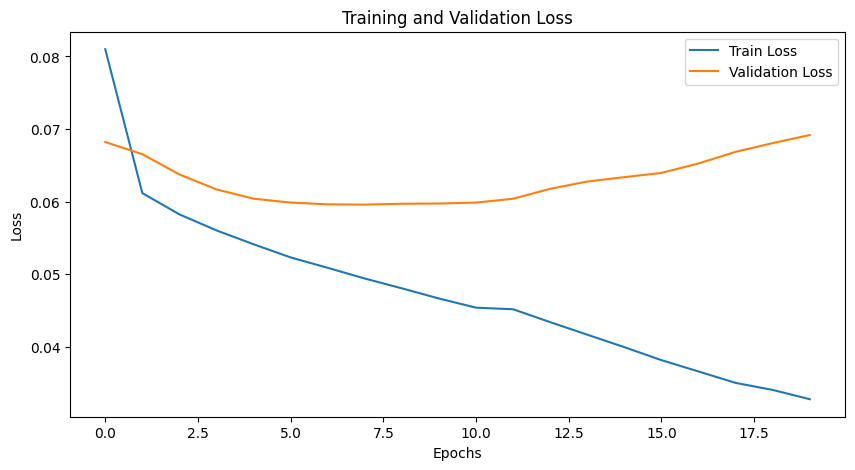

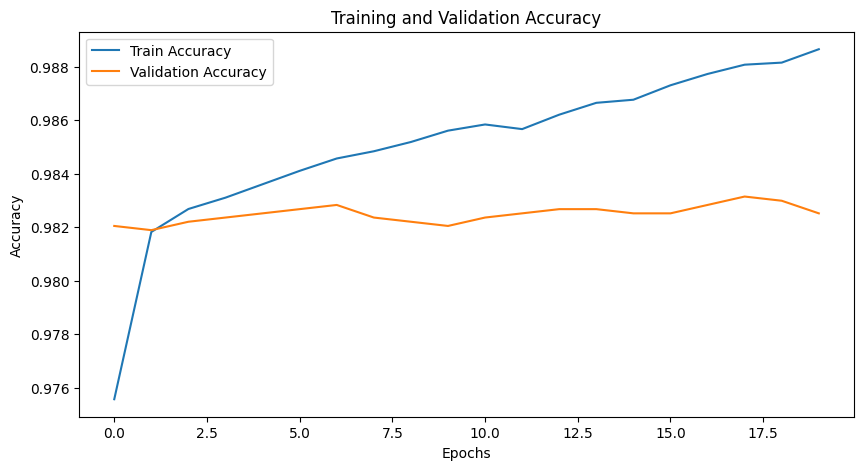

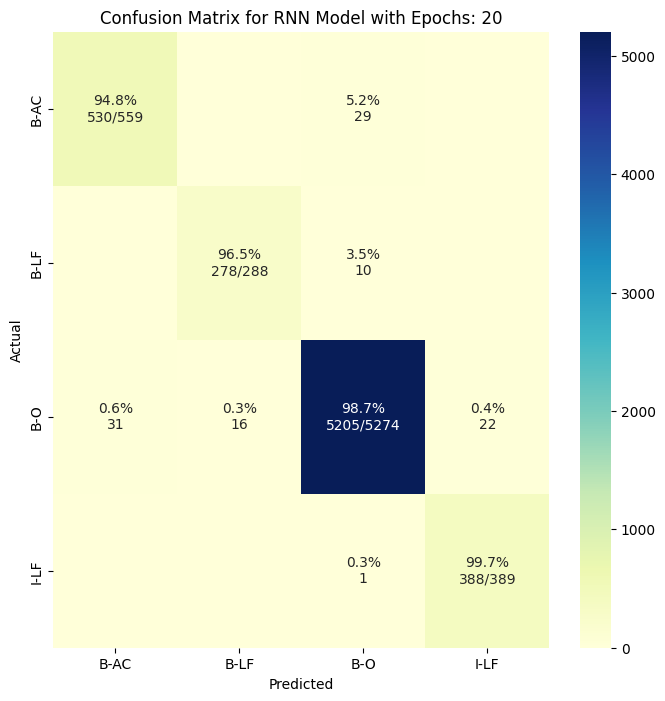

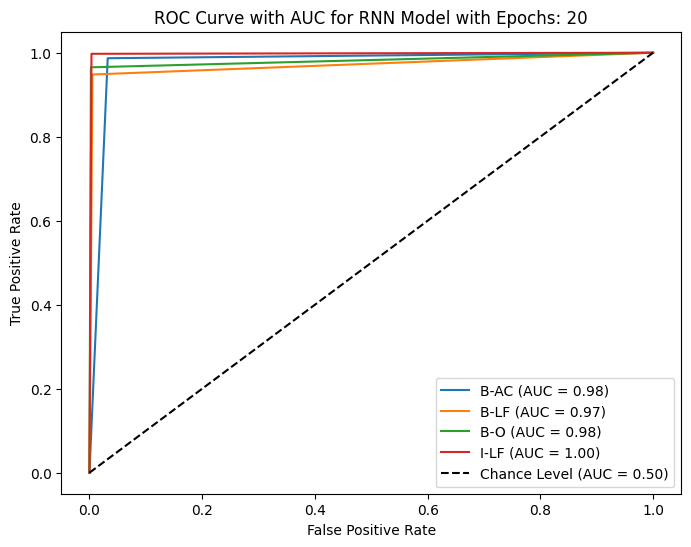

Training for Epochs: 25
Epoch: 0 | Training Loss: 0.0823   | Training Accuracy: 0.9753
Epoch: 0 | Validation Loss: 0.0680 | Validation Accuracy: 0.9816
Epoch: 1 | Training Loss: 0.0610   | Training Accuracy: 0.9819
Epoch: 1 | Validation Loss: 0.0665 | Validation Accuracy: 0.9820
Epoch: 2 | Training Loss: 0.0581   | Training Accuracy: 0.9828
Epoch: 2 | Validation Loss: 0.0640 | Validation Accuracy: 0.9824
Epoch: 3 | Training Loss: 0.0561   | Training Accuracy: 0.9831
Epoch: 3 | Validation Loss: 0.0616 | Validation Accuracy: 0.9824
Epoch: 4 | Training Loss: 0.0542   | Training Accuracy: 0.9836
Epoch: 4 | Validation Loss: 0.0600 | Validation Accuracy: 0.9827
Epoch: 5 | Training Loss: 0.0525   | Training Accuracy: 0.9839
Epoch: 5 | Validation Loss: 0.0596 | Validation Accuracy: 0.9830
Epoch: 6 | Training Loss: 0.0509   | Training Accuracy: 0.9846
Epoch: 6 | Validation Loss: 0.0595 | Validation Accuracy: 0.9825
Epoch: 7 | Training Loss: 0.0495   | Training Accuracy: 0.9847
Epoch: 7 | Valida

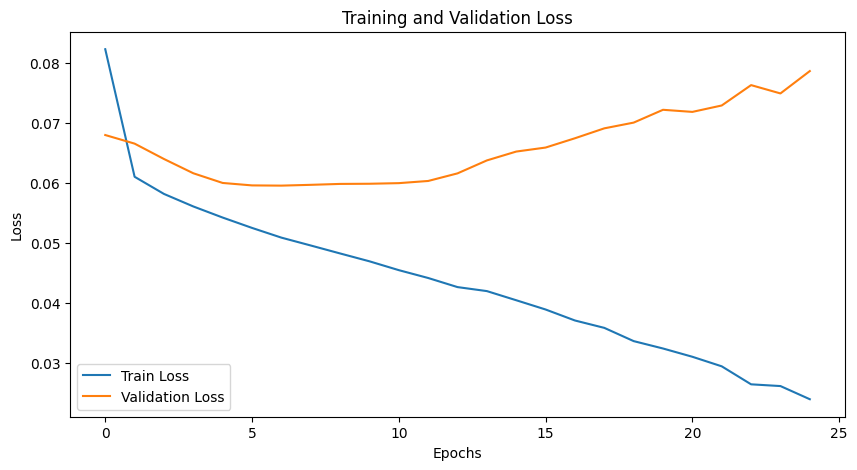

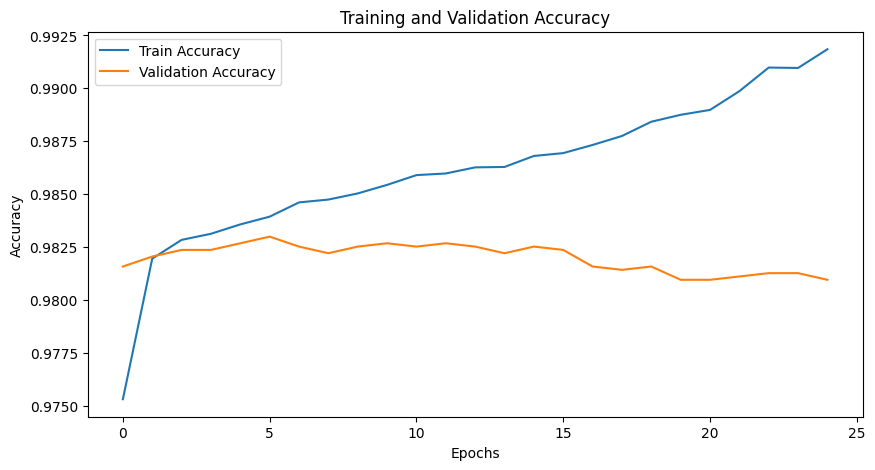

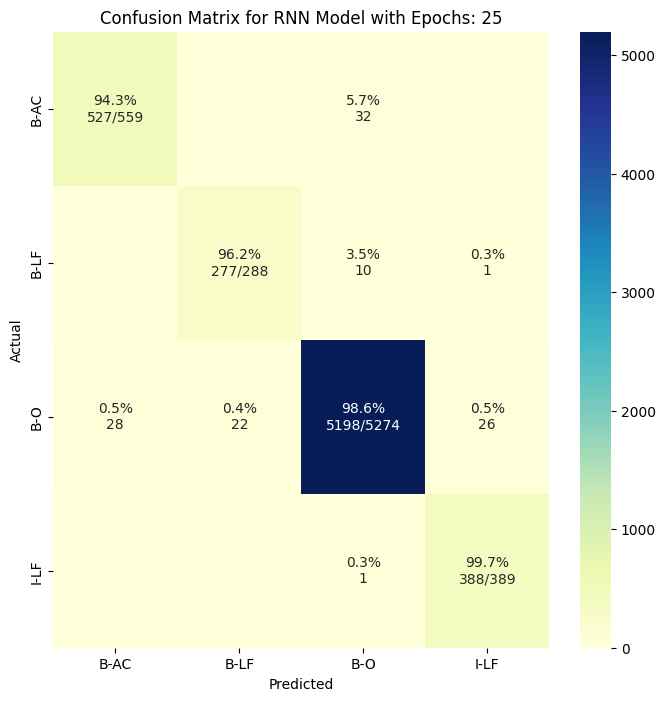

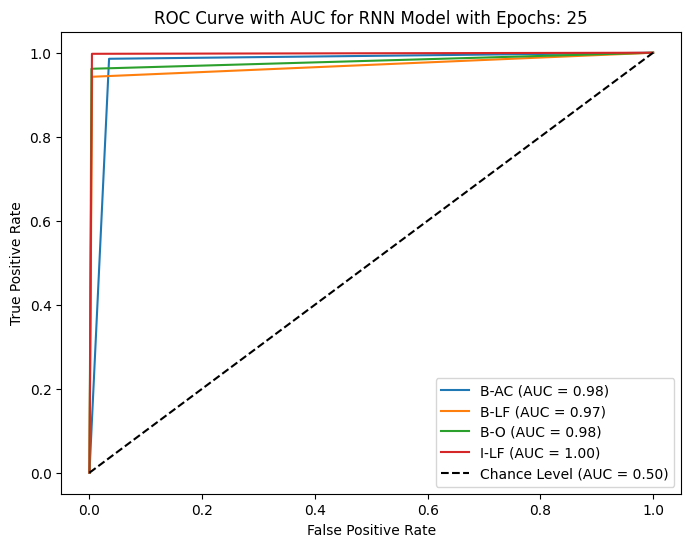

In [754]:
#Epoch Values
epoch_value = [5, 10, 15, 20, 25]
#Store the results for each epoch for plotting
epoch_result_list = []

for value in epoch_value:
    RNN_model = RNN(1024)
    print(f"Training for Epochs: {value}")
    model = train_NN(RNN_model, train_data, val_data, learning_rate= 0.0001, epochs=value, batch_size=64)
    results = get_test_results(model, test_data, f'RNN Model with Epochs: {value}')
    epoch_result_list.append(results)

Compare the results of the different epochs.

+----+---------------------+------------------+--------------+--------------------+
|    |   Overall Precision |   Overall Recall |   Overall F1 |   Overall Accuracy |
|----+---------------------+------------------+--------------+--------------------|
|  5 |            0.983262 |         0.978605 |     0.980928 |           0.980031 |
| 10 |            0.983615 |         0.980402 |     0.982006 |           0.98172  |
| 15 |            0.983617 |         0.980565 |     0.982089 |           0.981874 |
| 20 |            0.98493  |         0.982035 |     0.983481 |           0.983257 |
| 25 |            0.983773 |         0.980238 |     0.982003 |           0.981567 |
+----+---------------------+------------------+--------------+--------------------+


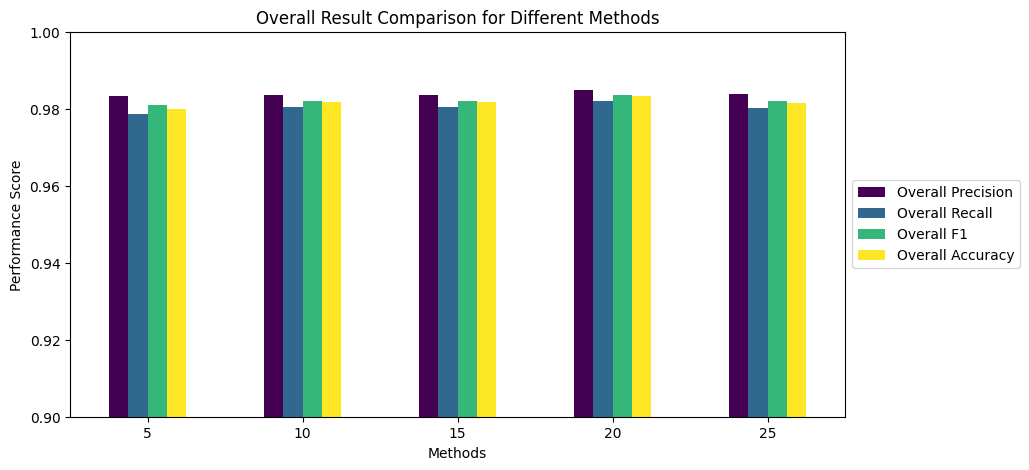

[0.9554730983302412, 0.9540441176470589, 0.9458483754512635, 0.9447415329768271, 0.9495495495495495]
+----+----------------+-------------+----------+
|    |   AC Precision |   AC Recall |    AC F1 |
|----+----------------+-------------+----------|
|  5 |       0.955473 |    0.921288 | 0.938069 |
| 10 |       0.954044 |    0.928444 | 0.94107  |
| 15 |       0.945848 |    0.937388 | 0.941599 |
| 20 |       0.944742 |    0.948122 | 0.946429 |
| 25 |       0.94955  |    0.942755 | 0.94614  |
+----+----------------+-------------+----------+


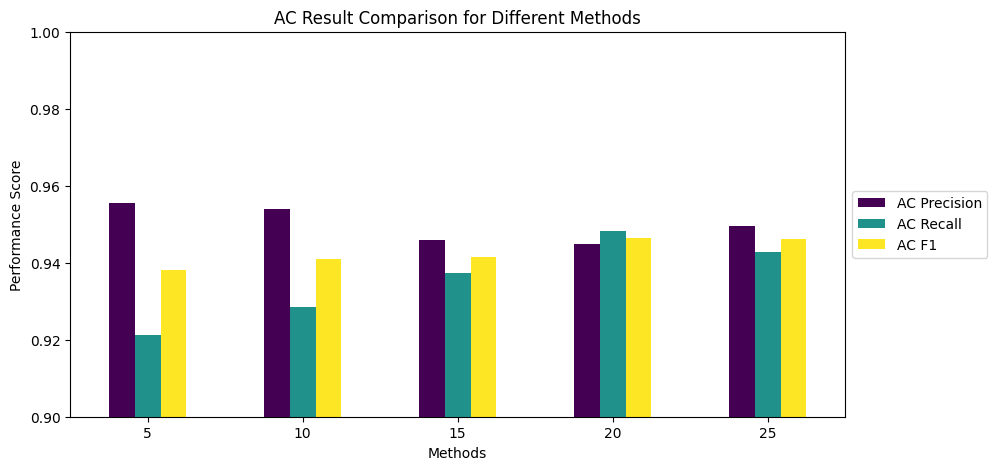

[0.9233333333333333, 0.9205298013245033, 0.9205298013245033, 0.9297658862876255, 0.9081967213114754]
+----+----------------+-------------+----------+
|    |   LF Precision |   LF Recall |    LF F1 |
|----+----------------+-------------+----------|
|  5 |       0.923333 |    0.955172 | 0.938983 |
| 10 |       0.92053  |    0.958621 | 0.939189 |
| 15 |       0.92053  |    0.958621 | 0.939189 |
| 20 |       0.929766 |    0.958621 | 0.943973 |
| 25 |       0.908197 |    0.955172 | 0.931092 |
+----+----------------+-------------+----------+


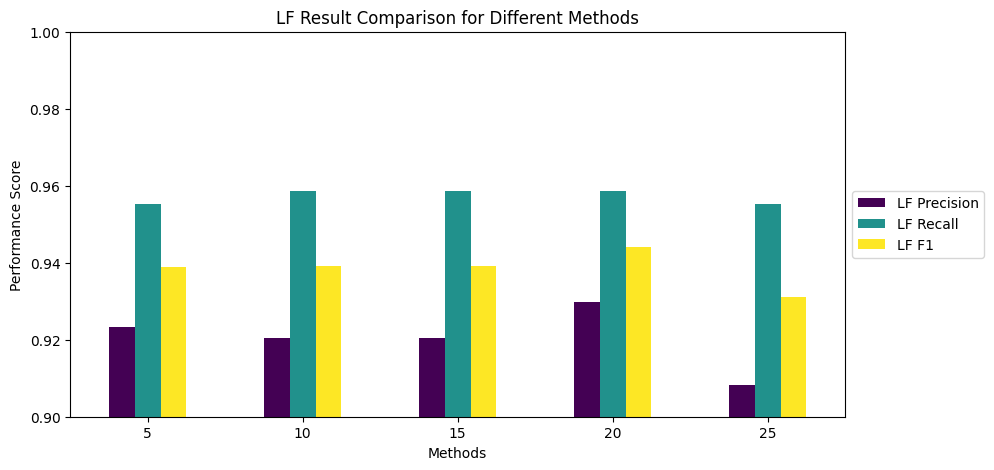

[0.9895337773549001, 0.9902986494198212, 0.991234756097561, 0.9923736892278361, 0.9917954588818928]
+----+---------------+------------+----------+
|    |   O Precision |   O Recall |     O F1 |
|----+---------------+------------+----------|
|  5 |      0.989534 |   0.985969 | 0.987748 |
| 10 |      0.990299 |   0.987107 | 0.9887   |
| 15 |      0.991235 |   0.986348 | 0.988785 |
| 20 |      0.992374 |   0.986917 | 0.989638 |
| 25 |      0.991795 |   0.98559  | 0.988683 |
+----+---------------+------------+----------+


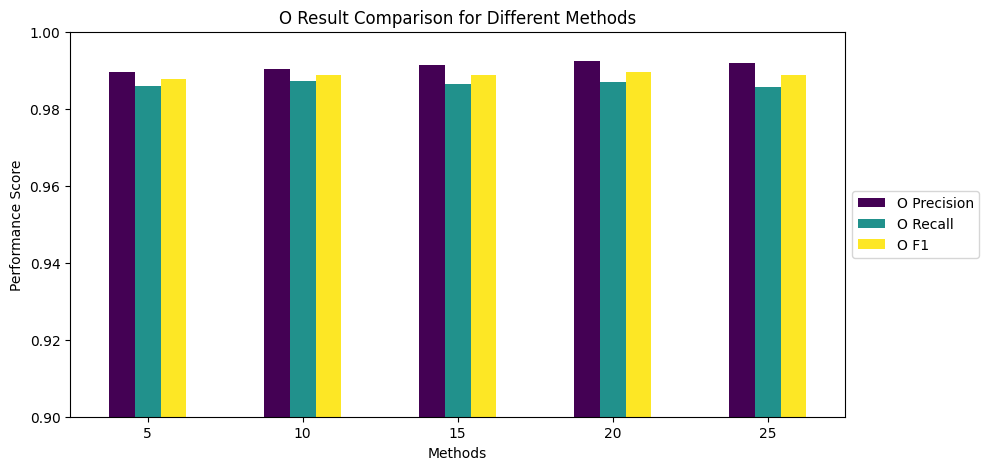

In [755]:
plot_overall_comparison(epoch_result_list, epoch_value, ylim=(0.9,1))
plot_comparison(epoch_result_list, epoch_value, 'AC', ylim=(0.9,1))
plot_comparison(epoch_result_list, epoch_value, 'LF', ylim=(0.9,1))
plot_comparison(epoch_result_list, epoch_value, 'O', ylim=(0.9,1))

## 2.4. Experiment IV: Additional Train/Validation Dataset
Test 1. PLOD-CW (40,000 Train, 5000 Val)

Test 2. PLOD-filtered - 5 times of Original (200,000 Train, 25,000 Val)

Test 3. PLOD-filtered - 10 times of Original (400,000 Train, 50,000 Val)

For this experiment, different amounts of dataset will be tested to see if any performance affects are obtained.

# Test 1. Original Dataset

The first test will be using the PLOD-CW dataset.

Epoch: 0 | Training Loss: 0.0823   | Training Accuracy: 0.9753
Epoch: 0 | Validation Loss: 0.0680 | Validation Accuracy: 0.9816
Epoch: 1 | Training Loss: 0.0610   | Training Accuracy: 0.9819
Epoch: 1 | Validation Loss: 0.0665 | Validation Accuracy: 0.9820
Epoch: 2 | Training Loss: 0.0581   | Training Accuracy: 0.9828
Epoch: 2 | Validation Loss: 0.0640 | Validation Accuracy: 0.9824
Epoch: 3 | Training Loss: 0.0561   | Training Accuracy: 0.9831
Epoch: 3 | Validation Loss: 0.0616 | Validation Accuracy: 0.9824
Epoch: 4 | Training Loss: 0.0542   | Training Accuracy: 0.9836
Epoch: 4 | Validation Loss: 0.0600 | Validation Accuracy: 0.9827
Epoch: 5 | Training Loss: 0.0525   | Training Accuracy: 0.9839
Epoch: 5 | Validation Loss: 0.0596 | Validation Accuracy: 0.9830
Epoch: 6 | Training Loss: 0.0509   | Training Accuracy: 0.9846
Epoch: 6 | Validation Loss: 0.0595 | Validation Accuracy: 0.9825
Epoch: 7 | Training Loss: 0.0495   | Training Accuracy: 0.9847
Epoch: 7 | Validation Loss: 0.0597 | Vali

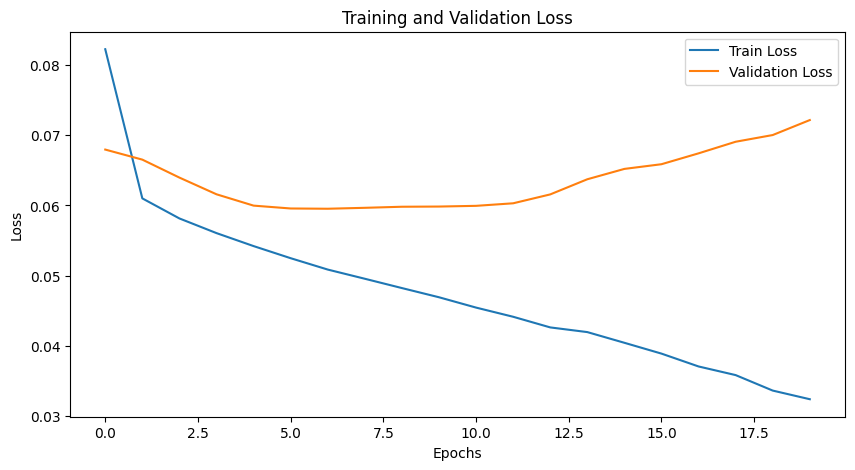

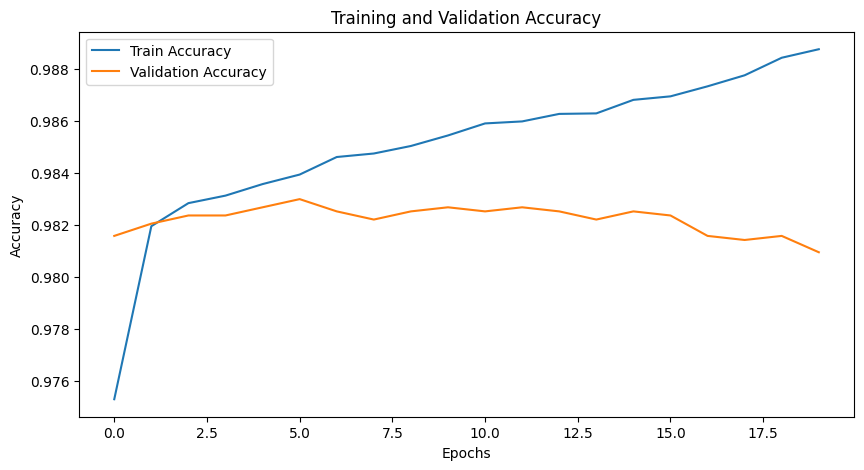

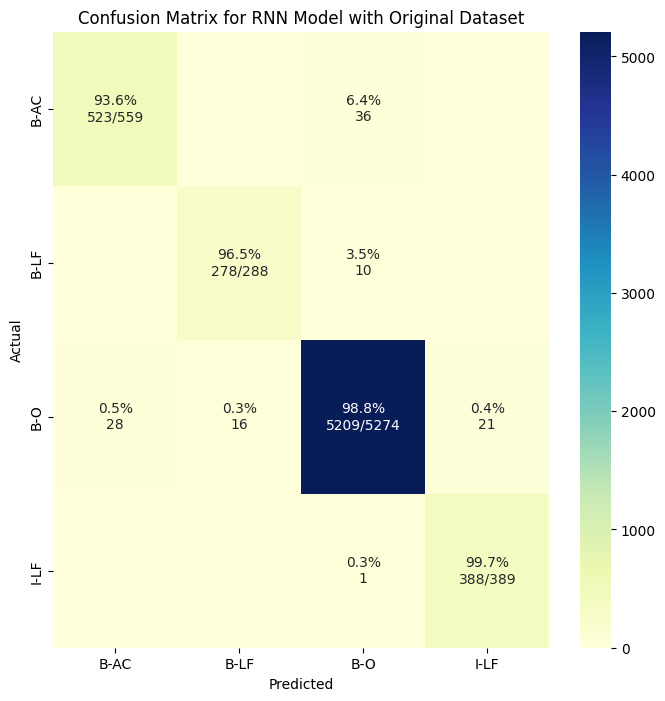

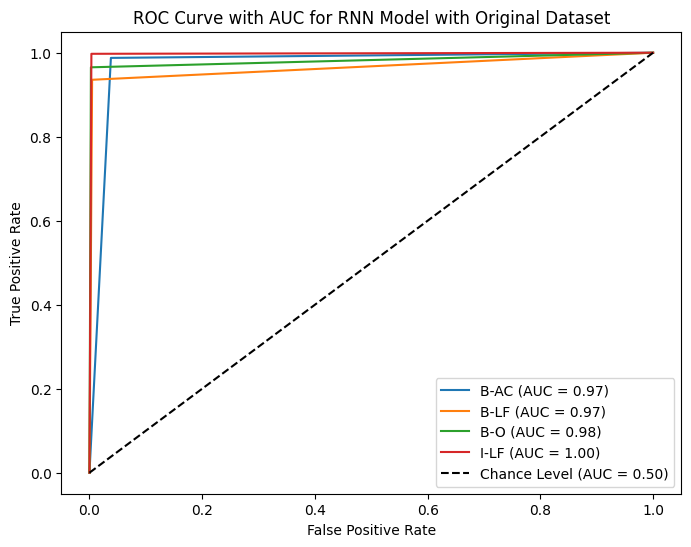

In [800]:
RNN_model = RNN(1024)
RNN_ori = train_NN(RNN_model, train_data, val_data, learning_rate=0.0001, epochs=20, batch_size=64, identifier='Original Dataset')
RNN_ori_results = get_test_results(RNN_ori, test_data, 'RNN Model with Original Dataset')


# Test 2. PLOD-filtered Dataset (200k Train, 25k Validation)

For Test 2, the PLOD-filtered dataset will be loaded and used. However, it will be filtered to a max of 200k tokens.

In [757]:
plod_filtered = load_dataset("surrey-nlp/PLOD-filtered")
plod_filtered['train'].features['ner_tags']

Generating train split:   0%|          | 0/112652 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/24140 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/24140 [00:00<?, ? examples/s]

Due to a new dataset being loaded, we will need to retokenize everything and realign the labels. This is done below.

In [761]:
#Tokenization Code obtained from https://github.com/surrey-nlp/PLOD-AbbreviationDetection/blob/main/nbs/fine_tuning_abbr_det.ipynb 
label_all_tokens = True
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True) ## For some models, you may need to set max_length to approximately 500.

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

Here, we only select 10000 rows from the PLOD-filtered dataset for tokenization. This is because the dataset is signifcantly massive, so only a portion of dataset is used to save time.

In [768]:
#Tokenize the first 20k rows of the PLOD-filtered dataset
tokenized_plod_train = tokenize_and_align_labels(plod_filtered["train"][:10000])
tokenized_plod_val = tokenize_and_align_labels(plod_filtered["validation"][:1200])

In [770]:
print('Vectorizing PLOD Train')
vectorized_plod_train = [RobBERTa_model(torch.tensor(row).unsqueeze(0)).logits.detach().squeeze() for row in tokenized_plod_train['input_ids']]
print('Vectorizing PLOD Validation')
vectorized_plod_val = [RobBERTa_model(torch.tensor(row).unsqueeze(0)).logits.detach().squeeze() for row in tokenized_plod_val['input_ids']]

Vectorizing PLOD Train


Vectorizing PLOD Validation


The function below will filter out the additional I-AC label from the PLOD-filtered dataset. It will also reassign the classes with the correct class.

In [771]:
def flatten_dataset(input_data, input_label, data_length):
  flatten_tokens,flatten_labels = [],[]
  for token_list,label_list in zip(input_data,input_label):
    for tokens,labels in zip(token_list,label_list):
      # This part will filter the unknown token
      if labels != -100:
        # This part will filter the I-AC tokens
        if labels != 2:
          flatten_tokens.append(tokens)
          if labels == 3:
            flatten_labels.append(2)
          elif labels == 4:
            flatten_labels.append(3)
          else:
            flatten_labels.append(labels)
        if len(flatten_tokens) == data_length:
          return flatten_tokens, flatten_labels

In [786]:
plod_train_token_200k,plod_train_label_200k  = flatten_dataset(vectorized_plod_train,tokenized_plod_train['labels'],200000)
plod_val_token_200k,plod_val_label_200k  = flatten_dataset(vectorized_plod_val,tokenized_plod_val['labels'],25000)

In [787]:
train_200k = [(tokens, labels) for tokens, labels in zip(plod_train_token_200k, plod_train_label_200k)]
val_200k = [(tokens, labels) for tokens, labels in zip(plod_val_token_200k, plod_val_label_200k)]

Epoch: 0 | Training Loss: 0.0726   | Training Accuracy: 0.9762
Epoch: 0 | Validation Loss: 0.0719 | Validation Accuracy: 0.9770
Epoch: 1 | Training Loss: 0.0647   | Training Accuracy: 0.9780
Epoch: 1 | Validation Loss: 0.0661 | Validation Accuracy: 0.9784
Epoch: 2 | Training Loss: 0.0631   | Training Accuracy: 0.9785
Epoch: 2 | Validation Loss: 0.0641 | Validation Accuracy: 0.9786
Epoch: 3 | Training Loss: 0.0617   | Training Accuracy: 0.9788
Epoch: 3 | Validation Loss: 0.0626 | Validation Accuracy: 0.9790
Epoch: 4 | Training Loss: 0.0608   | Training Accuracy: 0.9792
Epoch: 4 | Validation Loss: 0.0616 | Validation Accuracy: 0.9794
Epoch: 5 | Training Loss: 0.0598   | Training Accuracy: 0.9795
Epoch: 5 | Validation Loss: 0.0610 | Validation Accuracy: 0.9794
Epoch: 6 | Training Loss: 0.0590   | Training Accuracy: 0.9798
Epoch: 6 | Validation Loss: 0.0607 | Validation Accuracy: 0.9795
Epoch: 7 | Training Loss: 0.0581   | Training Accuracy: 0.9799
Epoch: 7 | Validation Loss: 0.0601 | Vali

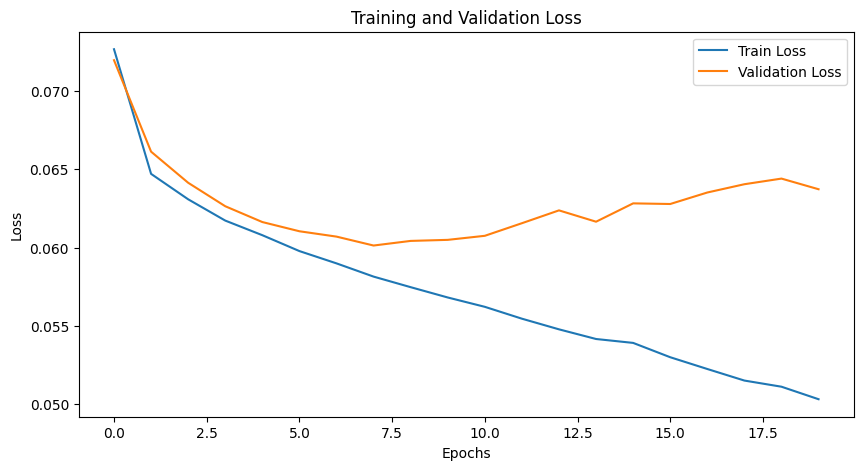

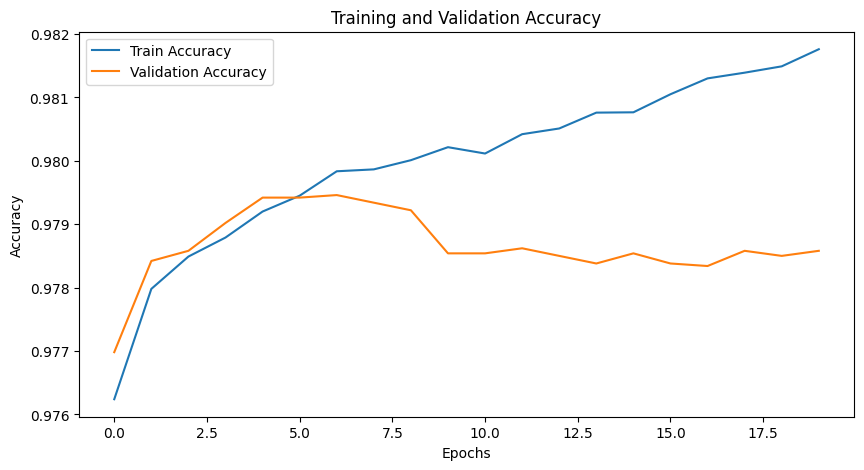

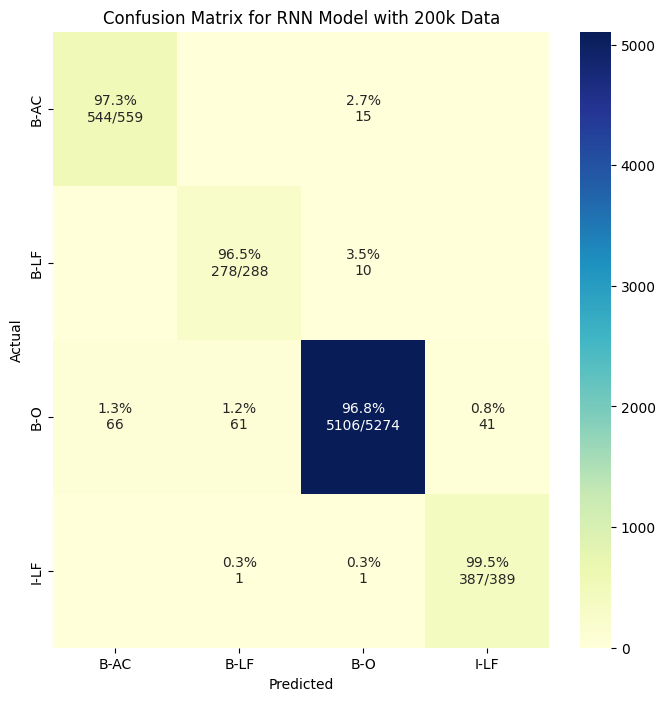

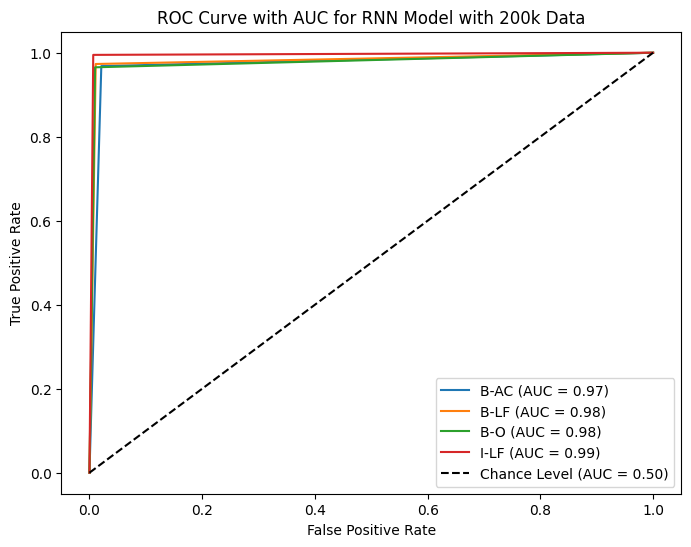

In [789]:
RNN_model = RNN(1024)
RNN_200k_trained_model = train_NN(RNN_model, train_200k, val_200k, learning_rate=0.0001, epochs=20, batch_size=64, identifier='RNN_200k')
RNN_200k_results = get_test_results(RNN_200k_trained_model, test_data, 'RNN Model with 200k Data')

# Test 3. PLOD-filtered Dataset (400k Train, 50k Validation)

In [776]:
plod_train_token_400k,plod_train_label_400k  = flatten_dataset(vectorized_plod_train,tokenized_plod_train['labels'],400000)
plod_val_token_400k,plod_val_label_400k  = flatten_dataset(vectorized_plod_val,tokenized_plod_val['labels'],50000)

In [777]:
train_400k = [(tokens, labels) for tokens, labels in zip(plod_train_token_400k, plod_train_label_400k)]
val_400k = [(tokens, labels) for tokens, labels in zip(plod_val_token_400k, plod_val_label_400k)]

Epoch: 0 | Training Loss: 0.0686   | Training Accuracy: 0.9778
Epoch: 0 | Validation Loss: 0.0618 | Validation Accuracy: 0.9803
Epoch: 1 | Training Loss: 0.0629   | Training Accuracy: 0.9788
Epoch: 1 | Validation Loss: 0.0585 | Validation Accuracy: 0.9812
Epoch: 2 | Training Loss: 0.0609   | Training Accuracy: 0.9795
Epoch: 2 | Validation Loss: 0.0578 | Validation Accuracy: 0.9812
Epoch: 3 | Training Loss: 0.0602   | Training Accuracy: 0.9796
Epoch: 3 | Validation Loss: 0.0575 | Validation Accuracy: 0.9813
Epoch: 4 | Training Loss: 0.0596   | Training Accuracy: 0.9797
Epoch: 4 | Validation Loss: 0.0576 | Validation Accuracy: 0.9811
Epoch: 5 | Training Loss: 0.0588   | Training Accuracy: 0.9799
Epoch: 5 | Validation Loss: 0.0574 | Validation Accuracy: 0.9813
Epoch: 6 | Training Loss: 0.0581   | Training Accuracy: 0.9802
Epoch: 6 | Validation Loss: 0.0574 | Validation Accuracy: 0.9815
Epoch: 7 | Training Loss: 0.0575   | Training Accuracy: 0.9803
Epoch: 7 | Validation Loss: 0.0575 | Vali

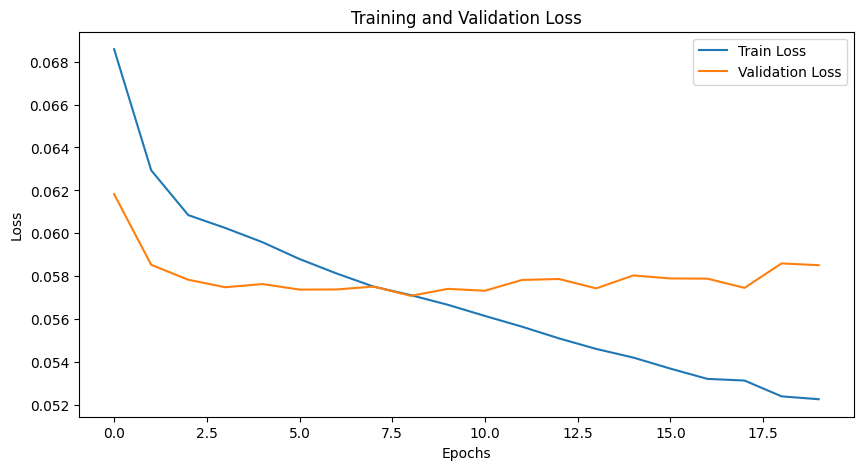

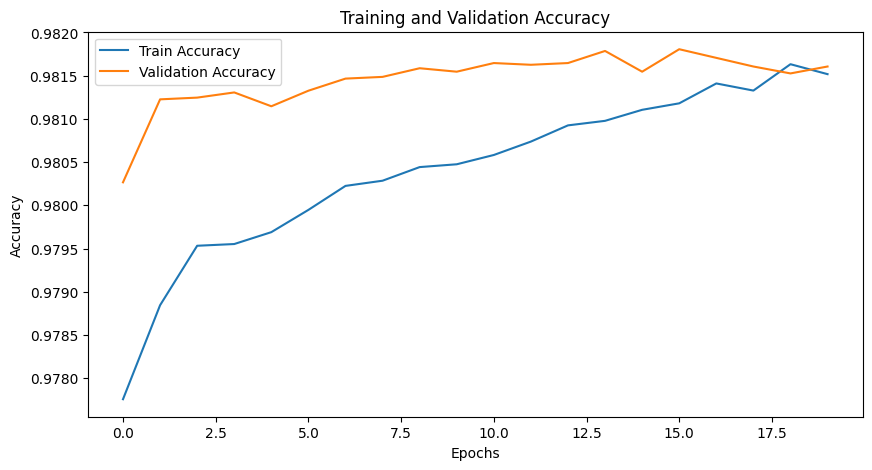

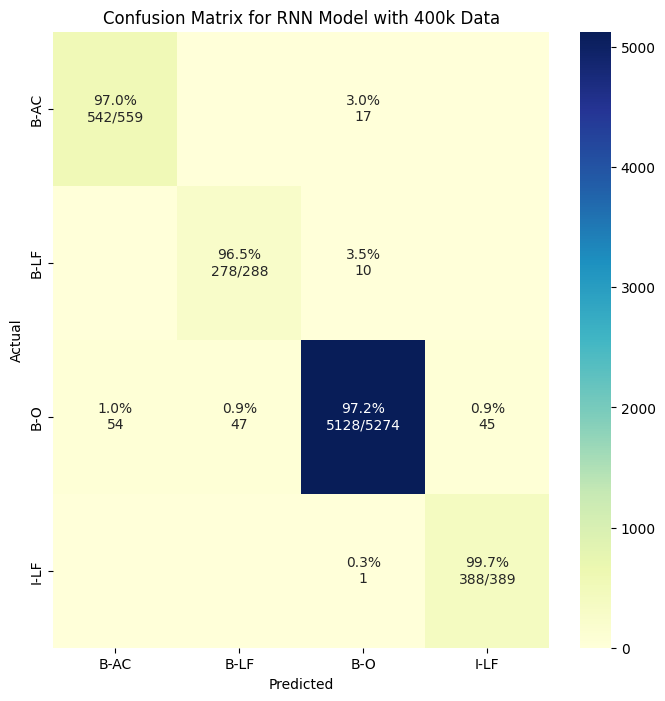

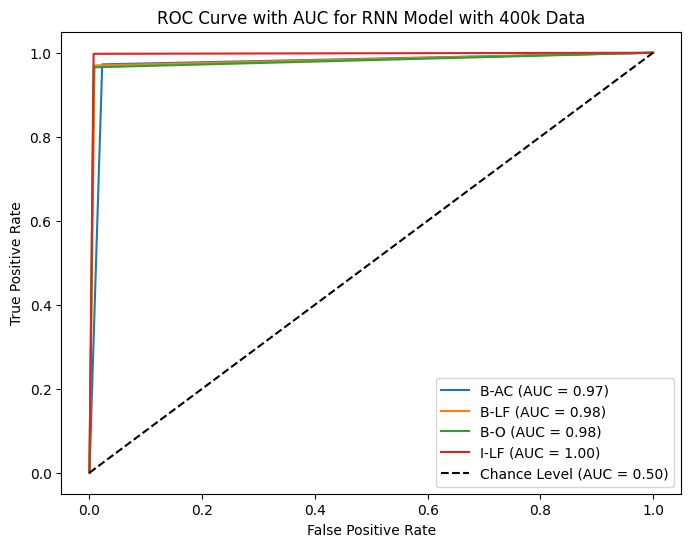

In [791]:
RNN_model = RNN(1024)
RNN_400k_trained_model = train_NN(RNN_model, train_400k, val_400k, learning_rate=0.0001, epochs=20, batch_size=64, identifier='RNN_400k')
RNN_400k_results = get_test_results(RNN_400k_trained_model, test_data, 'RNN Model with 400k Data')

# Additonal Test: PLOD Filtered 400k at 8 epochs

Epoch: 0 | Training Loss: 0.0685   | Training Accuracy: 0.9778
Epoch: 0 | Validation Loss: 0.0613 | Validation Accuracy: 0.9803
Epoch: 1 | Training Loss: 0.0629   | Training Accuracy: 0.9789
Epoch: 1 | Validation Loss: 0.0586 | Validation Accuracy: 0.9812
Epoch: 2 | Training Loss: 0.0613   | Training Accuracy: 0.9794
Epoch: 2 | Validation Loss: 0.0577 | Validation Accuracy: 0.9812
Epoch: 3 | Training Loss: 0.0601   | Training Accuracy: 0.9797
Epoch: 3 | Validation Loss: 0.0576 | Validation Accuracy: 0.9813
Epoch: 4 | Training Loss: 0.0594   | Training Accuracy: 0.9798
Epoch: 4 | Validation Loss: 0.0573 | Validation Accuracy: 0.9811
Epoch: 5 | Training Loss: 0.0587   | Training Accuracy: 0.9800
Epoch: 5 | Validation Loss: 0.0575 | Validation Accuracy: 0.9814
Epoch: 6 | Training Loss: 0.0583   | Training Accuracy: 0.9801
Epoch: 6 | Validation Loss: 0.0574 | Validation Accuracy: 0.9815
Epoch: 7 | Training Loss: 0.0576   | Training Accuracy: 0.9803
Epoch: 7 | Validation Loss: 0.0576 | Vali

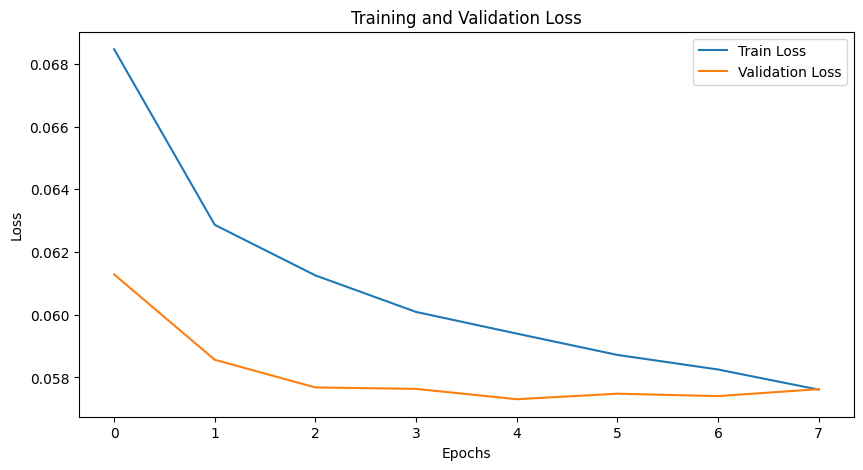

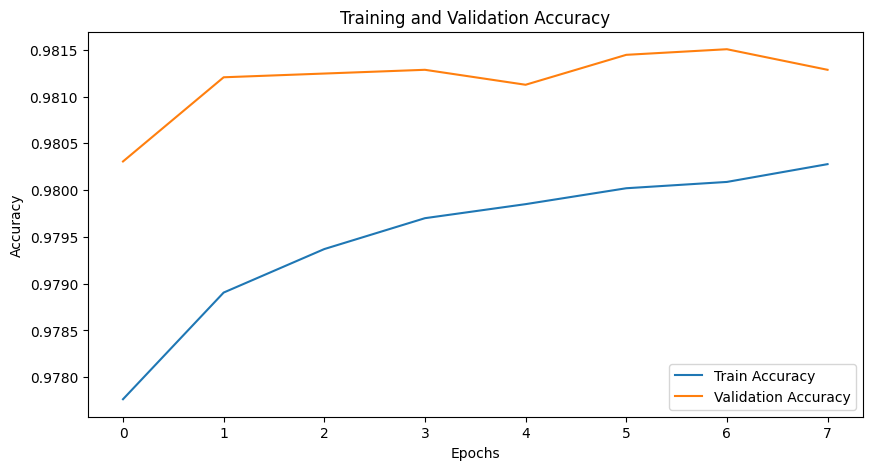

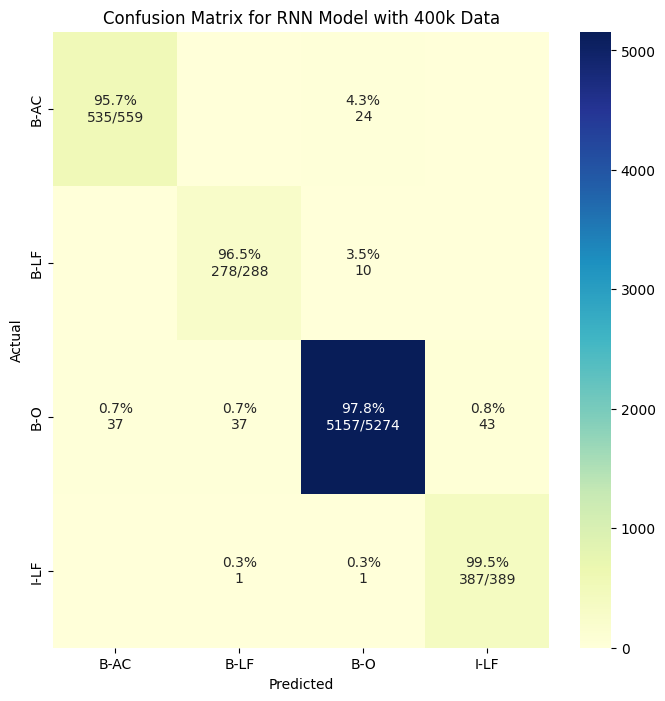

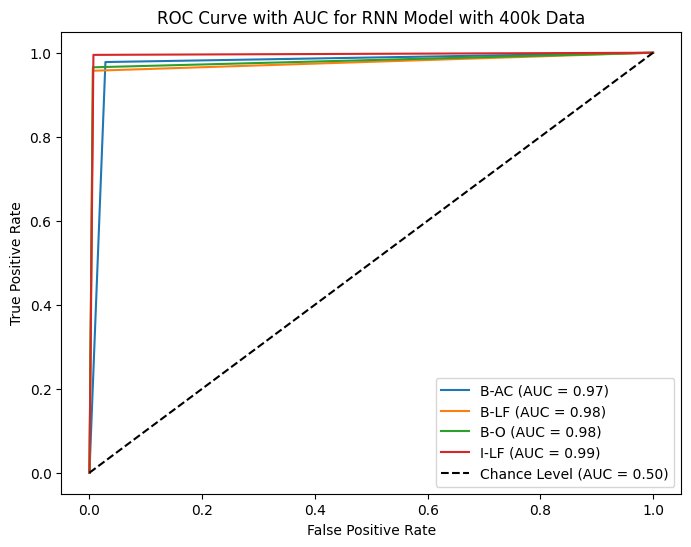

In [792]:
RNN_model = RNN(1024)
RNN_400k_trained_model_8ep = train_NN(RNN_model, train_400k, val_400k, learning_rate=0.0001, epochs=8, batch_size=64, identifier='RNN_400k')
RNN_400k_results_8ep = get_test_results(RNN_400k_trained_model_8ep, test_data, 'RNN Model with 400k Data')

# Compare the first 3 Main Tests

+------------------+---------------------+------------------+--------------+--------------------+
|                  |   Overall Precision |   Overall Recall |   Overall F1 |   Overall Accuracy |
|------------------+---------------------+------------------+--------------+--------------------|
| Original Dataset |            0.984117 |         0.981545 |     0.982829 |           0.982796 |
| 200k Data        |            0.973714 |         0.96799  |     0.970844 |           0.970046 |
| 400k Data        |            0.977    |         0.971256 |     0.97412  |           0.973272 |
+------------------+---------------------+------------------+--------------+--------------------+


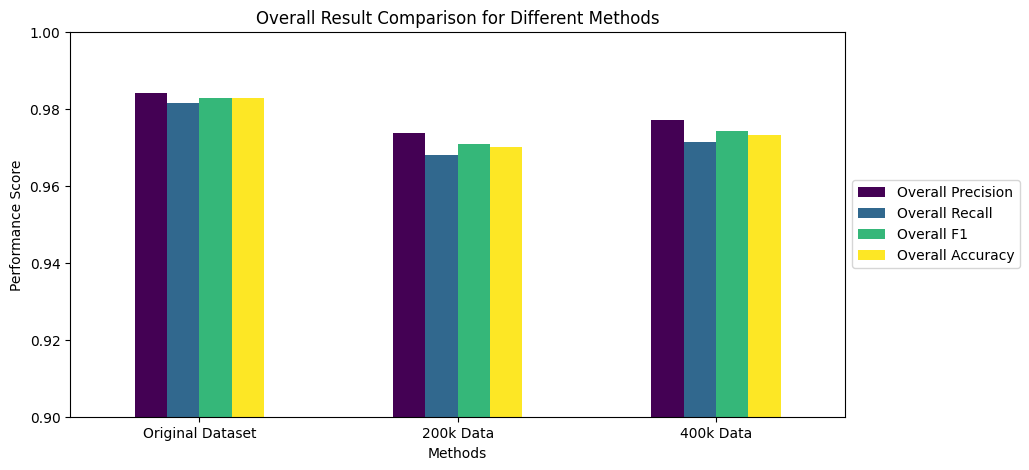

[0.9491833030852994, 0.8918032786885246, 0.9093959731543624]
+------------------+----------------+-------------+----------+
|                  |   AC Precision |   AC Recall |    AC F1 |
|------------------+----------------+-------------+----------|
| Original Dataset |       0.949183 |    0.935599 | 0.942342 |
| 200k Data        |       0.891803 |    0.973166 | 0.93071  |
| 400k Data        |       0.909396 |    0.969589 | 0.938528 |
+------------------+----------------+-------------+----------+


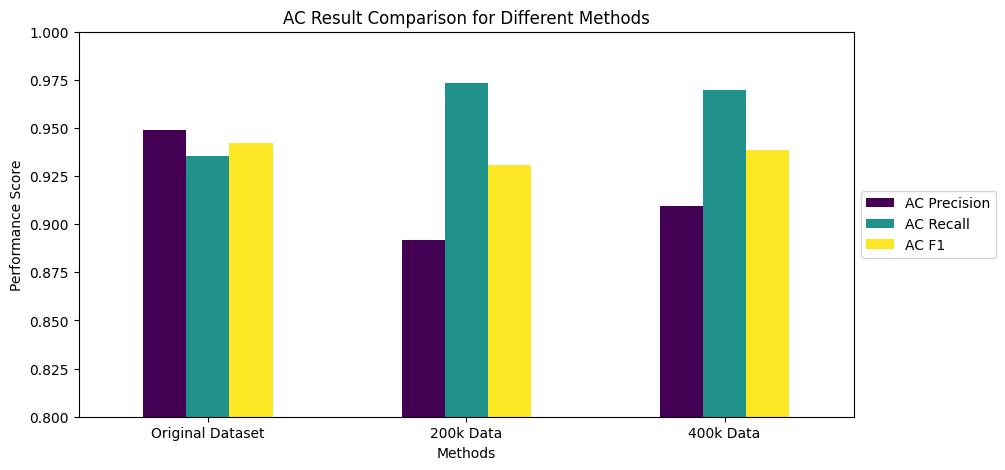

[0.9266666666666666, 0.8028985507246377, 0.826865671641791]
+------------------+----------------+-------------+----------+
|                  |   LF Precision |   LF Recall |    LF F1 |
|------------------+----------------+-------------+----------|
| Original Dataset |       0.926667 |    0.958621 | 0.942373 |
| 200k Data        |       0.802899 |    0.955172 | 0.872441 |
| 400k Data        |       0.826866 |    0.955172 | 0.8864   |
+------------------+----------------+-------------+----------+


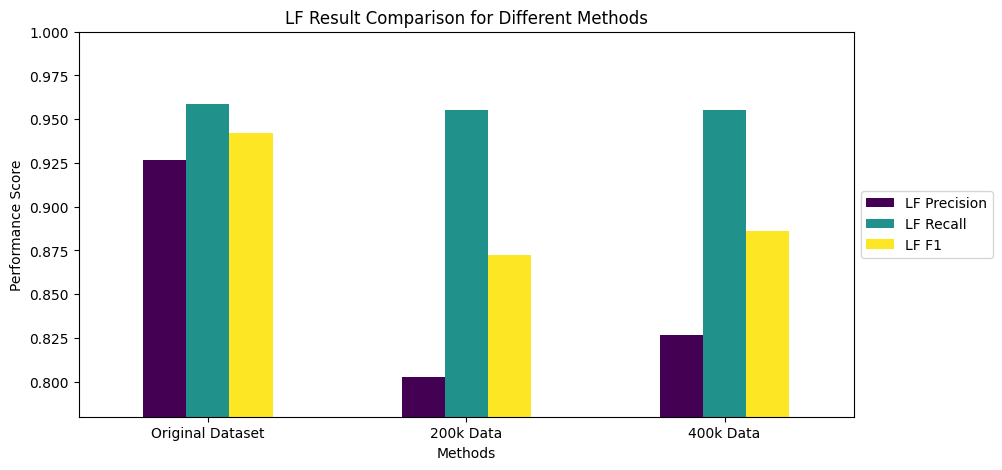

[0.9910578386605784, 0.994933749025721, 0.9945694336695112]
+------------------+---------------+------------+----------+
|                  |   O Precision |   O Recall |     O F1 |
|------------------+---------------+------------+----------|
| Original Dataset |      0.991058 |   0.987675 | 0.989364 |
| 200k Data        |      0.994934 |   0.968146 | 0.981357 |
| 400k Data        |      0.994569 |   0.972317 | 0.983317 |
+------------------+---------------+------------+----------+


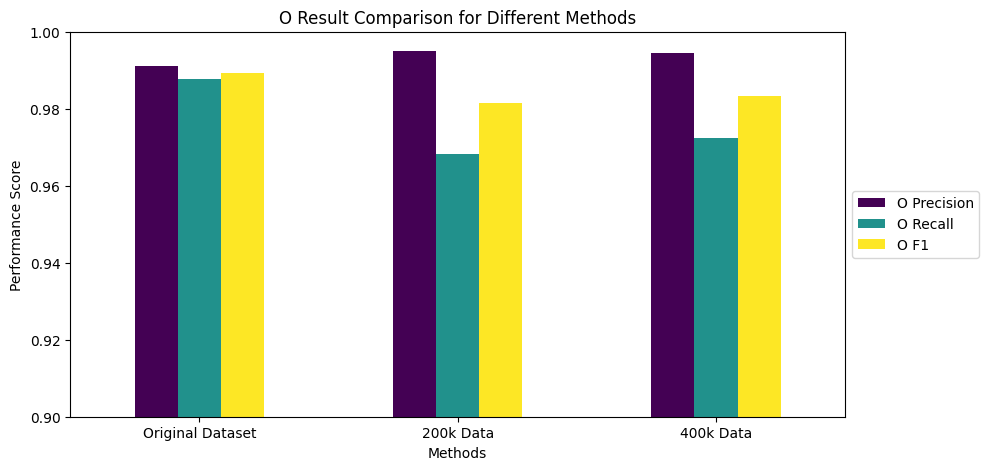

In [818]:
methods = [RNN_ori_results, RNN_200k_results, RNN_400k_results]
names = ['Original Dataset', '200k Data', '400k Data']
plot_overall_comparison(methods, names, ylim=(0.9,1))
plot_comparison(methods, names, 'AC', ylim=(0.8,1))
plot_comparison(methods, names, 'LF', ylim=(0.78,1))
plot_comparison(methods, names, 'O', ylim=(0.9,1))


## Other Additional Experiments

# Training Logistic Regression on Extra Dataset 400k

Here, an additional experiment will be to train a logistic regression model with extra dataset. The hope is that this can help improve the model.

In [839]:
label_dict = {0: "B-O", 1: "B-LF", 2: "B-AC", 3: "I-LF"}

#Convert the tokens into numpy arrays from Tensor
plod_train_token_400k_np = [np.array(token) for token in plod_train_token_400k]
#Convert the labels from numbers to label names
plod_train_label_400k_str = [label_dict[token] for token in plod_train_label_400k]

#Do the same for the Test dataset
test_data_token = [np.array(token) for token, _ in test_data]
test_data_label = [label_dict[token] for _, token in test_data]

c:\Users\Jian He\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution Time: 516.52 seconds

Classification Report

              precision    recall  f1-score   support

        B-AC       0.84      0.97      0.90       288
        B-LF       0.87      0.95      0.91       559
         B-O       0.99      0.96      0.98      5274
        I-LF       0.87      0.99      0.93       389

    accuracy                           0.97      6510
   macro avg       0.89      0.97      0.93      6510
weighted avg       0.97      0.97      0.97      6510

+----+-------------+----------+----------+----------+
|    |   precision |   recall |       f1 |   number |
|----+-------------+----------+----------+----------|
| AC |    0.844985 | 0.965278 | 0.901135 |      288 |
| LF |    0.856955 | 0.951895 | 0.901934 |      686 |
| O  |    0.992782 | 0.964922 | 0.978654 |     5274 |
+----+-------------+----------+----------+----------+
+-------------------+----------+
| Overall Precision | 0.968313 |
| Overall Recall    | 0.963508 |
| Overall F1        | 0.965905 |


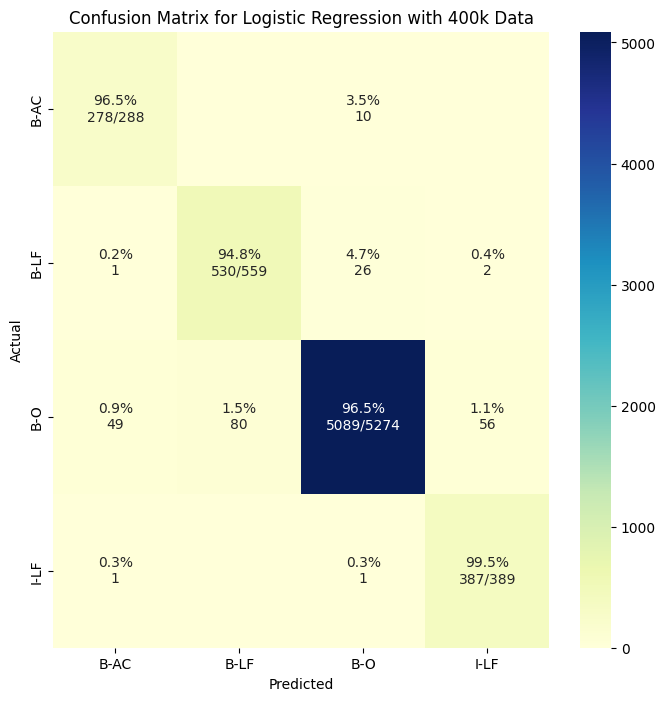

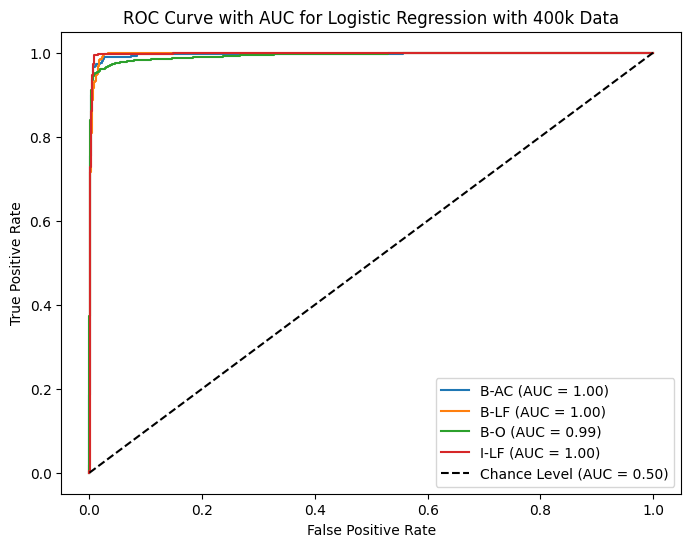

In [840]:
logistic_400 = train_and_eval(plod_train_token_400k_np, test_data_token, plod_train_label_400k_str, test_data_label, 'Logistic Regression with 400k Data')

# Altering RoBERTa model, and training logistic regression

Here, the additional experiment is to change the RoBERTa model to a newly tuned model. The hope is that the larger model would have a better vector representation that would help in performance.

In [841]:
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
import transformers

#Here the new model checkpoint is loaded
new_model_checkpoint = "surrey-nlp/roberta-large-finetuned-abbr-unfiltered-plod"
#Initialize the tokenizer with the new pretrained model check point
new_tokenizer = AutoTokenizer.from_pretrained(new_model_checkpoint, add_prefix_space=True)
assert isinstance(new_tokenizer, transformers.PreTrainedTokenizerFast)


label_all_tokens = True
#Tokenization code obtained from https://github.com/surrey-nlp/NLP-2024/blob/main/lab06/BERT-finetuning.ipynb 
def tokenize_and_align_labels(short_dataset, list_name):
    tokenized_inputs = new_tokenizer(short_dataset["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(list_name):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = tokenize_and_align_labels(datasets["train"], label_list)
tokenized_val_datasets = tokenize_and_align_labels(datasets["validation"], val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(datasets["test"], test_label_list)

tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\Jian He\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jian He\.cache\huggingface\hub\models--surrey-nlp--roberta-large-finetuned-abbr-unfiltered-plod. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [842]:
#Initialize the model with the pretrained model check point
new_RobBERTa_model = AutoModelForTokenClassification.from_pretrained(new_model_checkpoint, num_labels=5)

#Set the classifier to Identity to get the word embeddings
new_RobBERTa_model.classifier = torch.nn.Identity()


train_vec_tokens = [new_RobBERTa_model(torch.tensor(row).unsqueeze(0)).logits.detach().squeeze().numpy() for row in tokenized_datasets['input_ids']]
test_vec_tokens = [new_RobBERTa_model(torch.tensor(row).unsqueeze(0)).logits.detach().squeeze().numpy() for row in tokenized_test_datasets['input_ids']]

config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [843]:
reverse_label_encoding = {0: "B-O", 1: "B-AC", 2: "B-LF", 3: "I-LF", -100: "Unknown"}
flatten_train_vec_tokens = [item for sublist in train_vec_tokens for item in sublist]
flatten_test_vec_tokens = [item for sublist in test_vec_tokens for item in sublist]
flatten_train_labels = [reverse_label_encoding[item] for sublist in tokenized_datasets['labels'] for item in sublist]
flatten_test_labels = [reverse_label_encoding[item] for sublist in tokenized_test_datasets['labels'] for item in sublist]

def remove_unknown_tokens(tokens, labels):
    new_tokens, new_labels = [], []
    for token,label in zip(tokens,labels):
        if label != 'Unknown':
            new_tokens.append(token)
            new_labels.append(label)
    return new_tokens, new_labels

flatten_train_vec_tokens, flatten_train_labels = remove_unknown_tokens(flatten_train_vec_tokens, flatten_train_labels)
flatten_test_vec_tokens, flatten_test_labels = remove_unknown_tokens(flatten_test_vec_tokens, flatten_test_labels)

c:\Users\Jian He\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution Time: 61.69 seconds

Classification Report

              precision    recall  f1-score   support

        B-AC       0.91      0.94      0.92       559
        B-LF       0.90      0.93      0.91       288
         B-O       0.99      0.98      0.98      5274
        I-LF       0.88      0.96      0.92       389

    accuracy                           0.97      6510
   macro avg       0.92      0.95      0.93      6510
weighted avg       0.97      0.97      0.97      6510

+----+-------------+----------+----------+----------+
|    |   precision |   recall |       f1 |   number |
|----+-------------+----------+----------+----------|
| AC |    0.91115  | 0.935599 | 0.923213 |      559 |
| LF |    0.860927 | 0.896552 | 0.878378 |      290 |
| O  |    0.989453 | 0.978385 | 0.983888 |     5274 |
+----+-------------+----------+----------+----------+
+-------------------+----------+
| Overall Precision | 0.975702 |
| Overall Recall    | 0.970603 |
| Overall F1        | 0.973146 |
|

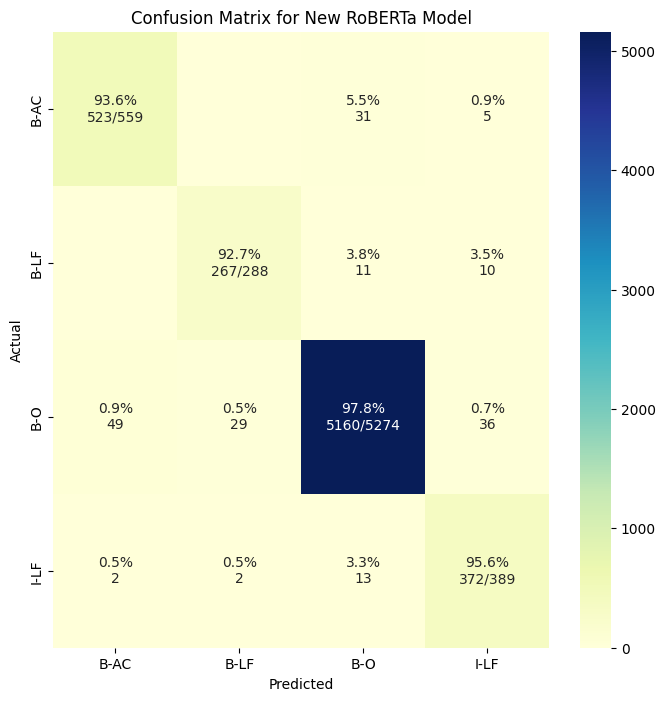

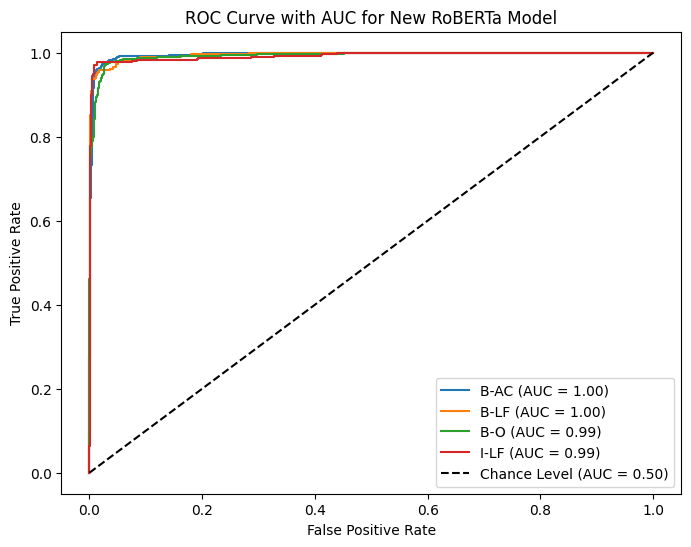

In [844]:
new_RobBERTa_model_results = train_and_eval(flatten_train_vec_tokens, flatten_test_vec_tokens, flatten_train_labels, flatten_test_labels, 'New RoBERTa Model')

# Comparisons of the Additional Experiment

+-------------------------------+---------------------+------------------+--------------+--------------------+
|                               |   Overall Precision |   Overall Recall |   Overall F1 |   Overall Accuracy |
|-------------------------------+---------------------+------------------+--------------+--------------------|
| Logistic Regression           |            0.981988 |         0.979422 |     0.980703 |           0.980492 |
| RNN Original Dataset          |            0.984117 |         0.981545 |     0.982829 |           0.982796 |
| Logistic Regression 400k Data |            0.968313 |         0.963508 |     0.965905 |           0.965284 |
| New RoBERTa Model             |            0.975702 |         0.970603 |     0.973146 |           0.971121 |
+-------------------------------+---------------------+------------------+--------------+--------------------+


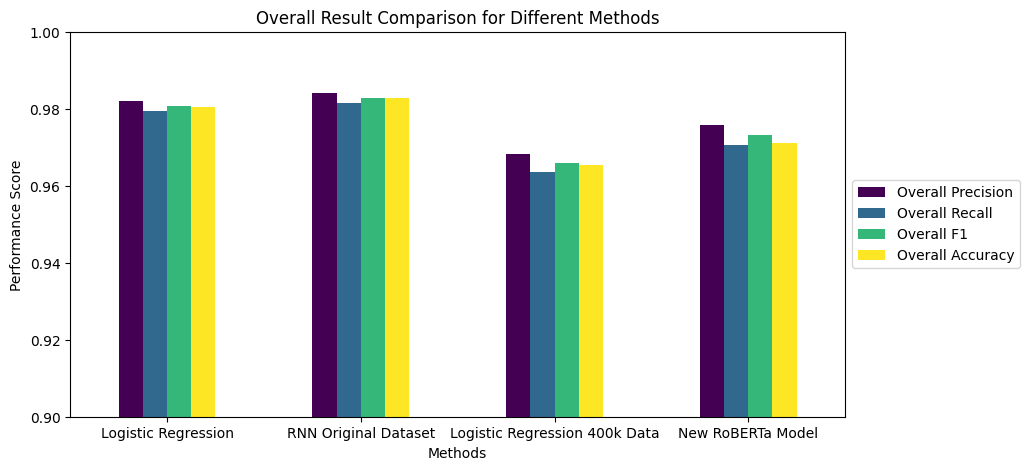

[0.9421338155515371, 0.9491833030852994, 0.8449848024316109, 0.9111498257839721]
+-------------------------------+----------------+-------------+----------+
|                               |   AC Precision |   AC Recall |    AC F1 |
|-------------------------------+----------------+-------------+----------|
| Logistic Regression           |       0.942134 |    0.932021 | 0.93705  |
| RNN Original Dataset          |       0.949183 |    0.935599 | 0.942342 |
| Logistic Regression 400k Data |       0.844985 |    0.965278 | 0.901135 |
| New RoBERTa Model             |       0.91115  |    0.935599 | 0.923213 |
+-------------------------------+----------------+-------------+----------+


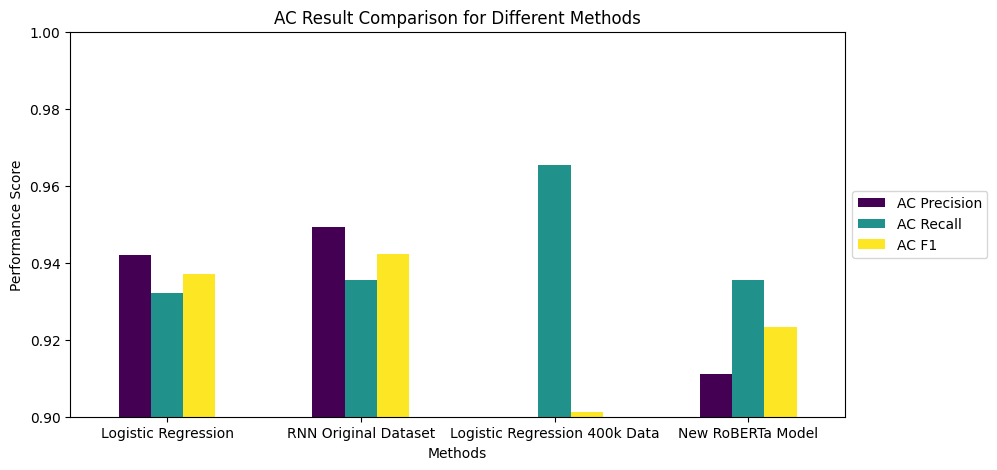

[0.9222972972972973, 0.9266666666666666, 0.8569553805774278, 0.8609271523178808]
+-------------------------------+----------------+-------------+----------+
|                               |   LF Precision |   LF Recall |    LF F1 |
|-------------------------------+----------------+-------------+----------|
| Logistic Regression           |       0.922297 |    0.941379 | 0.931741 |
| RNN Original Dataset          |       0.926667 |    0.958621 | 0.942373 |
| Logistic Regression 400k Data |       0.856955 |    0.951895 | 0.901934 |
| New RoBERTa Model             |       0.860927 |    0.896552 | 0.878378 |
+-------------------------------+----------------+-------------+----------+


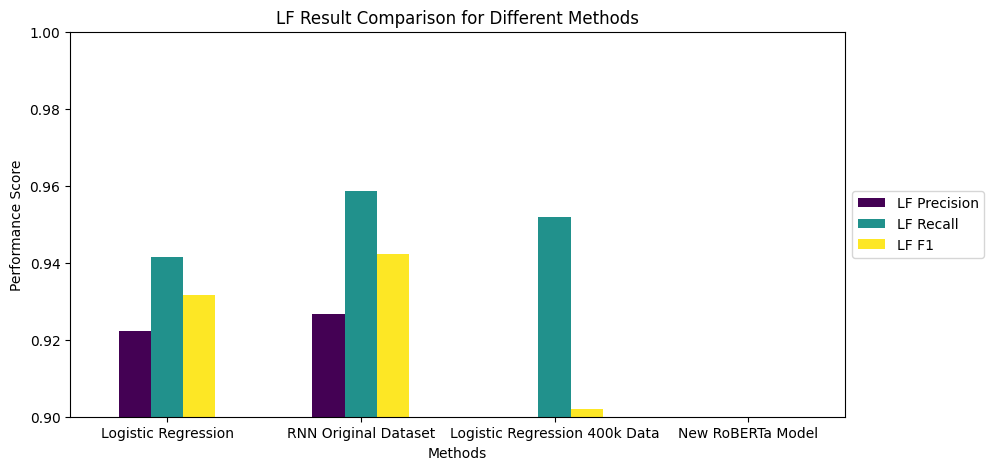

[0.9895397489539749, 0.9910578386605784, 0.9927818962153726, 0.9894534995206136]
+-------------------------------+---------------+------------+----------+
|                               |   O Precision |   O Recall |     O F1 |
|-------------------------------+---------------+------------+----------|
| Logistic Regression           |      0.98954  |   0.986538 | 0.988036 |
| RNN Original Dataset          |      0.991058 |   0.987675 | 0.989364 |
| Logistic Regression 400k Data |      0.992782 |   0.964922 | 0.978654 |
| New RoBERTa Model             |      0.989453 |   0.978385 | 0.983888 |
+-------------------------------+---------------+------------+----------+


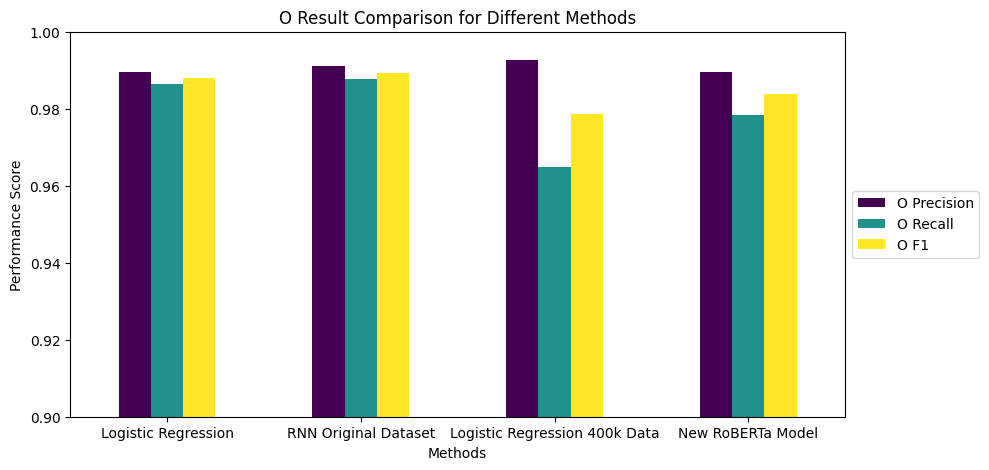

In [846]:
results = [LR_results, RNN_ori_results, logistic_400, new_RobBERTa_model_results]
names = ['Logistic Regression', 'RNN Original Dataset', 'Logistic Regression 400k Data', 'New RoBERTa Model']
plot_overall_comparison(results, names, ylim=(0.9,1))
plot_comparison(results, names, 'AC', ylim=(0.9,1))
plot_comparison(results, names, 'LF', ylim=(0.9,1))
plot_comparison(results, names, 'O', ylim=(0.9,1))
